<a href="https://colab.research.google.com/github/ab2gbl/ECG-detection/blob/main/features/Extract_features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

!mkdir '/content/physionet.org'
!mkdir '/content/physionet.org/files'
#!mkdir '/content/physionet.org/files/edb'
!cp -r '/content/drive/MyDrive/Final project/dataset/physionet.org/files/edb' '/content/physionet.org/files/'
!cp -r '/content/drive/MyDrive/Final project/dataset/physionet.org/files/mitdb' '/content/physionet.org/files/'


In [ ]:
!mkdir -p /content/ECG_AgentSystem/models
!mkdir -p /content/ECG_AgentSystem/data
!mkdir -p /content/ECG_AgentSystem/functions
!mkdir -p /content/ECG_AgentSystem/output


In [ ]:
!pip install wfdb
#!pip install keras-tuner --quiet
#!pip install resnet1d
!pip install tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 42.2 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.


In [1]:
import wfdb
from scipy.signal import butter, filtfilt
import numpy as np
from scipy.signal import resample
import os


# Predection

## preprocess Functions


In [2]:
from scipy.signal import butter, filtfilt
import numpy as np
def bandpass_filter(signal, lowcut=0.5, highcut=10, fs=250, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)
def smooth_signal(data, window_size=5):
    # Smooth the signal using a moving average filter
    window = np.ones(window_size) / window_size
    smoothed = np.convolve(data, window, mode='same')
    return smoothed
def normalize_signal(data):
    """
    Normalize the signal using z-score normalization.
    """
    return (data - np.mean(data)) / np.std(data)
def resample_signal(signal, original_fs, target_fs):
    num_samples = int(len(signal) * target_fs / original_fs)
    resampled_signal = resample(signal, num_samples)
    return resampled_signal

## Prediction Functions

In [3]:
def predict_full_ecg(signal, model, fs=250, window_size=240):
    model.eval()
    signal = signal[:len(signal) - (len(signal) % window_size)]  # crop to multiple of window_size
    signal = normalize_signal(smooth_signal(bandpass_filter(signal, fs=fs)))
    signal = signal.reshape(1, 1, -1)  # (1, 1, L)

    segments = []
    predictions = []

    for i in range(0, signal.shape[2] - window_size + 1, window_size):
        window = signal[:, :, i:i+window_size]
        segments.append(window)

    with torch.no_grad():
        for window in segments:
            window = torch.tensor(window, dtype=torch.float32).to(device)
            output = model(window)  # (1, C, L)
            pred = torch.argmax(output, dim=1).cpu().numpy()[0]  # (L,)
            predictions.append(pred)

    full_prediction = np.concatenate(predictions)
    return full_prediction, segments, predictions


In [4]:
def get_wave_boundaries(predicted_labels):
    wave_types = {1: 'P', 2: 'QRS', 3: 'T'}
    wave_boundaries = {k: [] for k in wave_types.values()}

    current_class = None
    start = None

    for i, label in enumerate(predicted_labels):
        if label in wave_types:
            if current_class is None:
                current_class = label
                start = i
            elif label != current_class:
                wave_boundaries[wave_types[current_class]].append((start, i-1))
                current_class = label
                start = i
        else:

            if current_class is not None:
                wave_boundaries[wave_types[current_class]].append((start, i-1))
                current_class = None
                start = None

    # Handle last segment
    if current_class is not None:
        wave_boundaries[wave_types[current_class]].append((start, len(predicted_labels)-1))

    return wave_boundaries


In [5]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_boundaries(signal, boundaries,signal_name, model_name, fs=250, zoom=(0, None)):
    time = np.arange(len(signal)) / fs  # in seconds

    plt.figure(figsize=(18, 6))
    plt.plot(time, signal, color='black', label='ECG Signal', linewidth=1)

    wave_colors = {'P': 'blue', 'QRS': 'red', 'T': 'green'}

    for wave_type, regions in boundaries.items():
        for start, end in regions:
            plt.fill_between(
                time[start:end],
                -1, 1,
                color=wave_colors.get(wave_type, 'gray'),
                alpha=0.3,
                label=f'Predicted {wave_type}'
            )

    # Prevent duplicate labels in legend
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), loc='upper right')

    plt.title(f"signal:{signal_name} , model: {model_name}", fontsize=16)
    plt.xlabel("Time (seconds)")
    plt.ylabel("Amplitude")
    plt.tight_layout()

    # Optional zoom
    if zoom[1] is None:
        plt.xlim(zoom[0], time[-1])
    else:
        plt.xlim(zoom)

    plt.show()


## Post-process Functions


In [7]:
import numpy as np

def remove_uncomplete_first_last_wave(predicted):
    """
    Merge or remove close-together same-class segments if separated only by background.
    :param predicted: 1D numpy array of predicted class labels (0=background, 1=P, 2=QRS, 3=T)
    :param target_class: 1 for P, 3 for T
    :return: modified predicted array
    """
    start = predicted[0]
    end = predicted[-1]
    if start != 0:
      i=0
      while i < len(predicted) and predicted[i]==start:
        i+=1
      predicted[:i]=0
    if end != 0:
      i=len(predicted)-1
      while i > -1 and predicted[i]==end:
        i-=1
      predicted[i+1:]=0

    return predicted

predicted = np.array([1,1,1,2,2, 0, 0, 1, 0, 2, 2, 3, 0, 0,0,2,1,3, 3])
print(len(predicted))

# Post-process P waves
predicted = remove_uncomplete_first_last_wave(predicted)
print(predicted)

(len(predicted))



19
[0 0 0 2 2 0 0 1 0 2 2 3 0 0 0 2 1 0 0]


19

In [8]:
import numpy as np

def merge_close_waves(predicted, max_gap=10):
  predicted = predicted.copy()
  for target_class in [1,2,3]:
    indices = np.where(predicted == target_class)[0]

    if len(indices) < 2:
        return predicted  # Nothing to merge

    for i in range(len(indices) - 1):
        current = indices[i]
        next_ = indices[i + 1]
        #print(next_-current-1)
        if 0 < next_ - current - 1 < max_gap:
            # Fill the gap between current and next with 1s
            predicted[current:next_ + 1] = target_class



  return predicted
predicted = np.array([0, 1, 1, 0, 1, 2, 2, 0, 0, 1, 2, 1, 1, 0, 0, 2, 2, 0, 3, 3, 3, 3, 3, 0])
print(len(predicted))

predicted = merge_close_waves(predicted)
print(predicted)
print(len(predicted))


24
[0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 2 2 0 3 3 3 3 3 0]
24


In [9]:
def remove_irrelevant_waves(predicted,start_search=2,end_search=5):
    """
    Remove waves before the first P and after the last T that are not relevant.
    :param predicted: 1D numpy array of predicted class labels (0=background, 1=P, 2=QRS, 3=T)
    :return: modified predicted array
    """
    # print(predicted)

    start=0
    # Step 1: Find the first P that has a QRS after it
    if 1 in predicted[:start_search*250] :
      # print("found p in first 2s")

      for i in range(len(predicted)-1):
          start = i

          if predicted[i] == 1:
              start = i
              # skip 1
              while i < len(predicted)-1 and predicted[i] == 1:
                i += 1
              # if it's not 0 or 2 break
              if predicted[i] == 3:
                continue
              # skip background if it exist
              if predicted[i] == 0:
                while i < len(predicted)-1 and predicted[i] == 0:
                  i += 1
              # if it's not qrs continue to next p
              if predicted[i] != 2:
                continue
              else:
                break
      #print("start:",start)
      predicted[:start] = 0


    # step 2 : remove after last T
    if 3 in predicted[-end_search*250:]:
      # print("found t in last 5s")

      end = predicted[-1]
      for i in range((len(predicted) - 1), -1, -1):
          end = i

          if predicted[i] == 3:
              end = i
              # skip 1
              while i > 0 and predicted[i] == 3:
                i -= 1
              # if it's not 0 or 2 break
              if predicted[i] == 1:
                print("found 1")
                continue
              # skip background if it exist
              if predicted[i] == 0:
                while i > 0 and predicted[i] == 0:
                  i -= 1
              # if it's not qrs continue to next p
              if predicted[i] != 2:
                continue
              else:
                break
      #print("end:",end)
      predicted[end+1:] = 0







    return (predicted)

# Now, i is the index of the first value that is NOT 1 after the P wave segment



# Example usage
predicted = np.array([0, 1, 1, 0,0,3,2,0,0,1,1,0,2,2,0,0,1,0,1,1,0,0 ,2, 2,0,3,3,3,3 ,3, 0, 3, 3, 0])  # Example of predictions
#predicted = np.array([ 2,0,3, 3, 3, 3, 3, 0])  # Example of predictions
print(len(predicted))

cleaned_predicted = remove_irrelevant_waves(predicted)
print(cleaned_predicted)
print(len(predicted))


34
[0 0 0 0 0 0 0 0 0 1 1 0 2 2 0 0 1 0 1 1 0 0 2 2 0 3 3 3 3 3 0 0 0 0]
34


In [10]:
import numpy as np

def check_repeated_waves(predicted):
    """
    Merge or remove close-together same-class segments if separated only by background.
    :param predicted: 1D numpy array of predicted class labels (0=background, 1=P, 2=QRS, 3=T)
    :param target_class: 1 for P, 3 for T
    :return: modified predicted array
    """
    cleaned = predicted.copy()
    for target_class in [1,2,3]:
      segments = []
      in_segment = False
      start = 0

      # Step 1: Collect all segments of the target class
      for i, val in enumerate(predicted):
          if val == target_class and not in_segment:
              in_segment = True
              start = i
          elif val != target_class and in_segment:
              in_segment = False
              segments.append((start, i - 1))
      if in_segment:
          segments.append((start, len(predicted) - 1))

      # Step 2: Check for pairs of segments with only background (0) in between
      i = 0
      while i < len(segments) - 1:
          s1, e1 = segments[i]
          s2, e2 = segments[i + 1]
          between = cleaned[e1 + 1:s2]

          if np.all(between == 0):  # Only background between them
              len1 = e1 - s1 + 1
              len2 = e2 - s2 + 1

              # Remove the shorter one
              if len1 < len2:
                  cleaned[s1:e1 + 1] = 0
              else:
                  cleaned[s2:e2 + 1] = 0

              # Remove the deleted segment from the list
              segments.pop(i if len1 < len2 else i + 1)
          else:
              i += 1


    return cleaned

predicted = np.array([0, 1, 1,1, 0,1,1, 2, 2, 0, 0, 1, 0, 1, 1, 0, 0, 2, 2,0, 2, 2, 2,  0, 3, 3, 0, 3,3, 3, 0,])
print(len(predicted))
predicted = check_repeated_waves(predicted)
print(predicted)
print(len(predicted))



31
[0 1 1 1 0 0 0 2 2 0 0 0 0 1 1 0 0 0 0 0 2 2 2 0 0 0 0 3 3 3 0]
31


In [11]:
print( min(1,2,3))

1


In [12]:
from scipy.signal import find_peaks

def fix_before_P(signal,mask,p_start,p_end,slope_threshold=0.02):
  diff_signal = np.diff([signal[p_start],signal[p_start-5]])  # check around the Q point for slope change
  j = 0
  while True:
    while np.abs(diff_signal[-1]) >= slope_threshold and signal[p_start]>signal[p_start-1] and mask[p_start-1]==0:  # Continue until slope becomes small
        j+=1
        p_start -= 1
        mask[p_start] = 1  # mark as part of the QRS
        diff_signal = np.diff([signal[p_start],signal[p_start-5]])  # re-evaluate slope
    if mask[p_start-1]!=0:
      break
    if j == 0:

        slope_threshold -= 0.001
        #print("slope_threshold: ",slope_threshold)
        if slope_threshold < 0.005:
          break
    else:
        break
  #print ("fixed_before with peak:",j)
  return mask,p_start


def fix_P(signal, mask):
    p_mask = (mask == 1).astype(int)
    qrs_mask = (mask == 2).astype(int)

    transitions = np.diff(p_mask, prepend=0)
    p_starts = np.where(transitions == 1)[0]

    qrs_starts = np.where(np.diff(qrs_mask, prepend=0) == 1)[0]

    fixed_p_info = []

    for i in range(len(p_starts)):

        slope_threshold = 0.02  # arbitrary threshold for slope to be considered small
        p_start = p_starts[i]

        p_next = p_starts[i+1] if i < len(p_starts) - 1 else len(mask)
        p_indices = np.where((mask == 1) & (np.arange(len(mask)) >= p_start) & (np.arange(len(mask)) < p_next))[0]

        p_end = p_indices[-1] if  len(p_indices)>0 else p_start
        #print("p_start,p_end: ",p_start,p_end)
        # Get indices of current P segment
        if len(p_indices) < 3:
            continue

        p_wave = signal[p_indices]

        # Check for peak inside current P segment
        peaks, _ = find_peaks(p_wave, prominence=0.01)
        has_peak = len(peaks) > 0
        peak_index = p_indices[peaks[0]] if has_peak else None

        # If no peak, look after end of P segment
        post_p_peak_index = None
        if has_peak:
          #print("has peak")
          mask, p_start = fix_before_P(signal, mask,p_start,p_end)
          j=0
          #print(p_end)
          while (p_end + 1 < len(signal)) and signal[p_end] > signal[p_start] and mask[p_end + 1] == 0:
            j += 1
            p_end += 1
            mask[p_end] = 1
        if not has_peak:

            # Look ahead to the next QRS start
            next_qrs_start = qrs_starts[qrs_starts > p_end]
            next_qrs_start = next_qrs_start[0] if len(next_qrs_start) > 0 else len(signal)

            # Look AFTER the P segment
            post_range = np.arange(p_start,min(len(signal) ,p_end + 50,  next_qrs_start ))
            post_peaks = []
            if len(post_range) > 3:
                post_wave = signal[post_range]
                peaks, _ = find_peaks(post_wave, prominence=0.01)
                # Filter by mask == 0
                for p in peaks:
                    peak_idx = post_range[p]
                    # Check that the region from p_end to peak_idx is all mask == 0
                    if np.all(mask[p_end+1:peak_idx + 1] == 0):
                        post_peaks.append(peak_idx)


            # Look BEFORE the P segment
            pre_range = np.arange(max(0, p_start - 50), p_end)  # limit the look-back window to ~400ms
            pre_peaks = []
            if len(pre_range) > 3:
                pre_wave = signal[pre_range]
                peaks, _ = find_peaks(pre_wave, prominence=0.01)
                # Filter by mask == 0
                pre_peaks = [pre_range[p] for p in peaks if mask[pre_range[p]] == 0]
                for p in peaks:
                    peak_idx = pre_range[p]
                    # Check that the region from p_end to peak_idx is all mask == 0
                    if np.all(mask[peak_idx + 1:p_start] == 0):
                        pre_peaks.append(peak_idx)

            # Closest peak
            ## Combine both and choose closest properly
            closest_peak = None
            min_distance = float('inf')

            ## Compare post-peaks to p_end
            for peak in post_peaks:
                dist = abs(peak - p_end)
                if dist < min_distance:
                    min_distance = dist
                    closest_peak = peak

            ## Compare pre-peaks to p_start
            for peak in pre_peaks:
                dist = abs(peak - p_start)
                if dist < min_distance:
                    min_distance = dist
                    closest_peak = peak

            post_p_peak_index = closest_peak if closest_peak is not None else None

            peak = None
            if post_p_peak_index is not None:
              if post_p_peak_index < p_start:
                peak = "before"
              else:
                peak = "after"


            #print(peak)
            if peak == "after":
                mask, p_start = fix_before_P(signal, mask,p_start,p_end)
                j=0
                while (p_end + 1 < len(signal)) and signal[p_end] > signal[p_start] and mask[p_end + 1] == 0:
                  j += 1
                  p_end += 1
                  mask[p_end] = 1
            elif peak == "before":

                mask[post_p_peak_index-2:p_start] = 1
                p_start = post_p_peak_index-2
                mask, p_start = fix_before_P(signal, mask,p_start,p_end)


        fixed_p_info.append({
            'start': p_indices[0],
            'end': p_indices[-1],
            'has_peak': has_peak,
            'peak_index': peak_index,
            'post_p_peak_index': post_p_peak_index
        })
        #print (fixed_p_info)

    return mask


In [13]:


def fix_QRS(signal, mask, fs=250):
    features_list = []
    time = np.arange(len(signal)) / fs

    # Find all QRS starts
    qrs_mask = (mask == 2).astype(int)
    transitions = np.diff(qrs_mask, prepend=0)
    qrs_starts = np.where(transitions == 1)[0]
    fixed_down = []
    fixed_up = []
    fixed_start = []

    slope_threshold = 0.02  # arbitrary threshold for slope to be considered small

    for i in range(len( qrs_starts)):
        #print("fixing qrs ",i)
        qrs_start = qrs_starts[i]
        next_qrs_start = qrs_starts[i+1] if i < len(qrs_starts) - 1 else len(mask)
        qrs_indices = np.where((mask == 2) & (np.arange(len(mask)) >= qrs_start) & (np.arange(len(mask)) < next_qrs_start))[0]
        qrs_end = qrs_indices[-1]
        j = 0

        # QRS Begining

        ## Searching for p
        p_indices = np.where(mask[:qrs_start] == 1)[0]
        valid_p = []
        for p_end in reversed(p_indices):
            if np.all(mask[p_end:qrs_start] != 2) and np.all(mask[p_end:qrs_start] != 3):
                p_start = p_end
                while p_start > 0 and mask[p_start - 1] == 1:
                    p_start -= 1
                valid_p = list(range(p_start, p_end + 1))
                break
        p_wave = signal[valid_p] if valid_p else np.array([])
        p_indices = valid_p if valid_p else np.array([])
        dist = qrs_start - p_indices[-1] if len(p_indices) > 0 else float('inf')
        #  if p
        if len(p_wave)>0 and dist < 20:
          mask[p_indices[-1]+1:qrs_start] = 2
          qrs_start = p_indices[-1]+1
        else:

          # Look BEFORE the QRS segment
          pre_range = np.arange(max(0, qrs_start - 100), qrs_start)  # limit to ~400ms before
          pre_peaks = []
          if len(pre_range) > 3:
              pre_wave = signal[pre_range]
              peaks, _ = find_peaks(pre_wave, prominence=0.01)
              pre_peaks = [pre_range[p] for p in peaks if mask[pre_range[p]] == 0]

          # Track first peak (if any)
          first_peak_before_qrs = pre_peaks[0] if pre_peaks else None

          # Begin slope-based backtracking
          j = 0
          while True:
              # Stop if slope is small
              if qrs_start - 3 < 0: break
              diff_signal = np.diff([signal[qrs_start], signal[qrs_start - 3]])

              if np.abs(diff_signal[-1]) < slope_threshold:
                  break

              # Stop if we hit the first peak
              if first_peak_before_qrs is not None and qrs_start <= first_peak_before_qrs:
                  break

              # Otherwise, continue extending the QRS
              if mask[qrs_start - 1] != 0:
                  break

              j += 1
              qrs_start -= 1
              mask[qrs_start] = 2  # extend QRS

              # Optional: decrease threshold if no progress
              if j == 0:

                  slope_threshold -= 0.001
                  if slope_threshold<0: break


        fixed_start.append(j)
        # QRS ending

        ## Before Q
        while signal[qrs_end] >= signal[qrs_end+1] and mask[qrs_end+1]==0:

            j+=1
            qrs_end += 1
            mask[qrs_end] = 2

        fixed_down.append(j)

        ## After Q
        diff_signal = np.diff([signal[qrs_end],signal[qrs_end+5]])  # check around the Q point for slope change
        j = 0
        while True:
          while np.abs(diff_signal[-1]) >= slope_threshold and mask[qrs_end+1]==0:  # Continue until slope becomes small
              j+=1
              qrs_end += 1
              mask[qrs_end] = 2  # mark as part of the QRS
              diff_signal = np.diff([signal[qrs_end],signal[qrs_end+5]])  # re-evaluate slope
          if mask[qrs_end+1]!=0:
            break
          if j == 0:
              slope_threshold -= 0.001
              if slope_threshold<0.005: break
          else:
              break

          #print ("j: ",j)
        fixed_up.append(j)


    #print ("fixed_down:",fixed_down)
    #print ("fixed_up:",fixed_up)
    #print ("slope_threshold: ",slope_threshold)
    return mask



In [14]:
def post_process_ecg(predicted):

    predicted = remove_uncomplete_first_last_wave(predicted)
    predicted = merge_close_waves(predicted)
    predicted = remove_irrelevant_waves(predicted)
    predicted = check_repeated_waves(predicted)

    return predicted

predicted = np.array([1,1,0, 1, 1, 0,0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 2, 2, 0, 3, 3, 0,0,0,0,0,0,3, 3, 3, 0,0,0,1, 1, 0, 0, 2, 2, 0, 3, 3,0,3,3])
predicted = post_process_ecg(predicted)
print(predicted)

[0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 2 2 0 3 3 3 3 3 3 3 3 3 3 3 0 0 0 1 1 0
 0 2 2 0 3 3 0 0 0]


## Load model

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualConvBlock1D(nn.Module):
    def __init__(self, in_channels, out_channels, dilation=1):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=3,
                              padding=dilation, dilation=dilation)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3,
                               padding=dilation, dilation=dilation)
        self.bn2 = nn.BatchNorm1d(out_channels)

        self.shortcut = nn.Sequential()
        if in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=1),
                nn.BatchNorm1d(out_channels)
            )

    def forward(self, x):
        residual = self.shortcut(x)
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.bn2(self.conv2(x))
        x += residual
        return F.relu(x)

class AttentionBlock(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super().__init__()
        self.W_g = nn.Sequential(
            nn.Conv1d(F_g, F_int, kernel_size=1),
            nn.BatchNorm1d(F_int)
        )

        self.W_x = nn.Sequential(
            nn.Conv1d(F_l, F_int, kernel_size=1),
            nn.BatchNorm1d(F_int)
        )

        self.psi = nn.Sequential(
            nn.Conv1d(F_int, 1, kernel_size=1),
            nn.BatchNorm1d(1),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi

class UNet1D_Enhanced(nn.Module):
    def __init__(self, in_channels=1, n_classes=4, base_filters=64):
        super().__init__()

        # Encoder with residual blocks and multi-scale context
        self.enc1 = ResidualConvBlock1D(in_channels, base_filters)
        self.pool1 = nn.MaxPool1d(2)

        self.enc2 = ResidualConvBlock1D(base_filters, base_filters*2)
        self.pool2 = nn.MaxPool1d(2)

        self.enc3 = ResidualConvBlock1D(base_filters*2, base_filters*4)
        self.pool3 = nn.MaxPool1d(2)

        self.enc4 = ResidualConvBlock1D(base_filters*4, base_filters*8)
        self.pool4 = nn.MaxPool1d(2)

        # Bottleneck with dilated convolution
        self.bottleneck = nn.Sequential(
            ResidualConvBlock1D(base_filters*8, base_filters*16, dilation=2),
            ResidualConvBlock1D(base_filters*16, base_filters*16, dilation=4)
        )

        # Decoder with attention gates
        self.upconv4 = nn.ConvTranspose1d(base_filters*16, base_filters*8, kernel_size=2, stride=2)
        self.att4 = AttentionBlock(base_filters*8, base_filters*8, base_filters//2)
        self.dec4 = ResidualConvBlock1D(base_filters*16, base_filters*8)

        self.upconv3 = nn.ConvTranspose1d(base_filters*8, base_filters*4, kernel_size=2, stride=2)
        self.att3 = AttentionBlock(base_filters*4, base_filters*4, base_filters//4)
        self.dec3 = ResidualConvBlock1D(base_filters*8, base_filters*4)

        self.upconv2 = nn.ConvTranspose1d(base_filters*4, base_filters*2, kernel_size=2, stride=2)
        self.att2 = AttentionBlock(base_filters*2, base_filters*2, base_filters//8)
        self.dec2 = ResidualConvBlock1D(base_filters*4, base_filters*2)

        self.upconv1 = nn.ConvTranspose1d(base_filters*2, base_filters, kernel_size=2, stride=2)
        self.att1 = AttentionBlock(base_filters, base_filters, base_filters//16)
        self.dec1 = ResidualConvBlock1D(base_filters*2, base_filters)

        # Output with multi-scale feature fusion
        self.final_conv = nn.Sequential(
            nn.Conv1d(base_filters, base_filters//2, kernel_size=3, padding=1),
            nn.BatchNorm1d(base_filters//2),
            nn.ReLU(),
            nn.Conv1d(base_filters//2, n_classes, kernel_size=1)
        )

        # Boundary refinement
        self.boundary_refine = nn.Conv1d(n_classes, n_classes, kernel_size=5, padding=2)

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        e3 = self.enc3(self.pool2(e2))
        e4 = self.enc4(self.pool3(e3))

        # Bottleneck
        b = self.bottleneck(self.pool4(e4))

        # Decoder with attention
        d4 = self.upconv4(b)
        e4 = self.att4(d4, center_crop(e4, d4.shape[-1]))
        d4 = self.dec4(torch.cat([d4, e4], dim=1))

        d3 = self.upconv3(d4)
        e3 = self.att3(d3, center_crop(e3, d3.shape[-1]))
        d3 = self.dec3(torch.cat([d3, e3], dim=1))

        d2 = self.upconv2(d3)
        e2 = self.att2(d2, center_crop(e2, d2.shape[-1]))
        d2 = self.dec2(torch.cat([d2, e2], dim=1))

        d1 = self.upconv1(d2)
        e1 = self.att1(d1, center_crop(e1, d1.shape[-1]))
        d1 = self.dec1(torch.cat([d1, e1], dim=1))

        # Output
        out = self.final_conv(d1)

        # Boundary refinement
        out = out + self.boundary_refine(out)  # Residual connection

        return out


def center_crop(enc_feat, target_size):
    _, _, L = enc_feat.size()
    diff = L - target_size
    if diff == 0:
        return enc_feat
    elif diff < 0:
        raise ValueError("Encoder feature shorter than target")
    start = diff // 2
    end = start + target_size
    return enc_feat[:, :, start:end]

In [16]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model
model_deep = UNet1D_Enhanced(n_classes=4).to(device)
model_deep.load_state_dict(torch.load("/content/drive/MyDrive/Final project/unet1d_ecg_qrs.pth", map_location=device))
model_deep.to(device)
model_deep.eval()

UNet1D_Enhanced(
  (enc1): ResidualConvBlock1D(
    (conv1): Conv1d(1, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (shortcut): Sequential(
      (0): Conv1d(1, 64, kernel_size=(1,), stride=(1,))
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc2): ResidualConvBlock1D(
    (conv1): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_st

# detection


In [18]:
import os
def get_all_records(directory, extension=".dat"):
    files = [f.replace(extension, "") for f in os.listdir(directory) if f.endswith(extension)]
    return list(set(files))  # Ensure no duplicates


mitdb_path = "/content/physionet.org/files/mitdb/1.0.0/"
edb_path = "/content/physionet.org/files/edb/1.0.0/"

# Get all record names dynamically
mit_records = get_all_records(mitdb_path)
edb_records = get_all_records(edb_path)

print(f"Found {len(mit_records)},{len(edb_records)} records.")

Found 48,90 records.


/content/physionet.org/files/edb/1.0.0/e0303


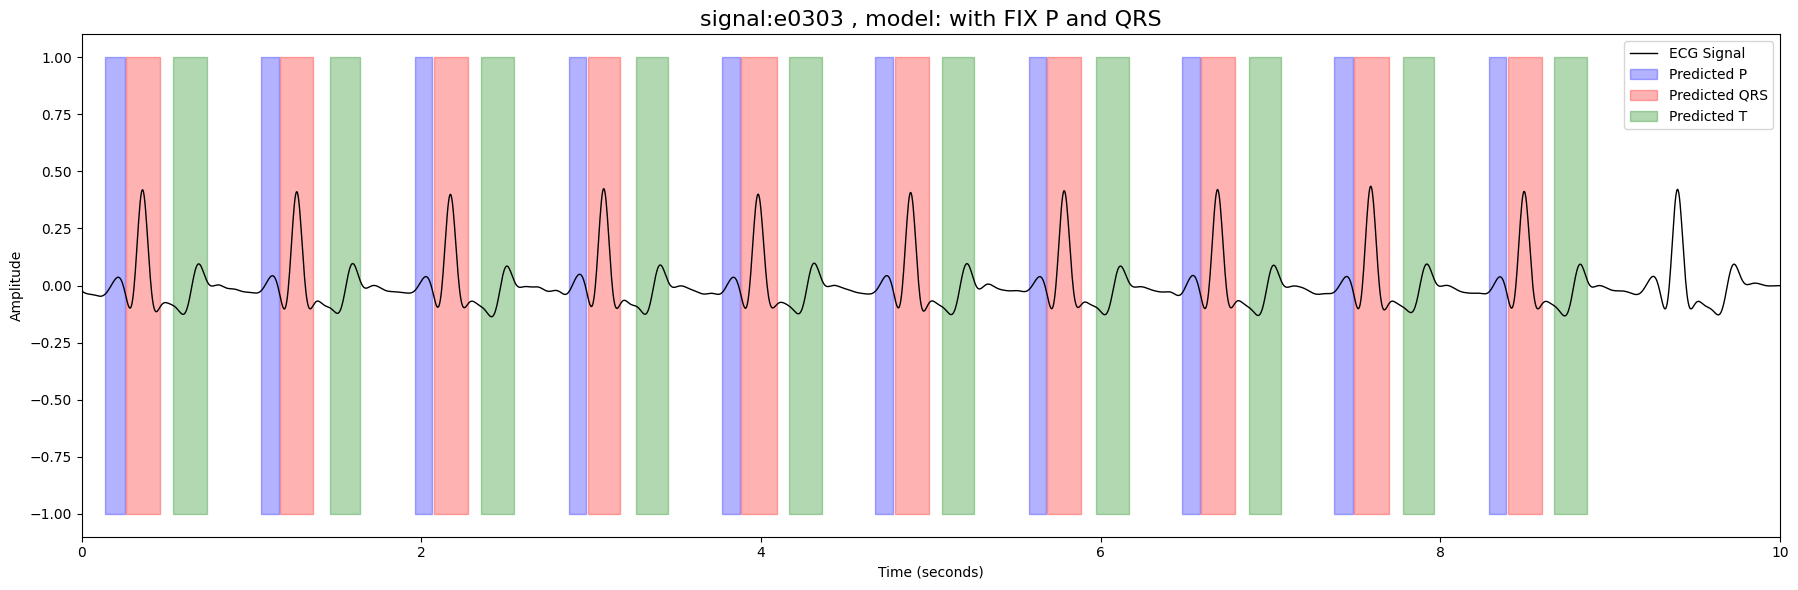

------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------
/content/physionet.org/files/edb/1.0.0/e0119


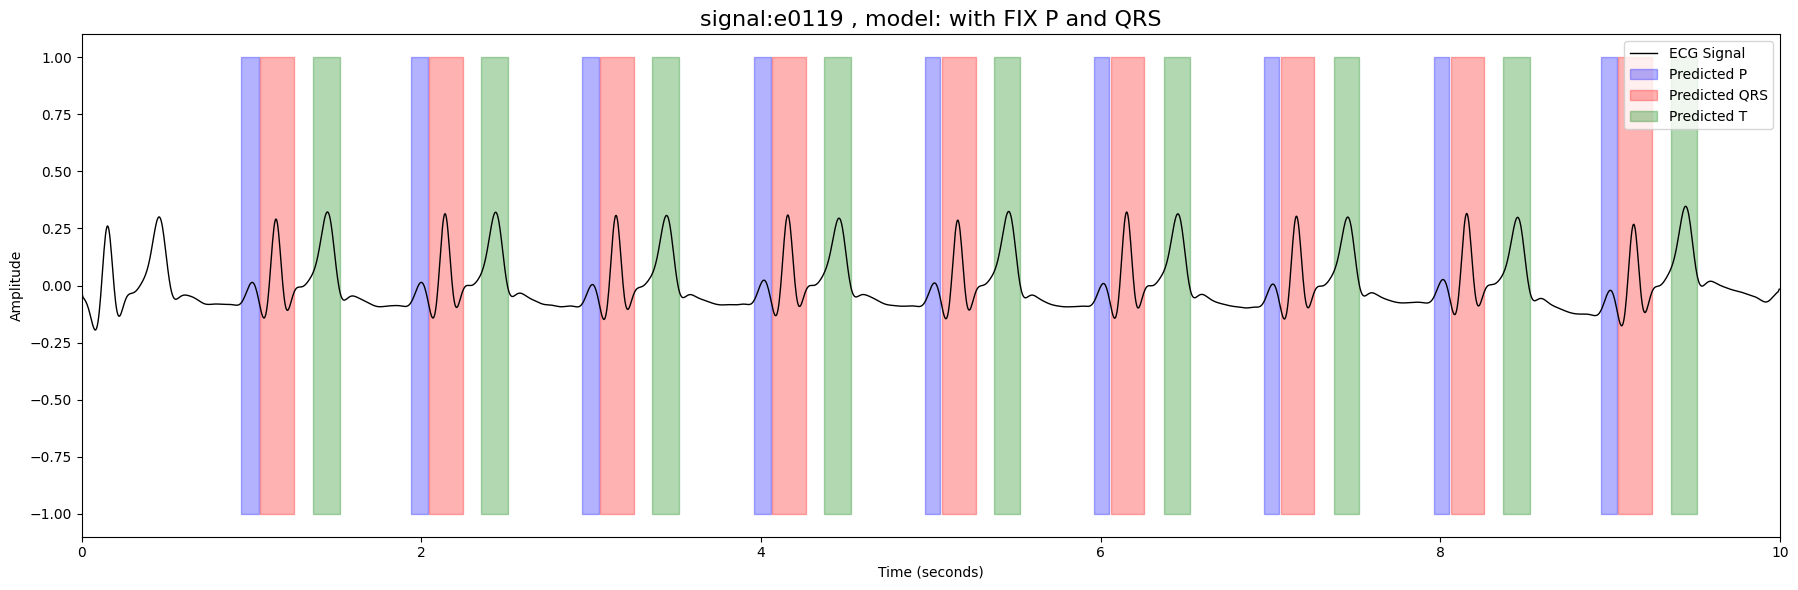

------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------
/content/physionet.org/files/edb/1.0.0/e1302


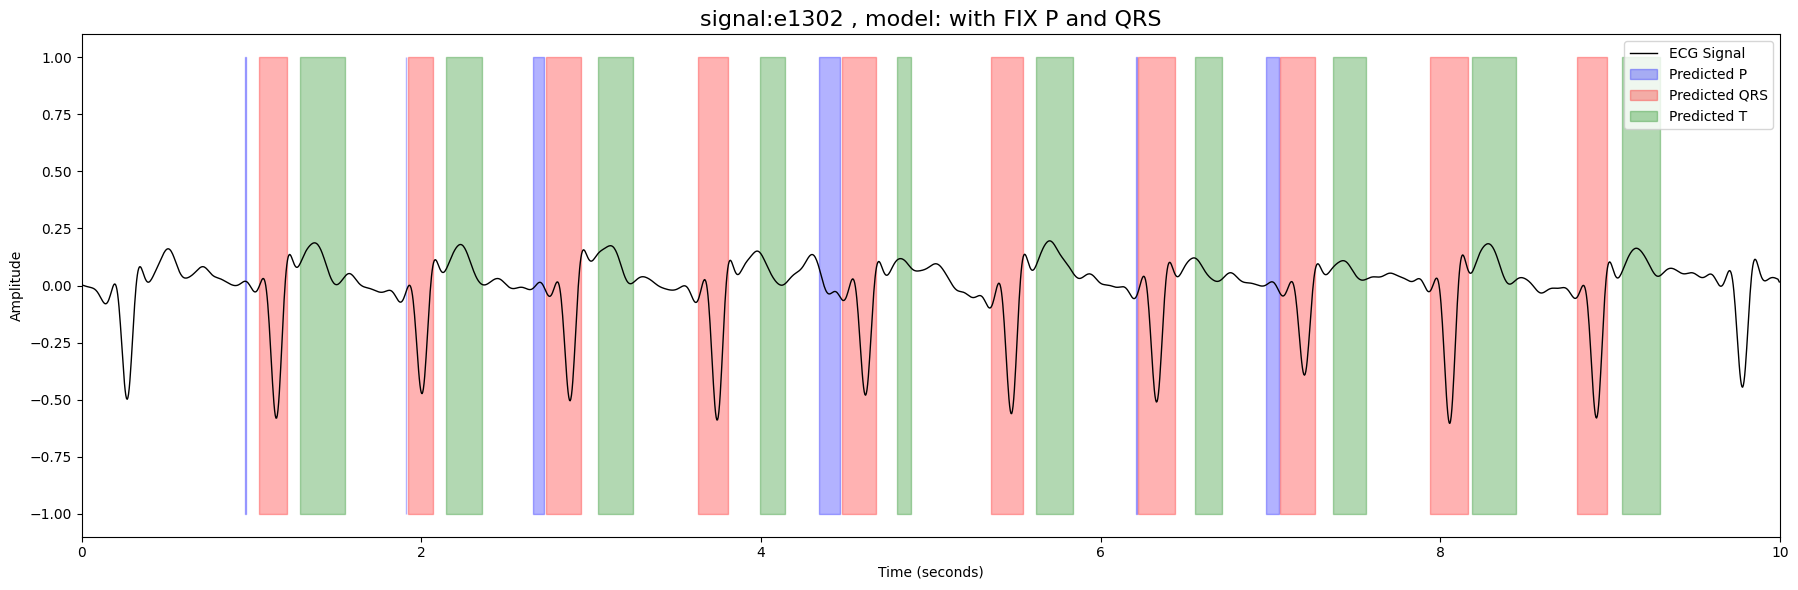

------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------
/content/physionet.org/files/edb/1.0.0/e0204


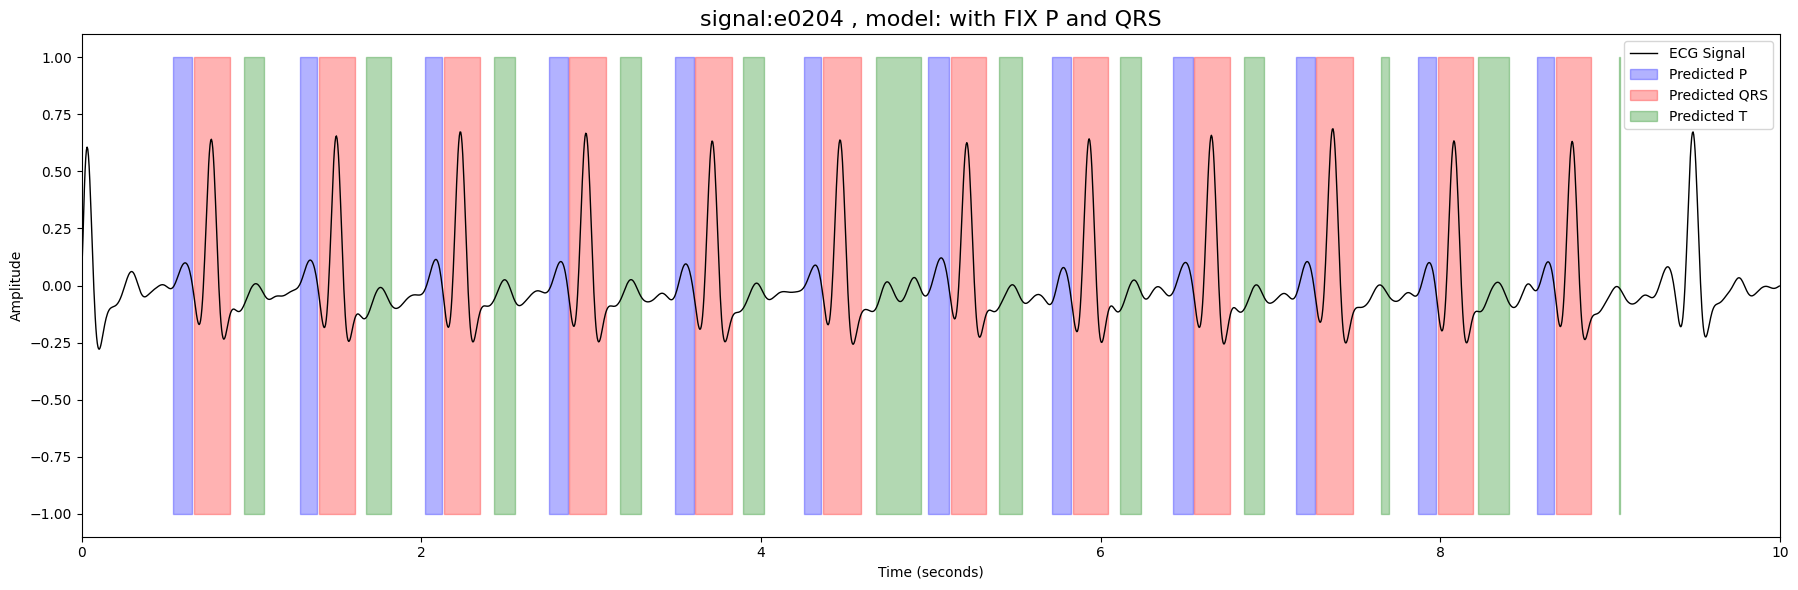

------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------
/content/physionet.org/files/edb/1.0.0/e0114


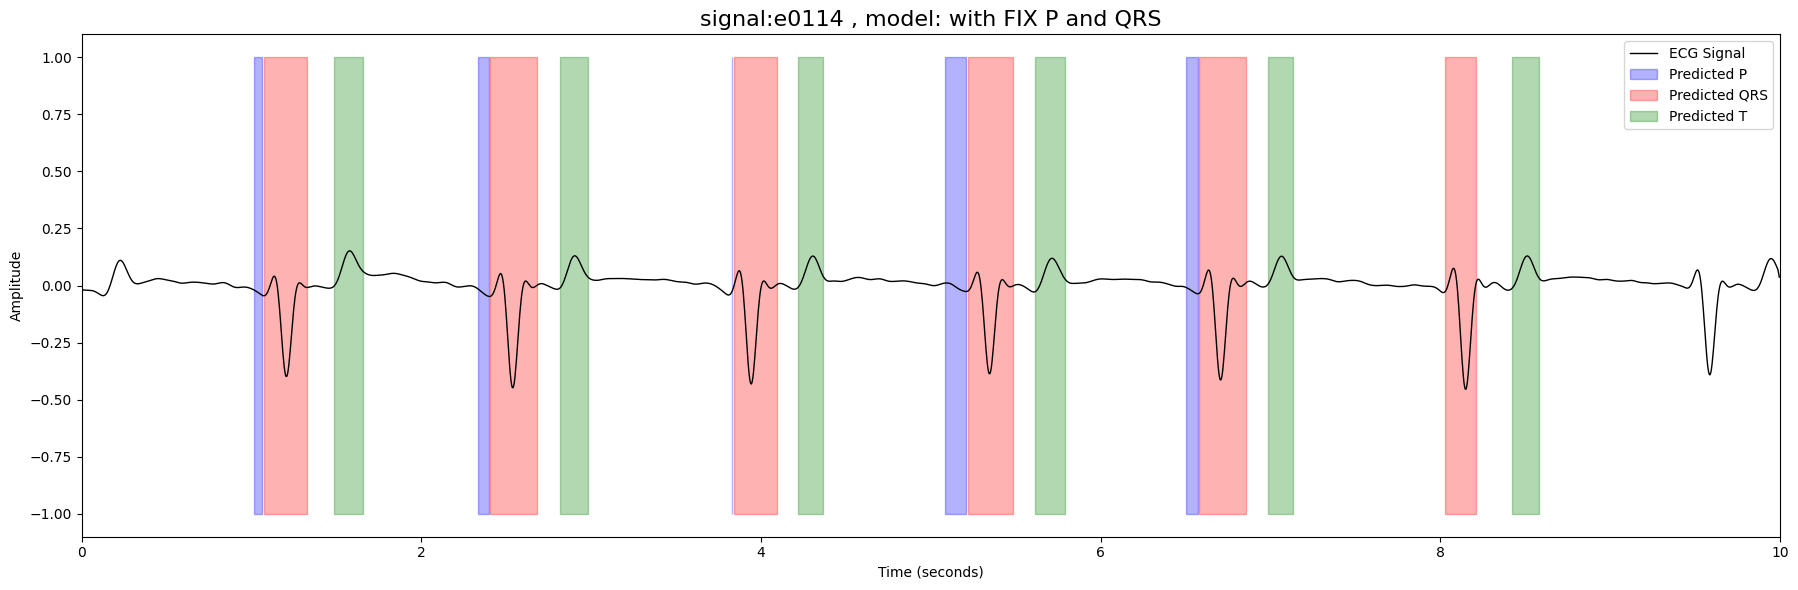

------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------
/content/physionet.org/files/edb/1.0.0/e0110


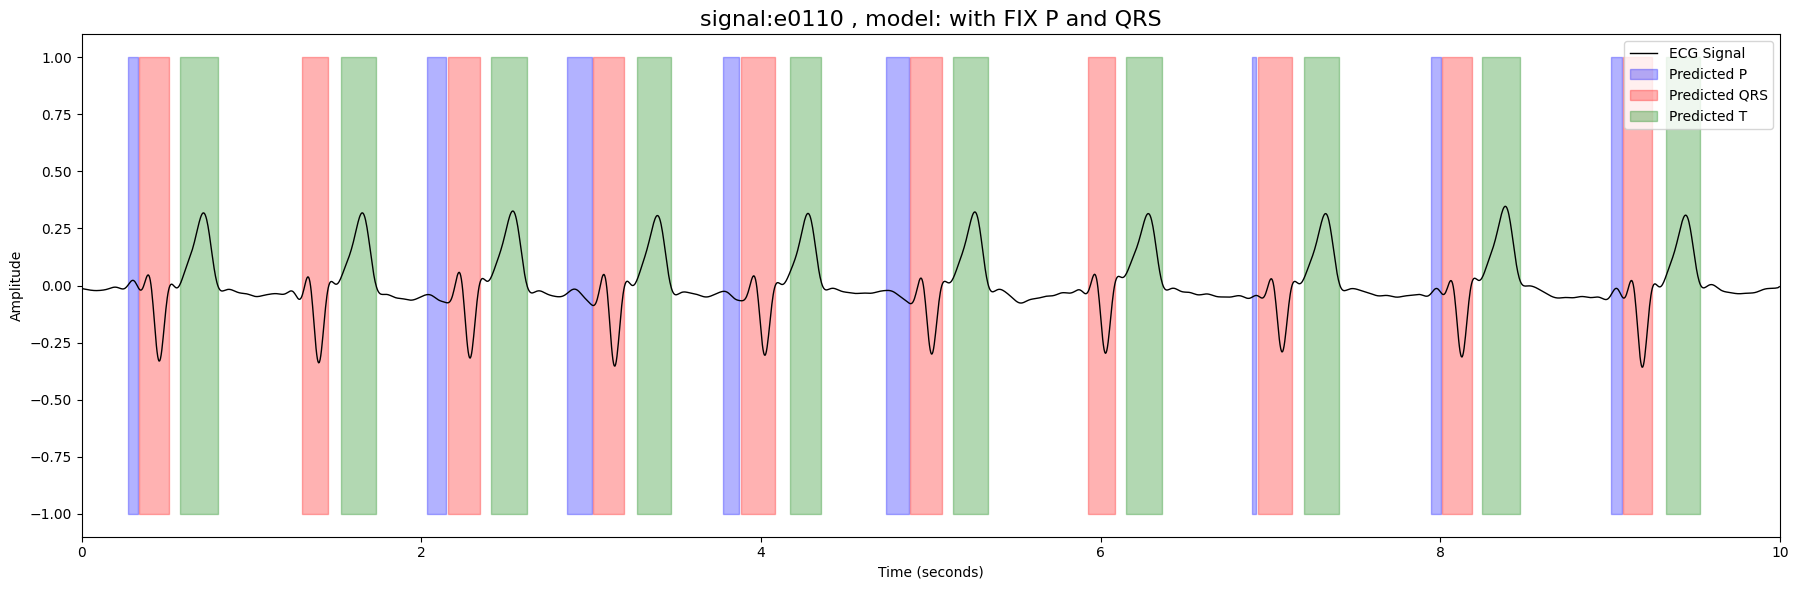

------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------
/content/physionet.org/files/edb/1.0.0/e0208


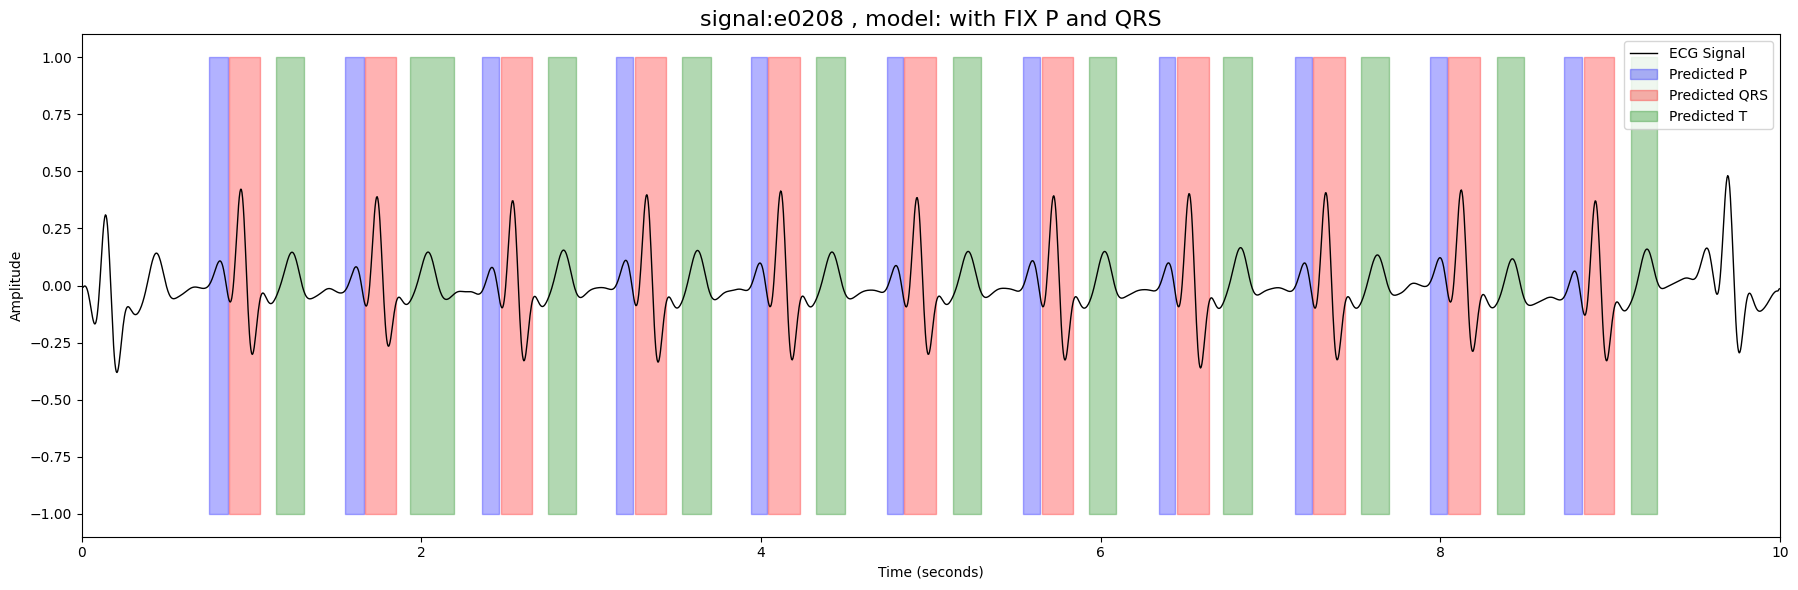

------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------
/content/physionet.org/files/edb/1.0.0/e0604


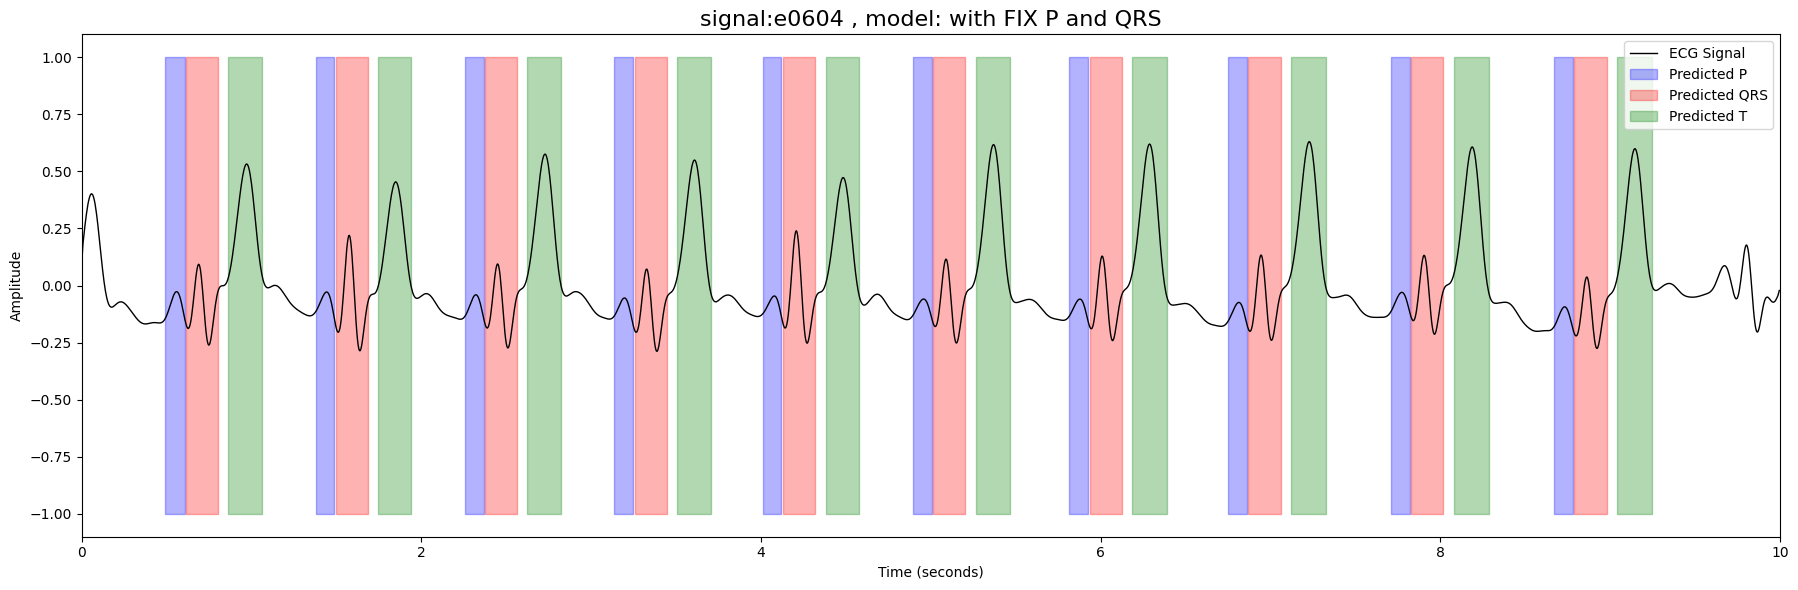

------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------
/content/physionet.org/files/edb/1.0.0/e0151


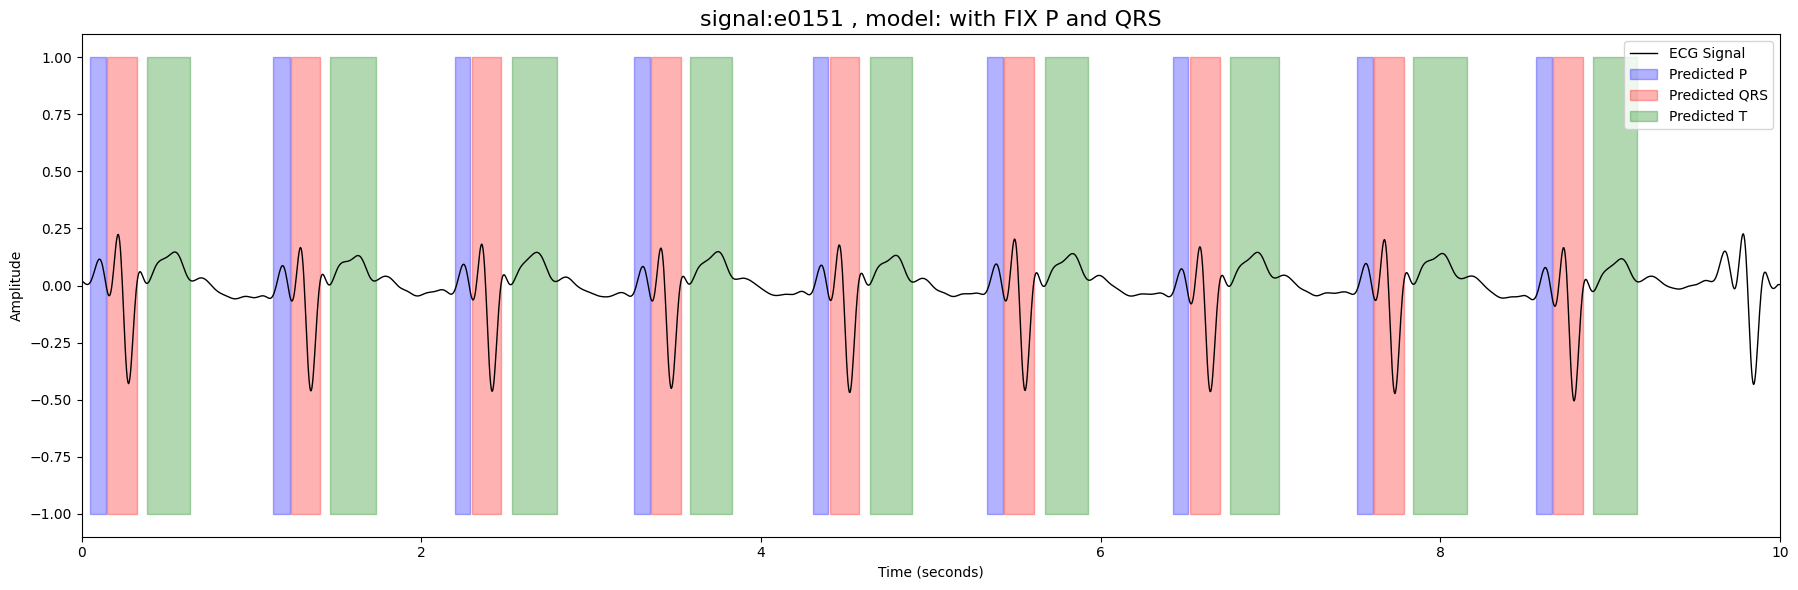

------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------
/content/physionet.org/files/edb/1.0.0/e0202


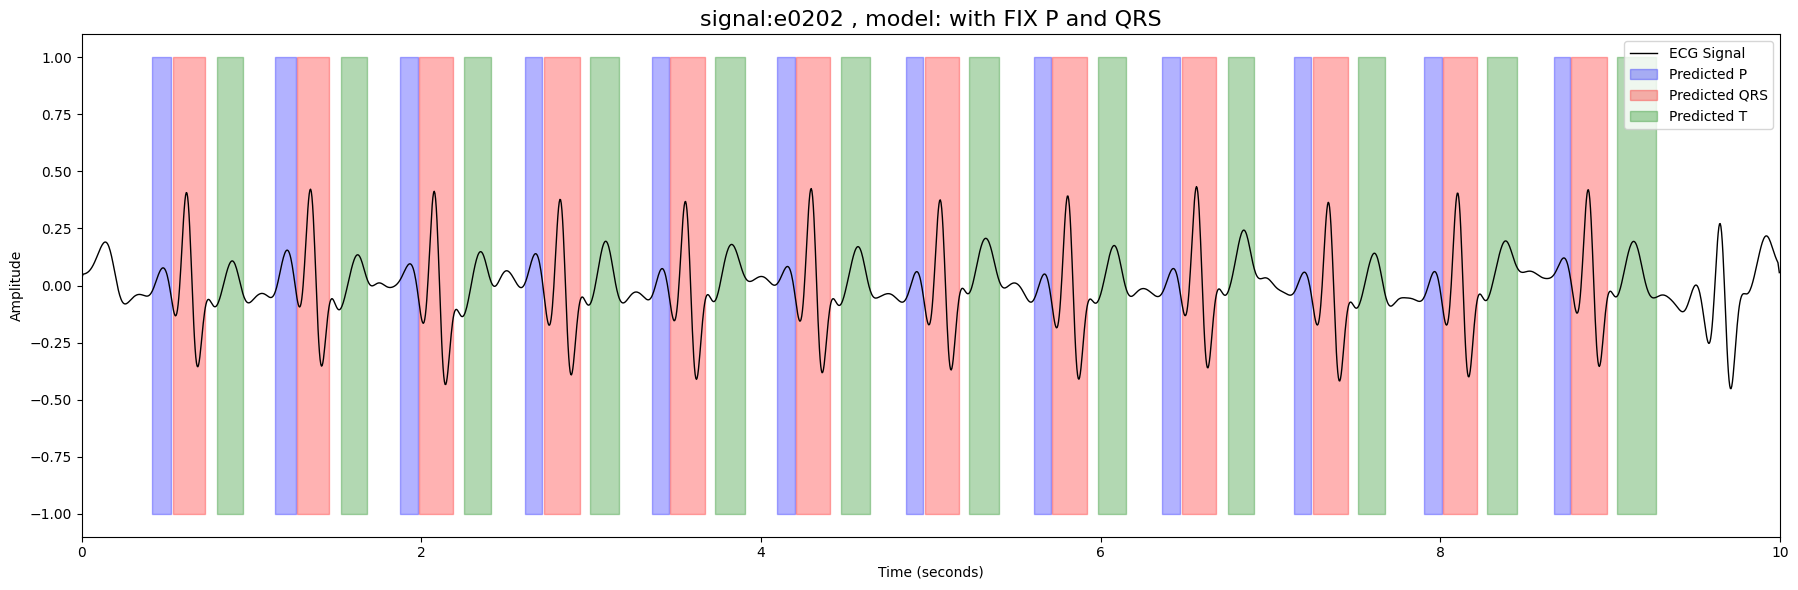

------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------
/content/physionet.org/files/edb/1.0.0/e0136


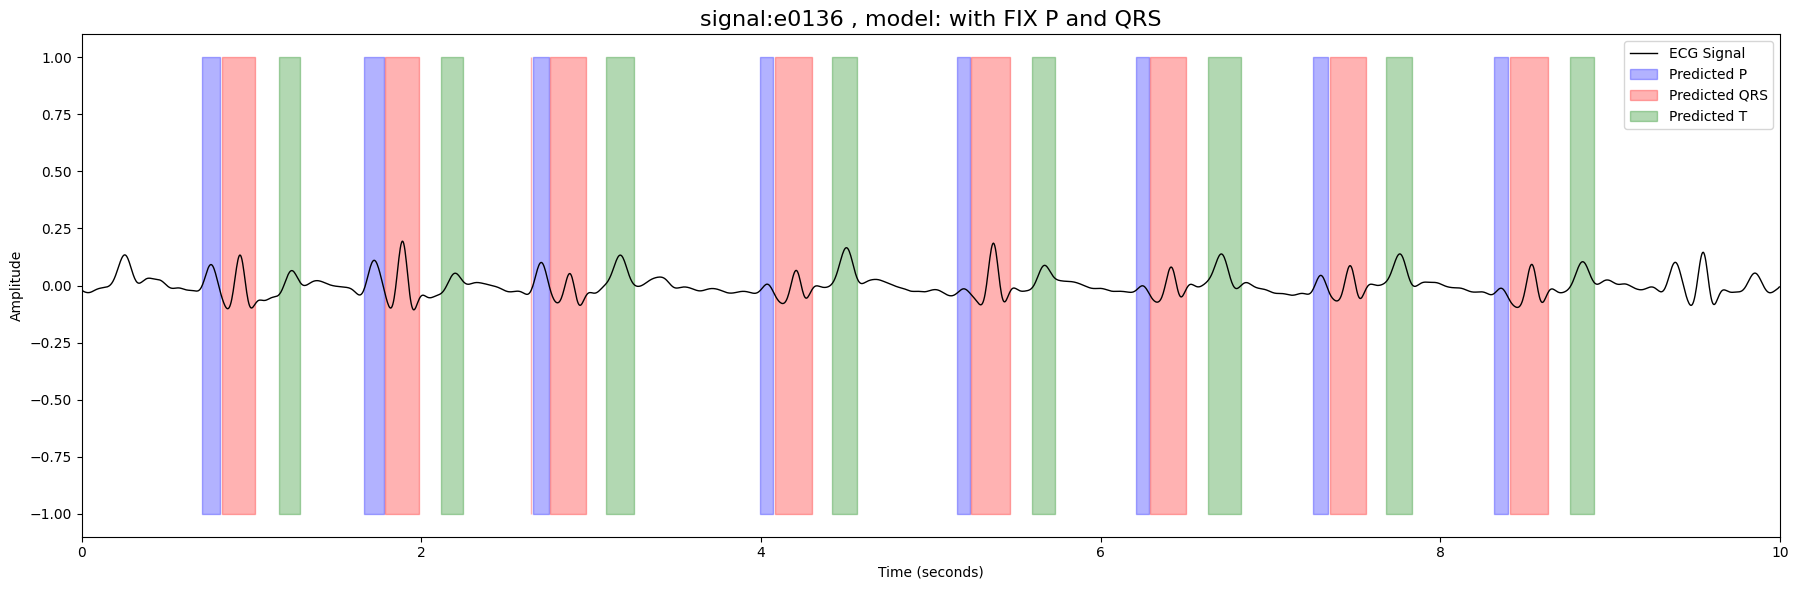

------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------
/content/physionet.org/files/edb/1.0.0/e0211


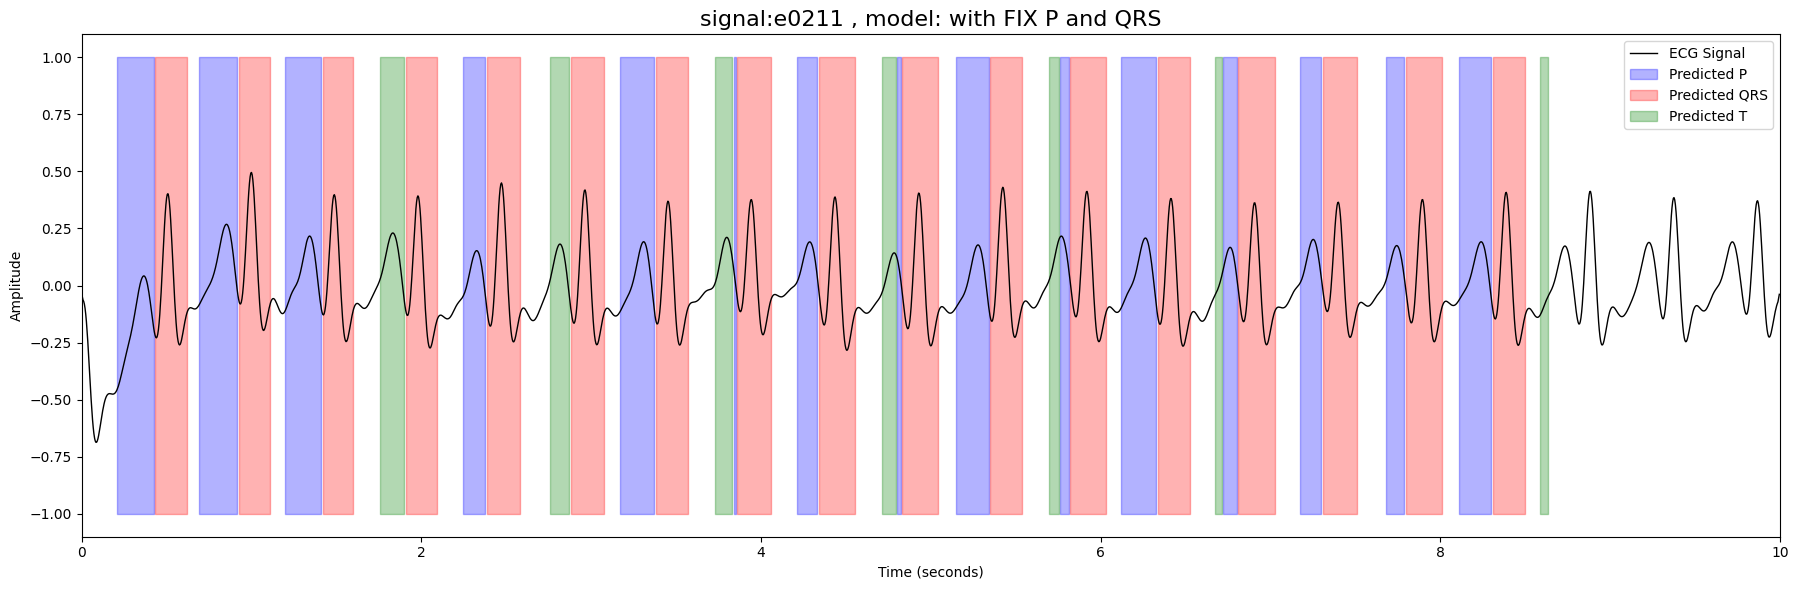

------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------
/content/physionet.org/files/edb/1.0.0/e0116


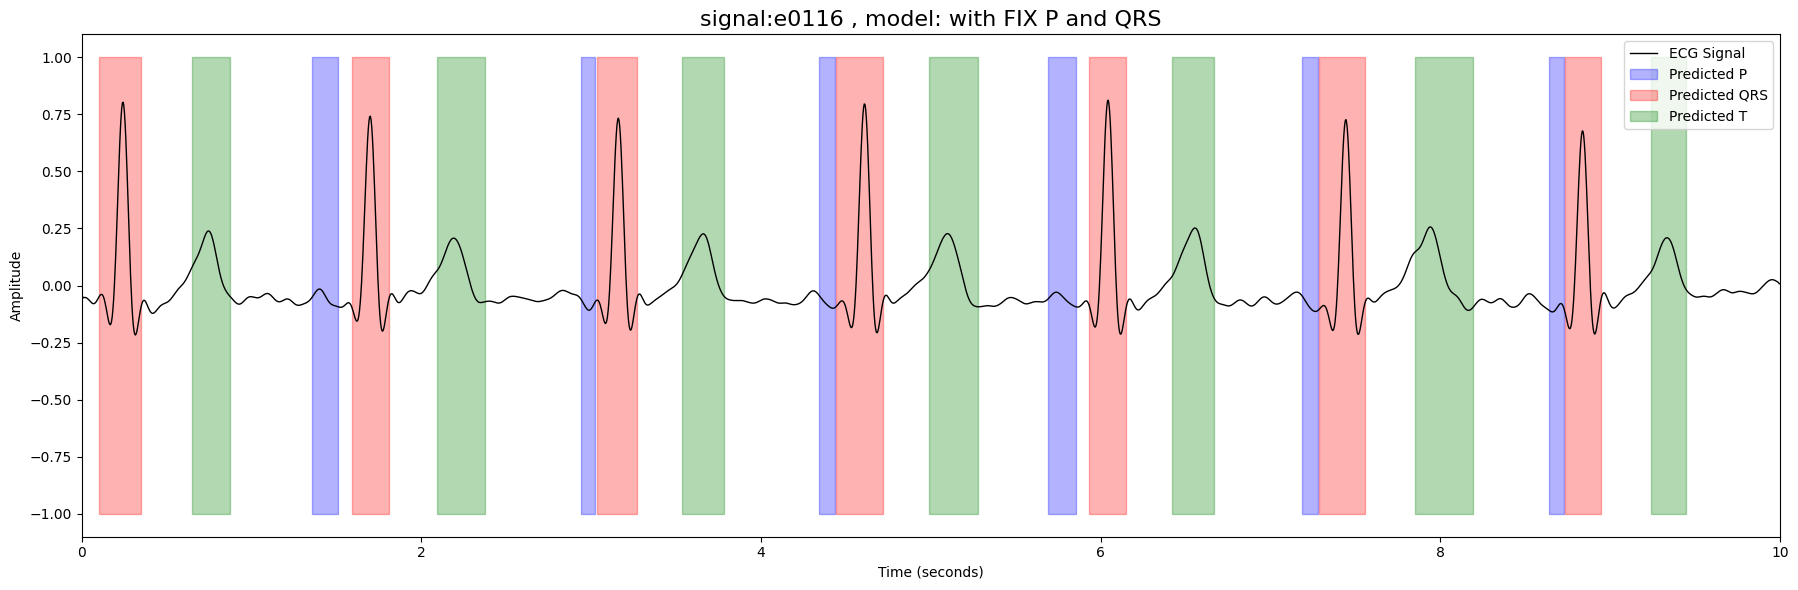

------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------
/content/physionet.org/files/edb/1.0.0/e0103


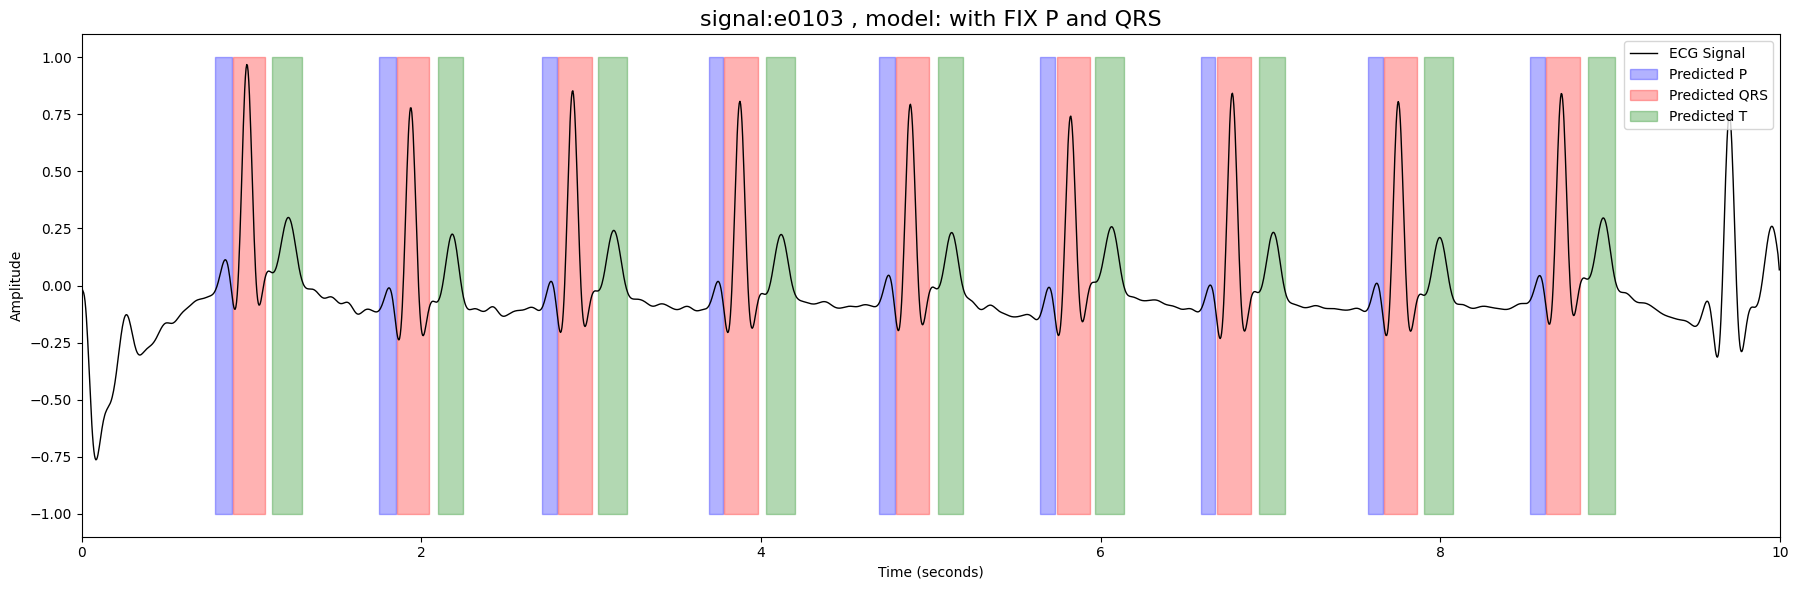

------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------
/content/physionet.org/files/edb/1.0.0/e0108


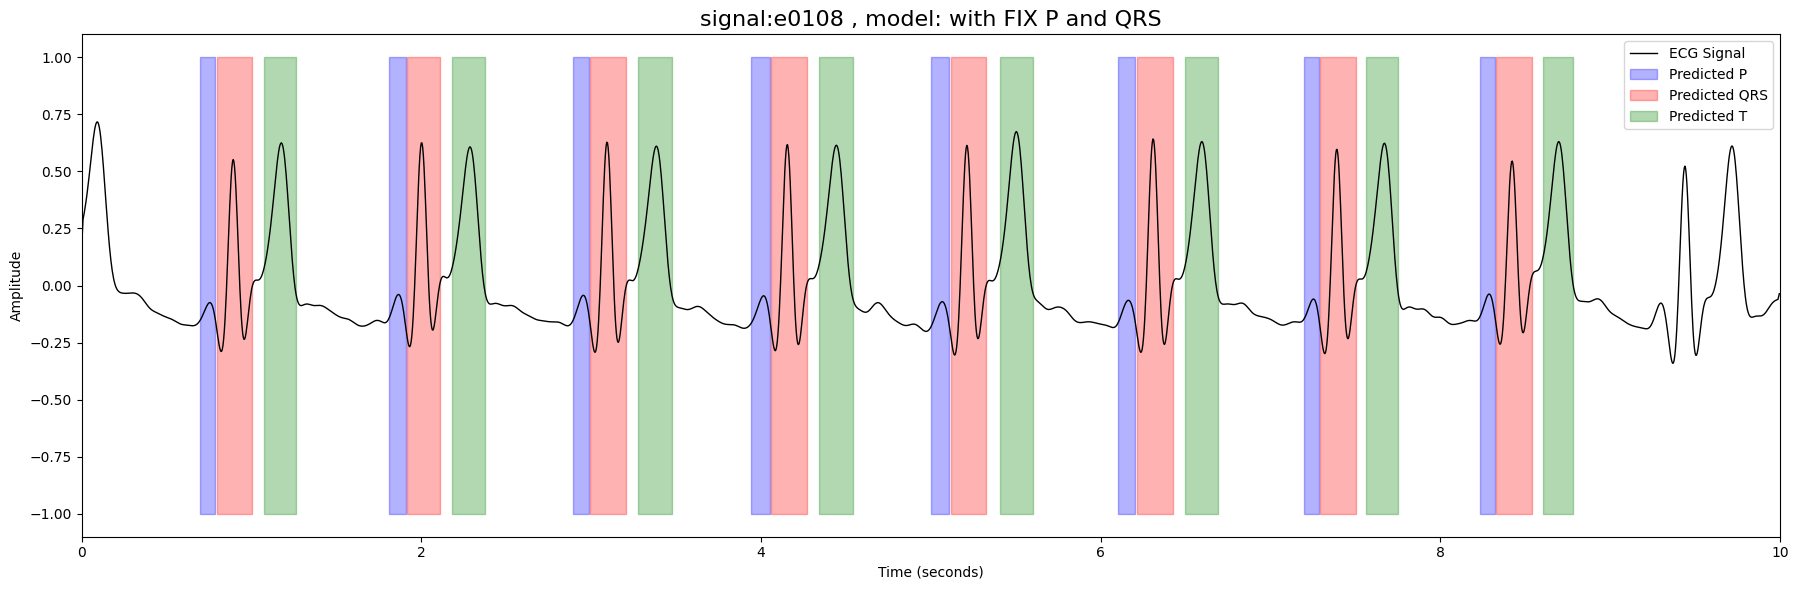

------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------
/content/physionet.org/files/edb/1.0.0/e0611


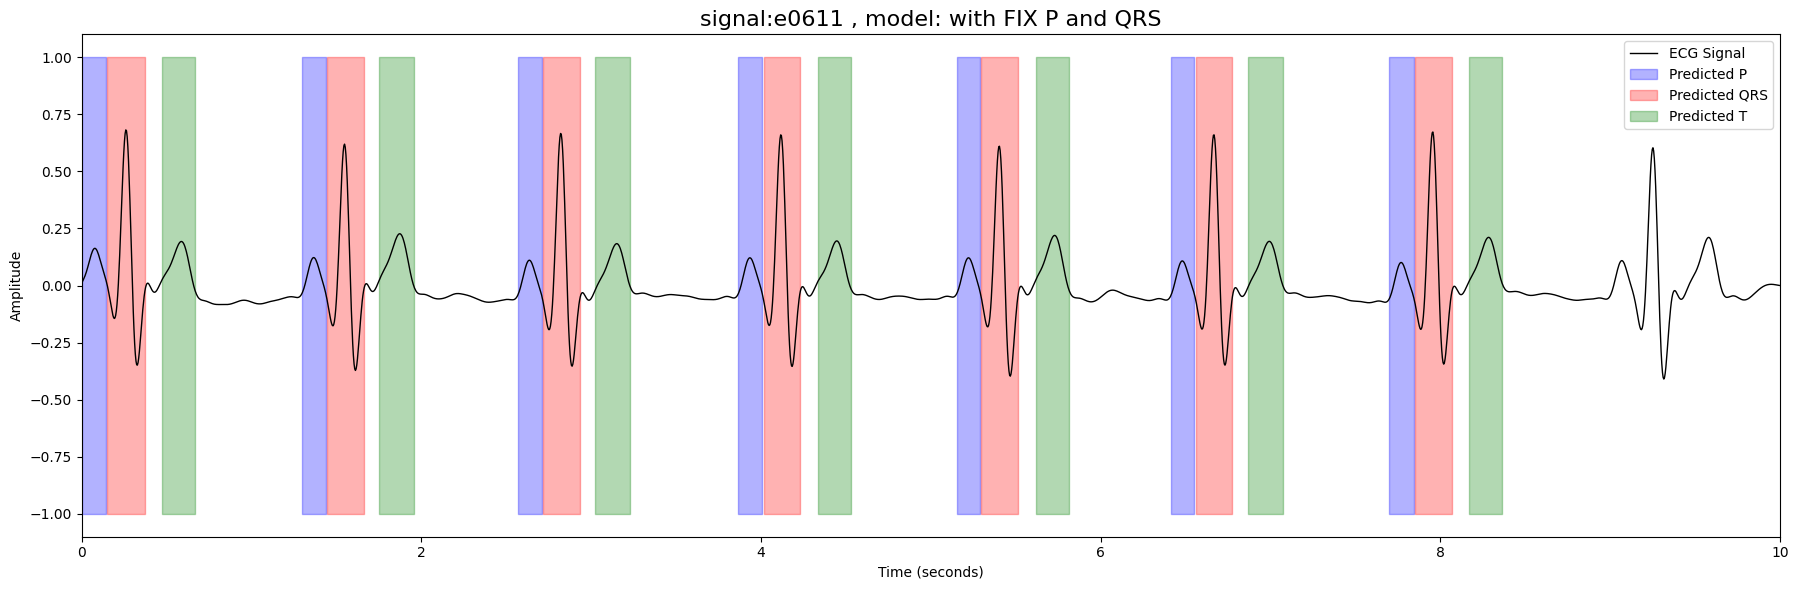

------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------
/content/physionet.org/files/edb/1.0.0/e0122


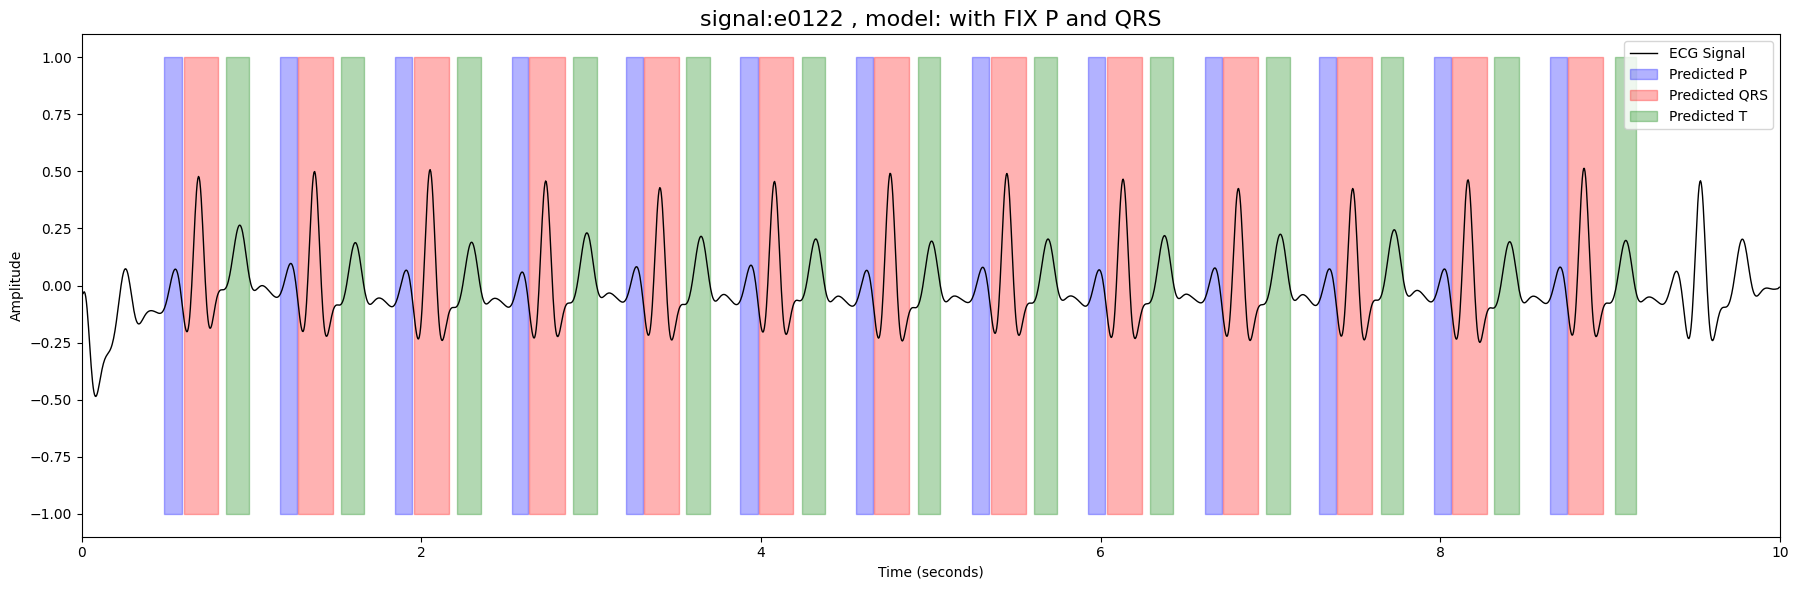

------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------
/content/physionet.org/files/edb/1.0.0/e0410


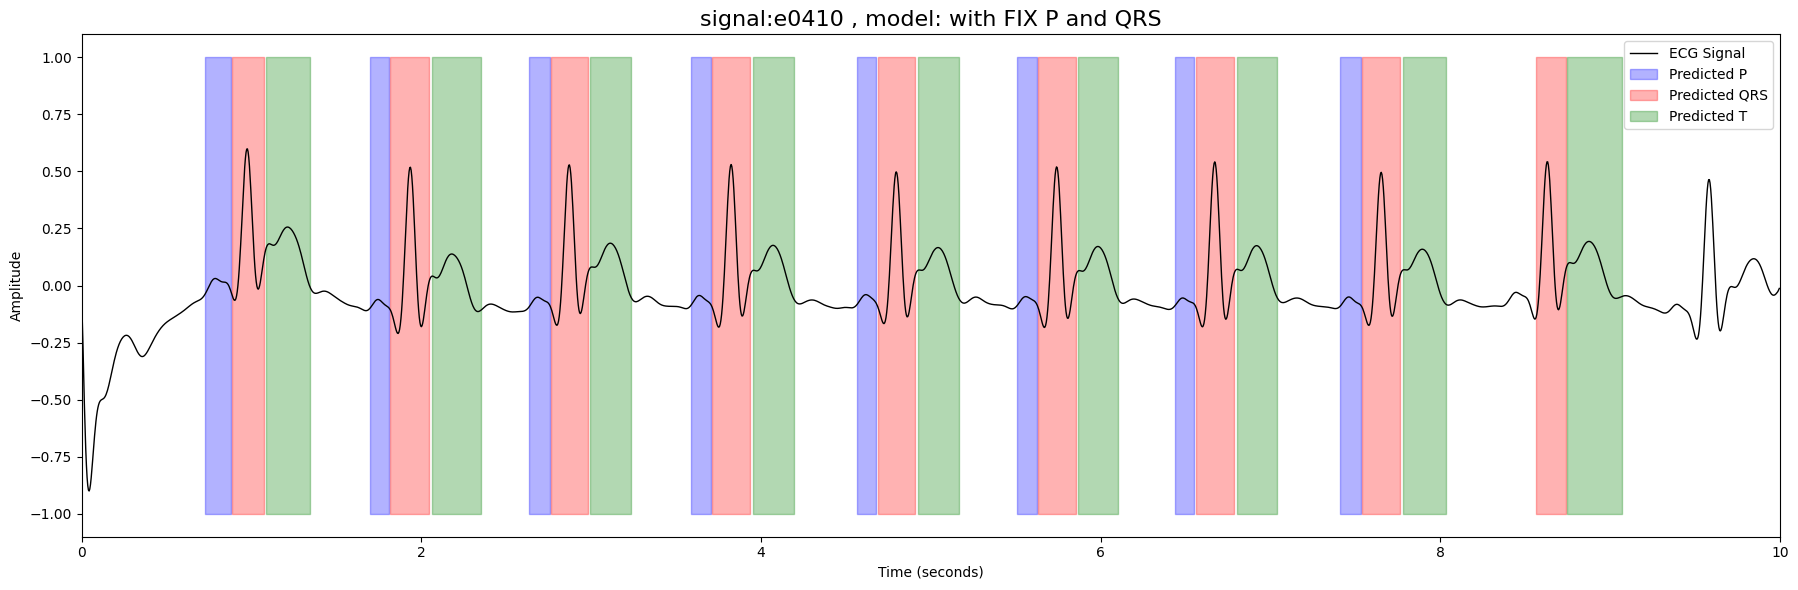

------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------
/content/physionet.org/files/edb/1.0.0/e0105


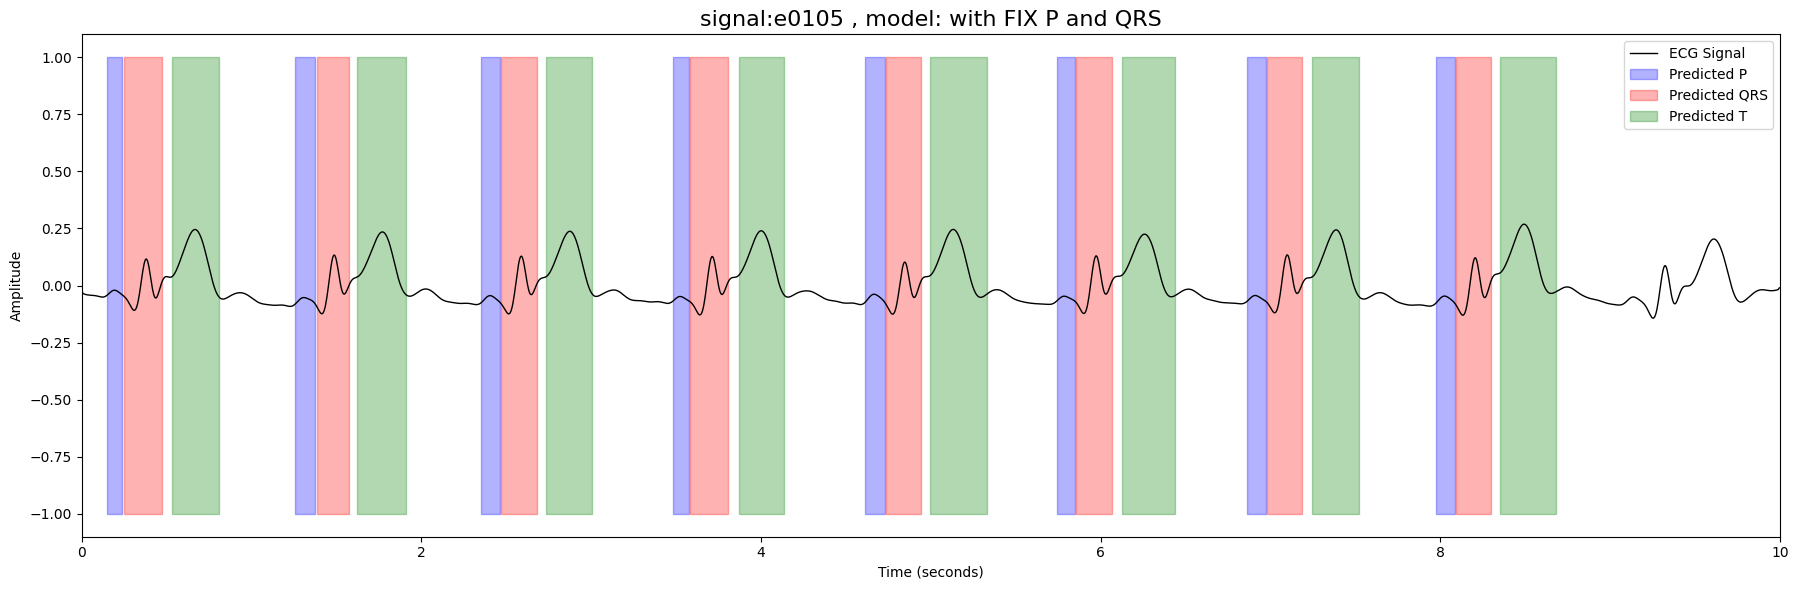

------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------
/content/physionet.org/files/edb/1.0.0/e0166


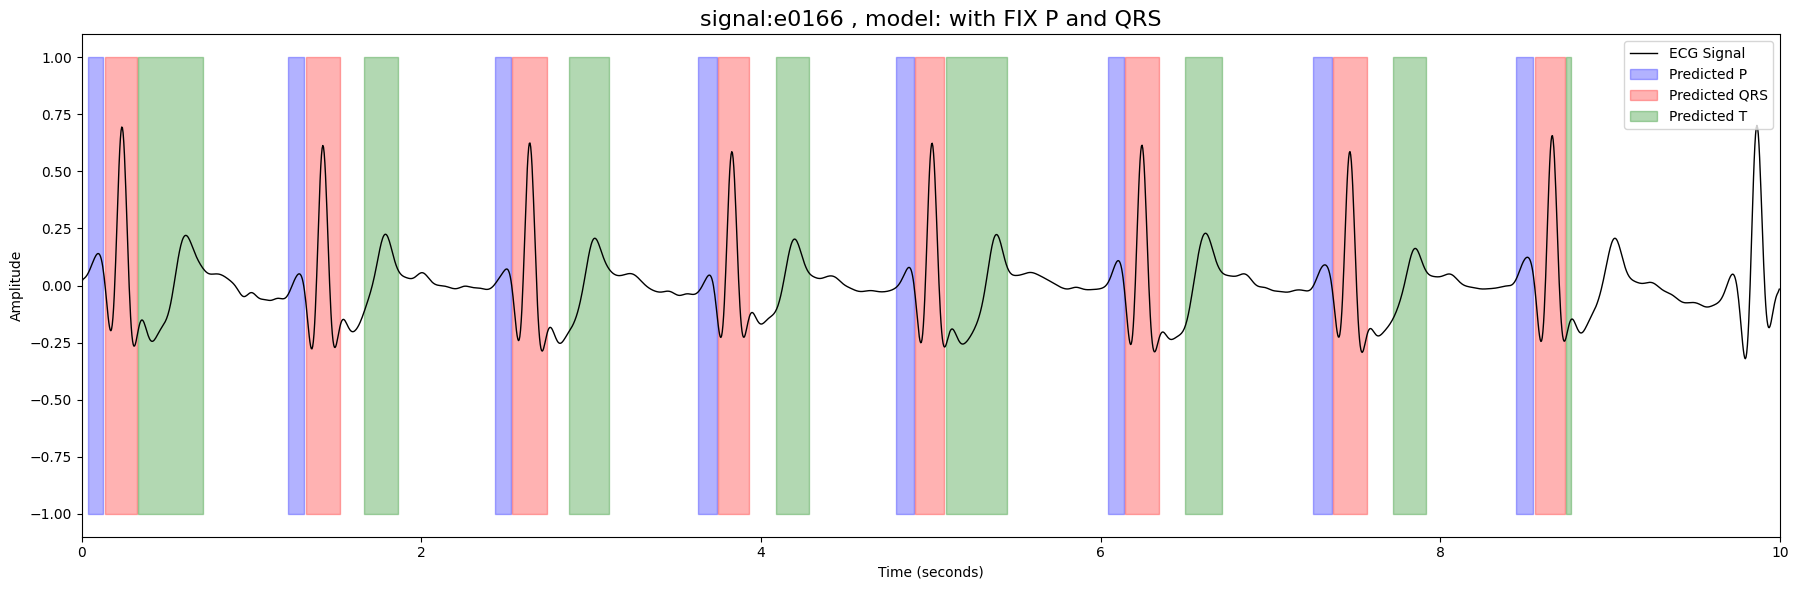

------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------


In [20]:

for record_path in edb_records[20:40]:
#if(True):
#    record_path = "sel232"
    try:

        print(edb_path+record_path)
        record = wfdb.rdrecord(edb_path+record_path)
        signal = record.p_signal[:, 0]  # lead I
        fs = record.fs
        signal=signal[(10*fs):(20*fs)]
        if fs != 250:
          signal = resample_signal(signal, original_fs=fs, target_fs=250)
          fs = 250
        pred_labels,_,_ = predict_full_ecg(signal, model_deep, fs=250)


        # Predict
        # Extract wave start/end
        boundaries = get_wave_boundaries(pred_labels)
        #print("predicted:", pred_labels)
        #print("boundaries:", boundaries)
        #print(boundaries)
        signal = smooth_signal(bandpass_filter(signal, fs=fs))
        #visualize_boundaries(signal, boundaries,signal_name=record_path, model_name="without preprocess", fs=250, zoom=(0, 10))


        pred_labels = post_process_ecg(pred_labels,)
        # Predict
        # Extract wave start/end
        boundaries = get_wave_boundaries(pred_labels)
        #print("predicted:", pred_labels)
        #print("boundaries:", boundaries)
        #print(boundaries)
        #visualize_boundaries(signal, boundaries,signal_name=record_path, model_name="with preprocess", fs=250, zoom=(0, 10))

        pred_labels = fix_P(signal,pred_labels)
        pred_labels = fix_QRS(signal,mask=pred_labels,fs=fs)
        boundaries = get_wave_boundaries(pred_labels)
        visualize_boundaries(signal, boundaries,signal_name=record_path, model_name="with FIX P and QRS", fs=250, zoom=(0, 10))


        print(120*"-")
        print(120*"-")



    except:
        print(f"Skipping {record_path} due to error.")

/content/physionet.org/files/mitdb/1.0.0/107


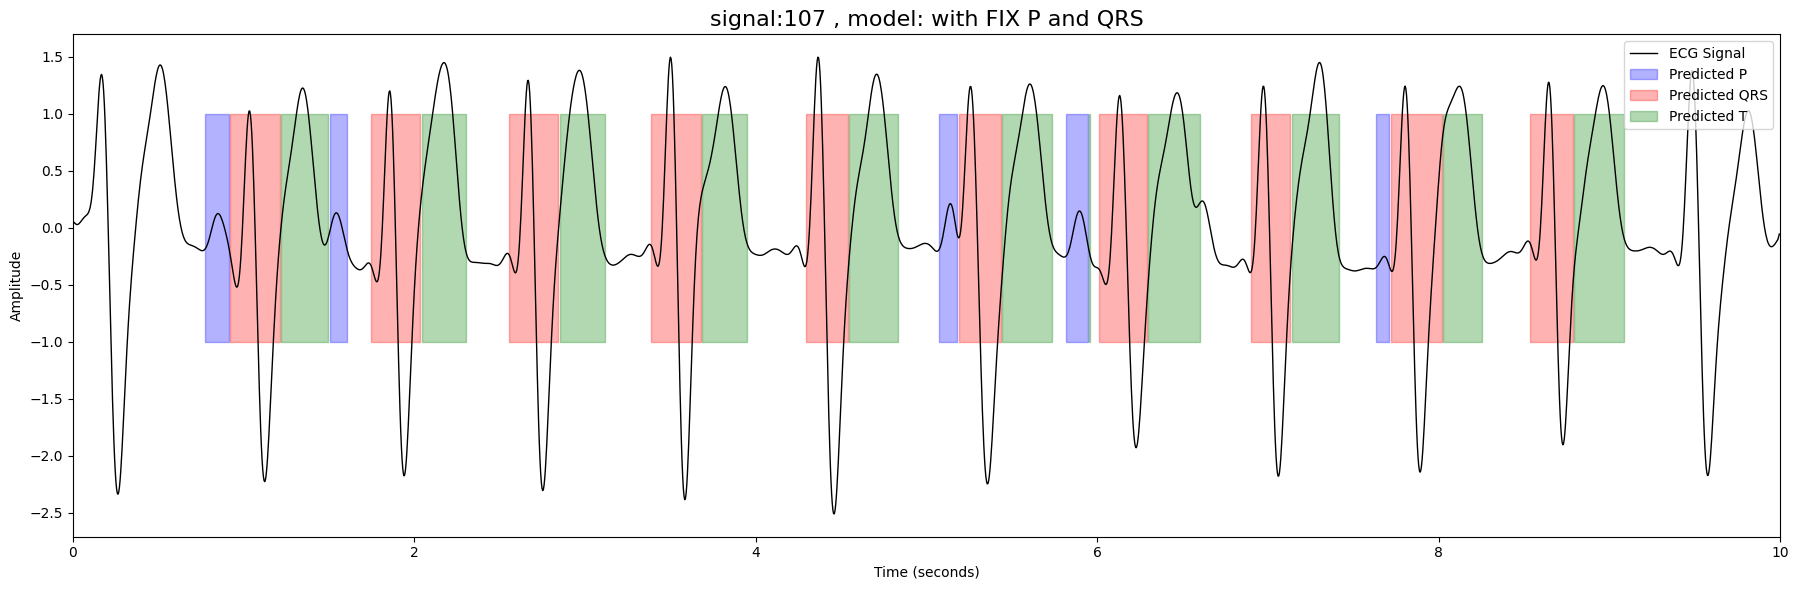

------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------
/content/physionet.org/files/mitdb/1.0.0/109


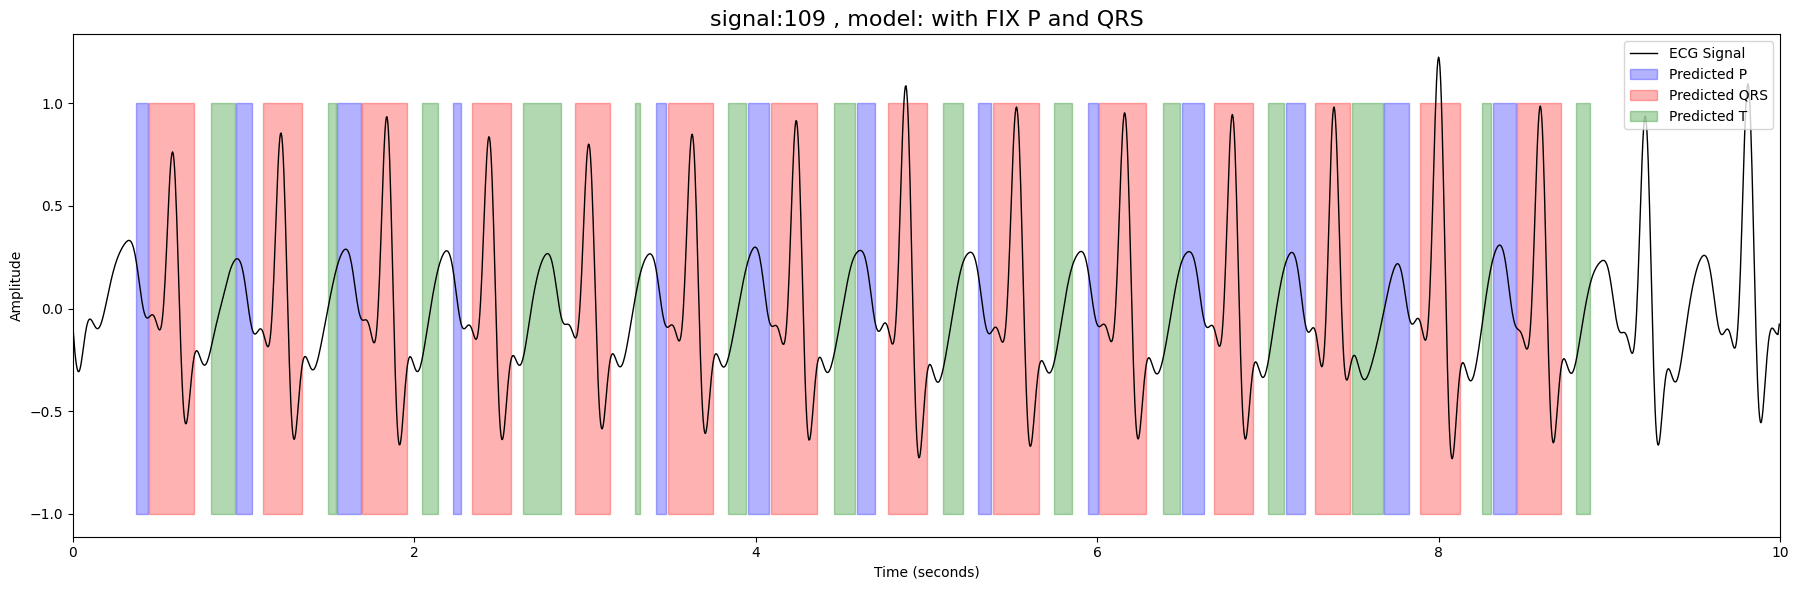

------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------
/content/physionet.org/files/mitdb/1.0.0/117


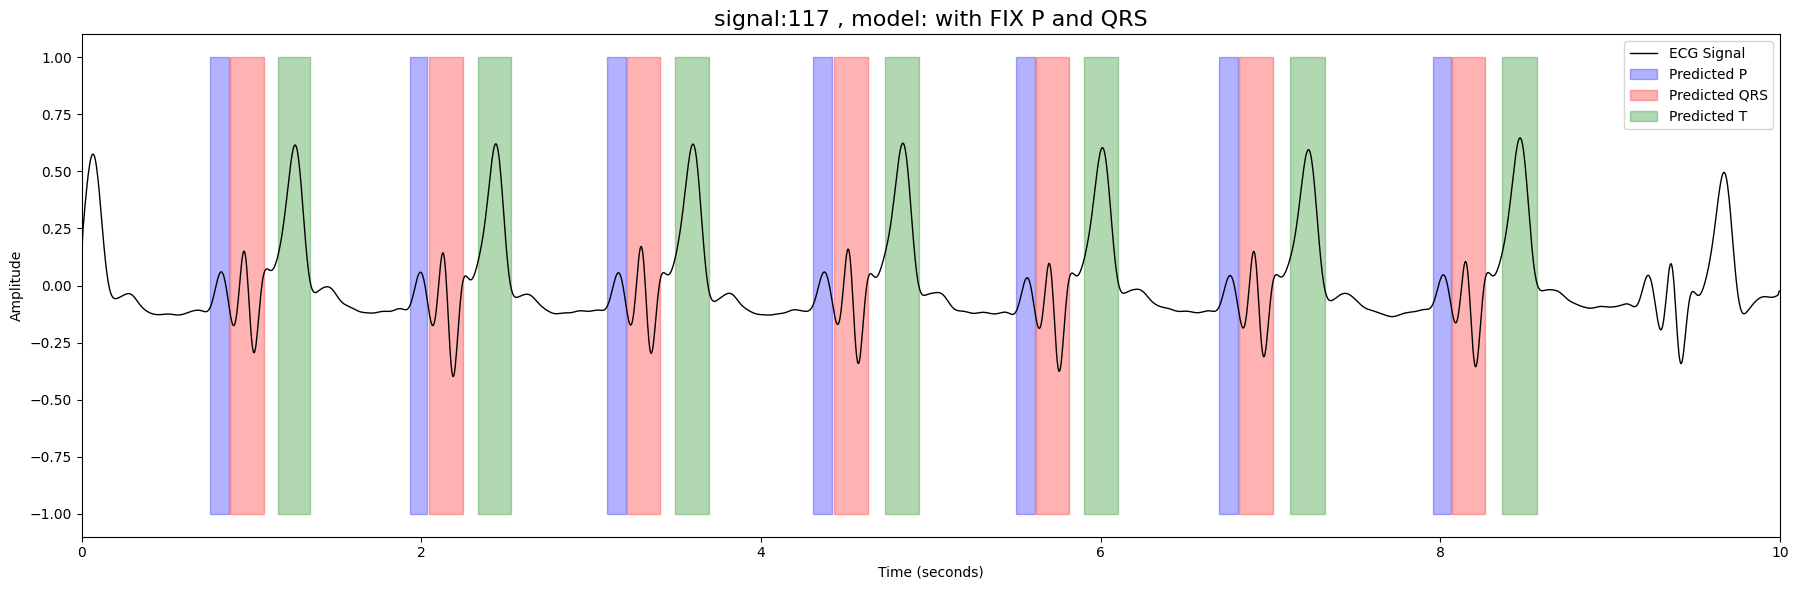

------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------
/content/physionet.org/files/mitdb/1.0.0/106


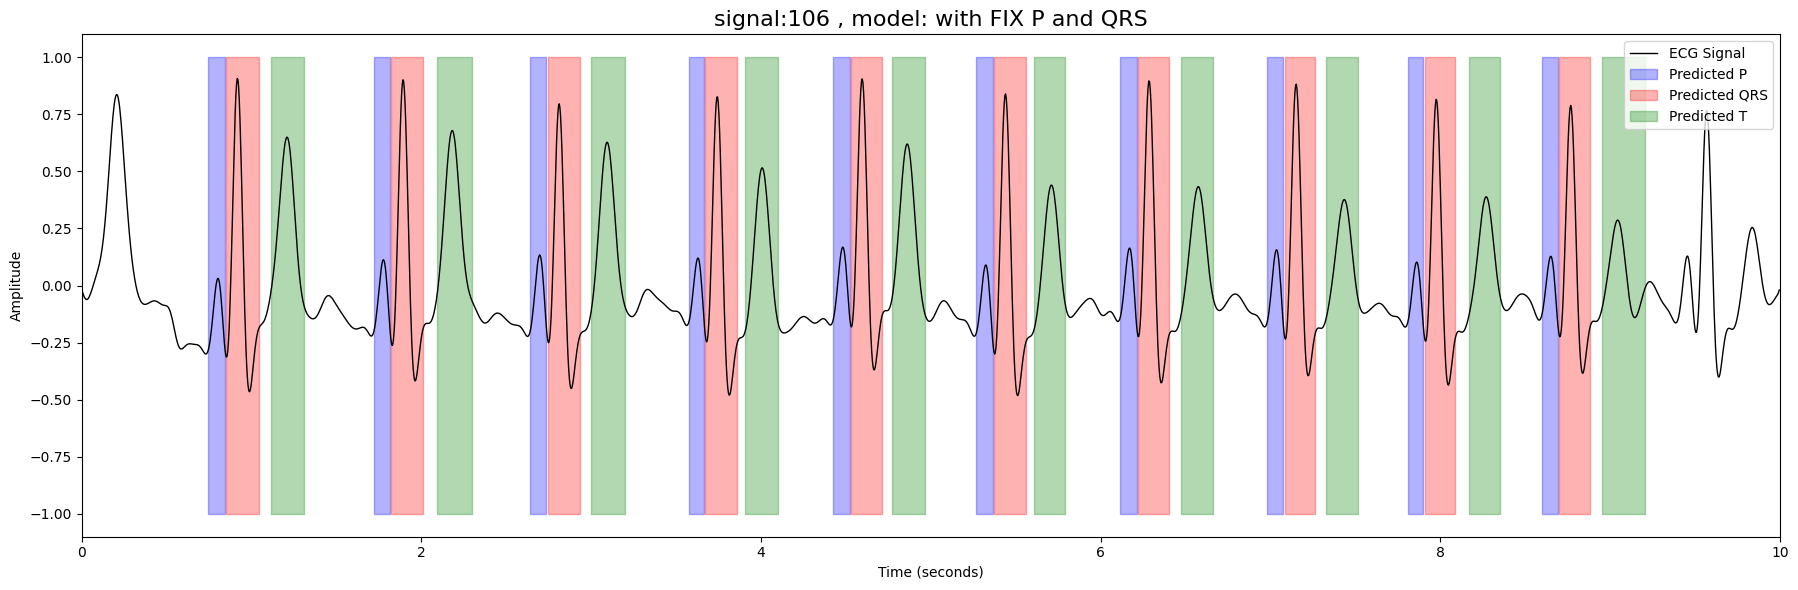

------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------
/content/physionet.org/files/mitdb/1.0.0/207


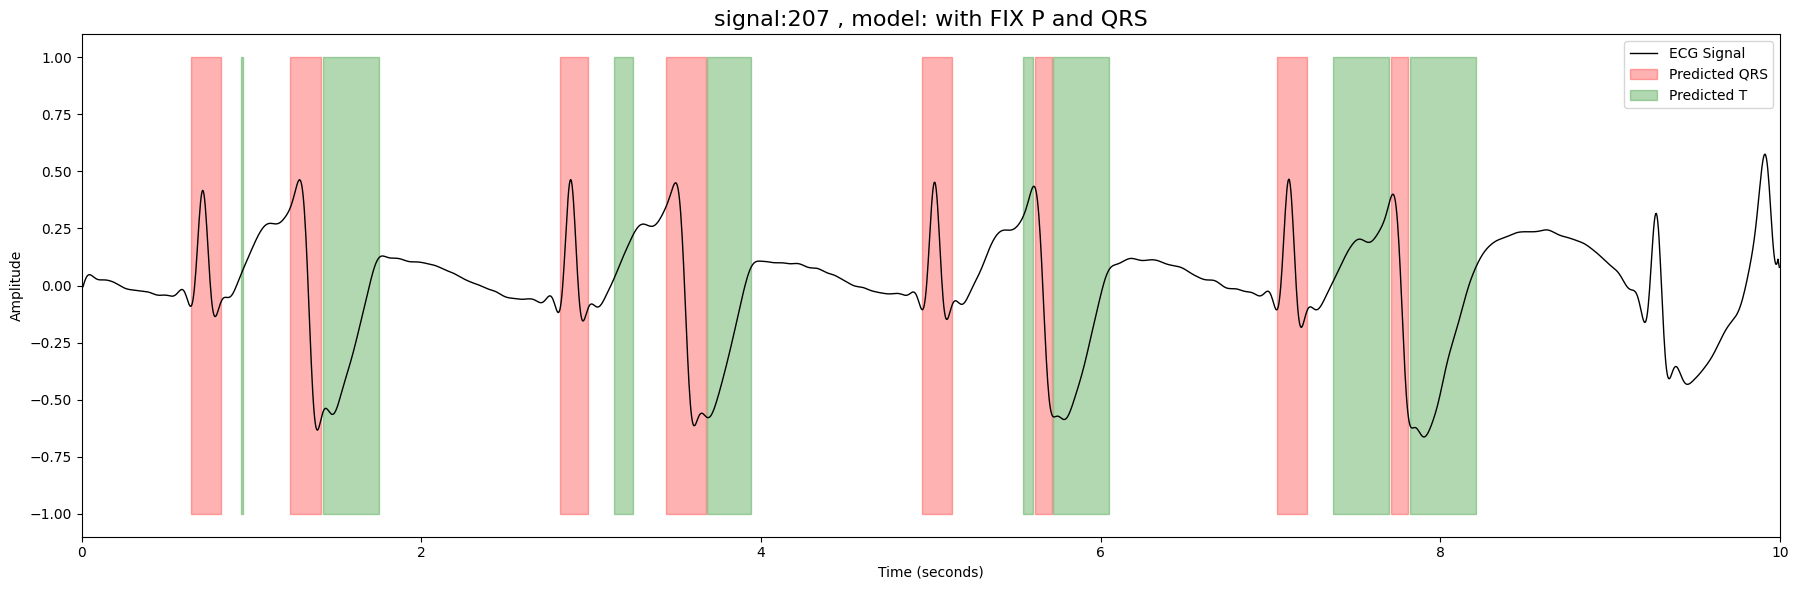

------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------
/content/physionet.org/files/mitdb/1.0.0/112


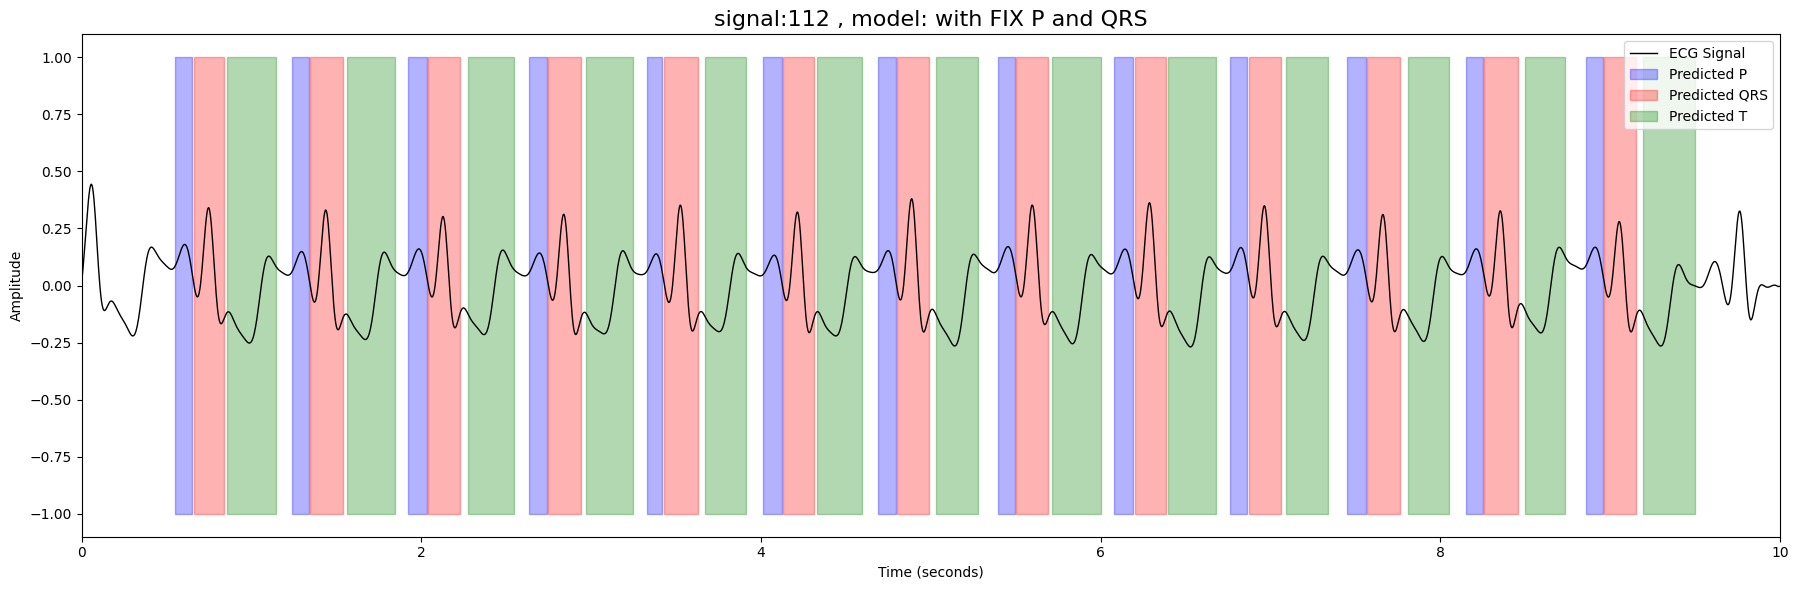

------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------
/content/physionet.org/files/mitdb/1.0.0/124


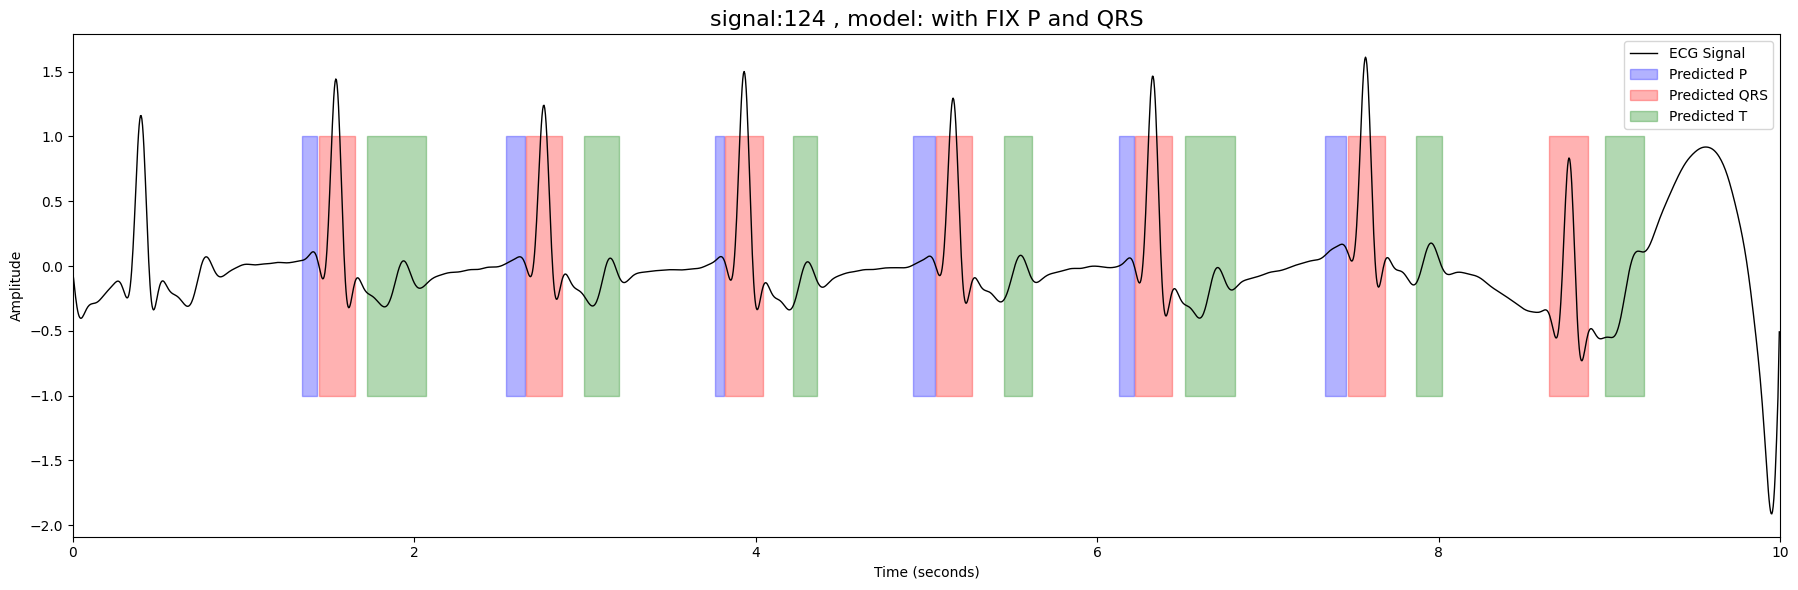

------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------
/content/physionet.org/files/mitdb/1.0.0/209


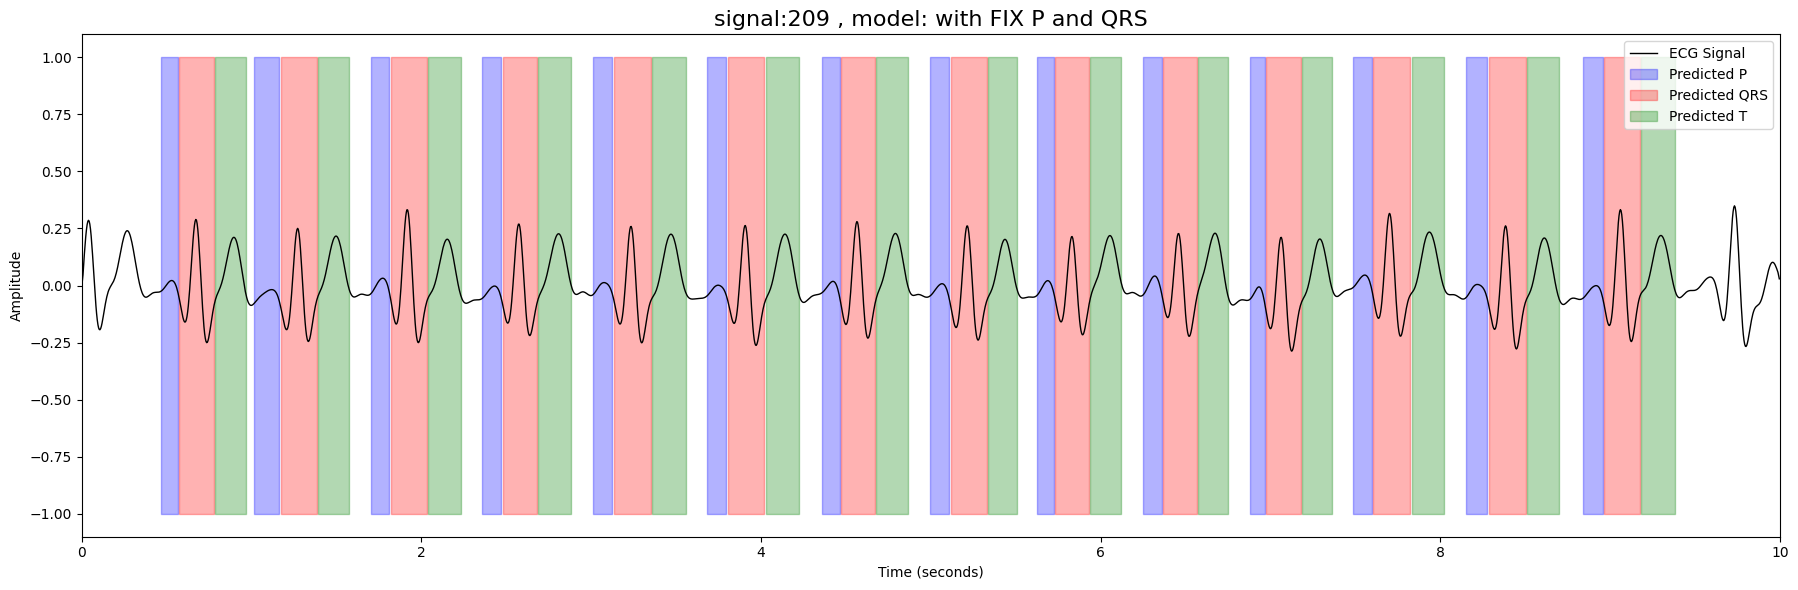

------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------
/content/physionet.org/files/mitdb/1.0.0/202


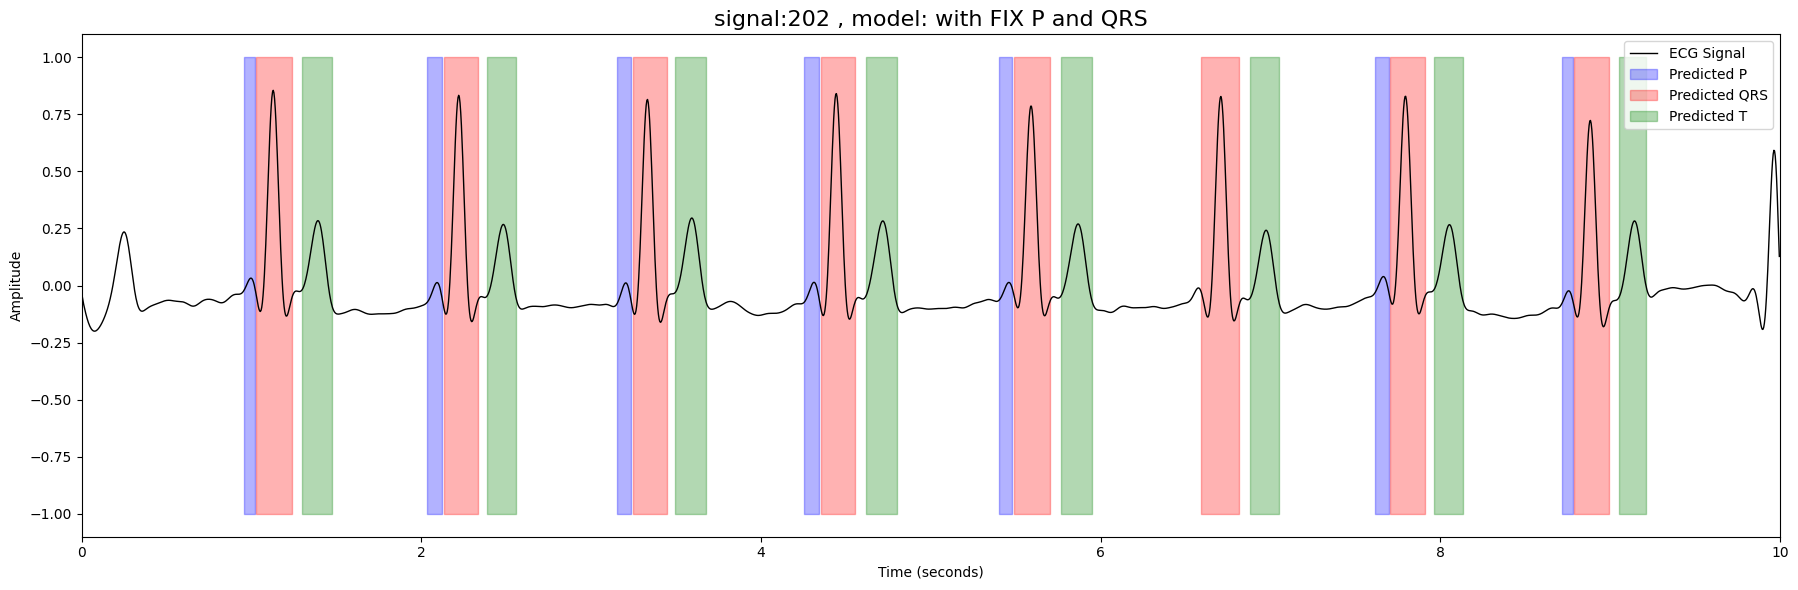

------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------
/content/physionet.org/files/mitdb/1.0.0/114


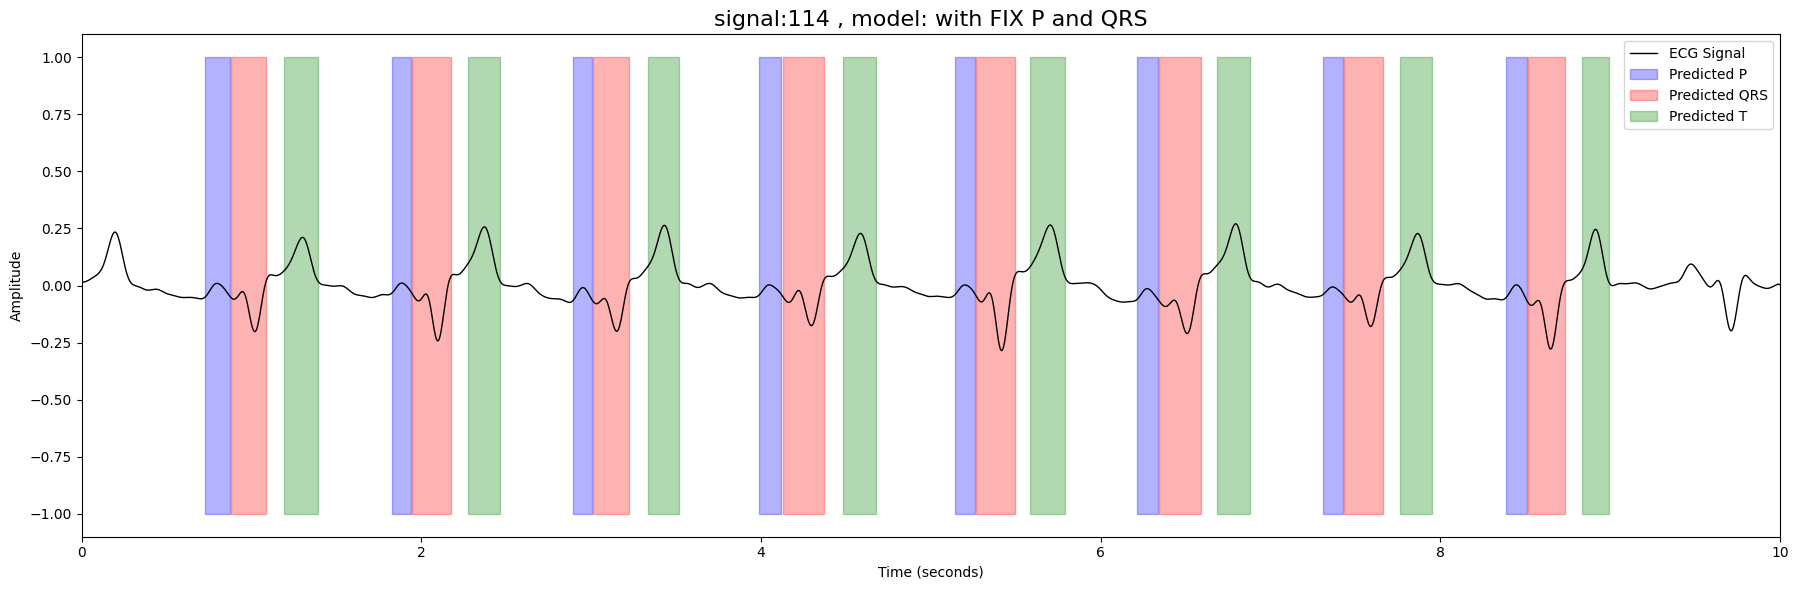

------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------
/content/physionet.org/files/mitdb/1.0.0/205


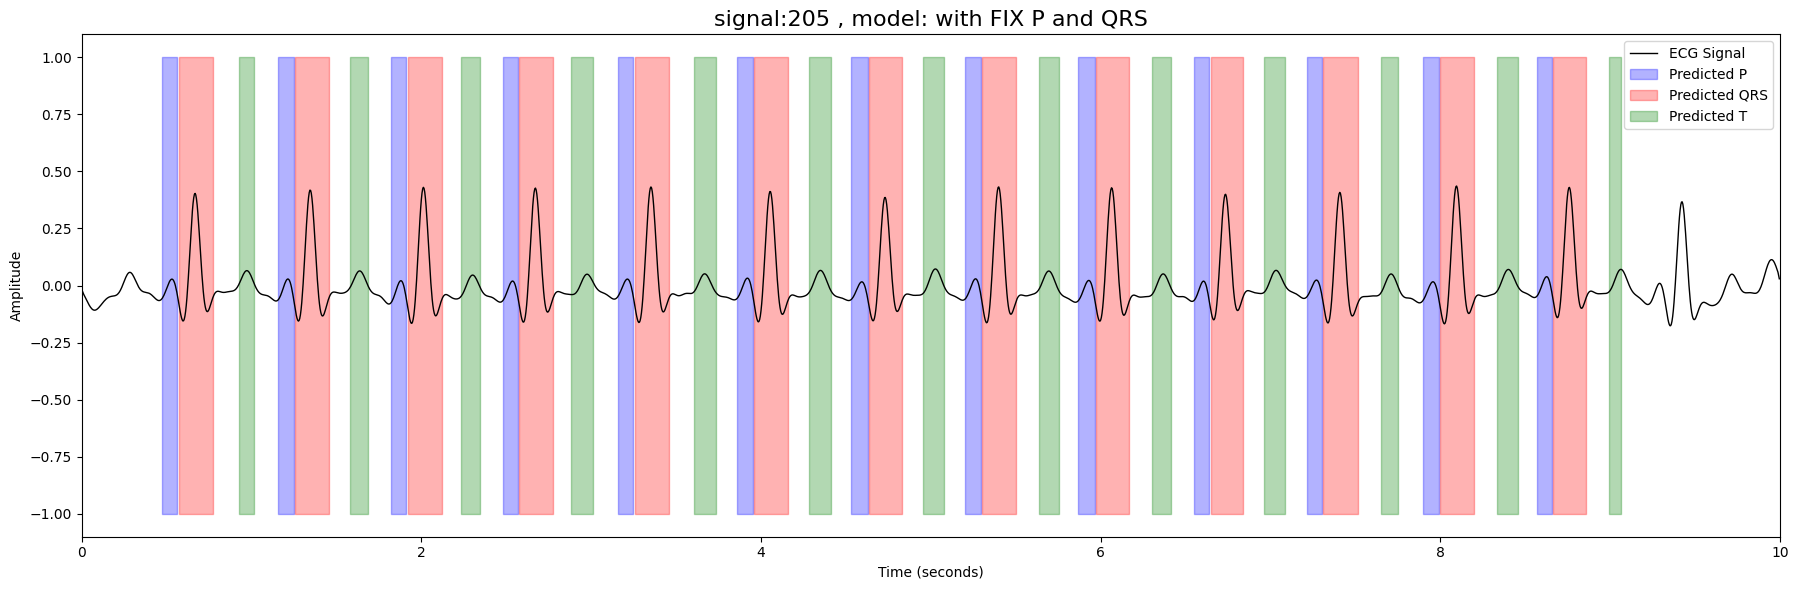

------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------
/content/physionet.org/files/mitdb/1.0.0/203


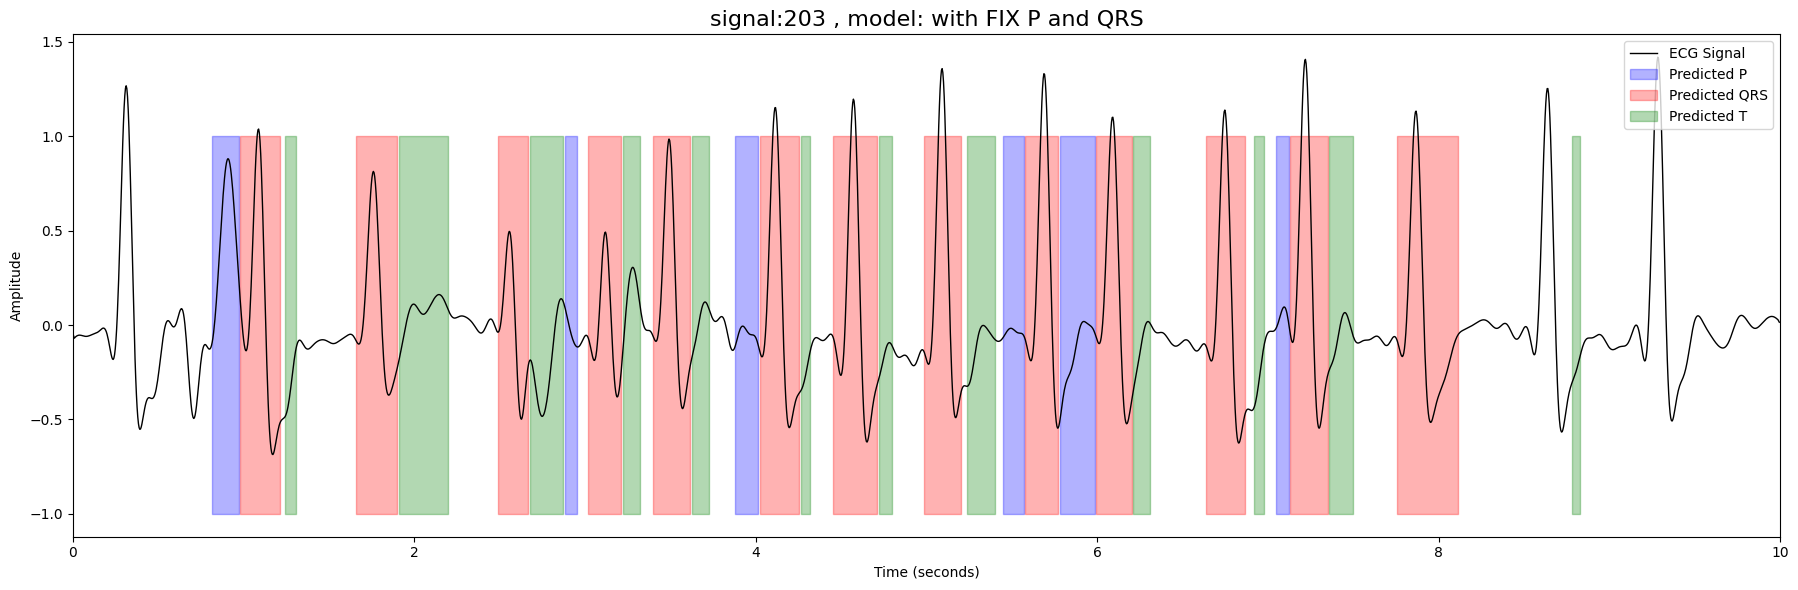

------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------
/content/physionet.org/files/mitdb/1.0.0/228


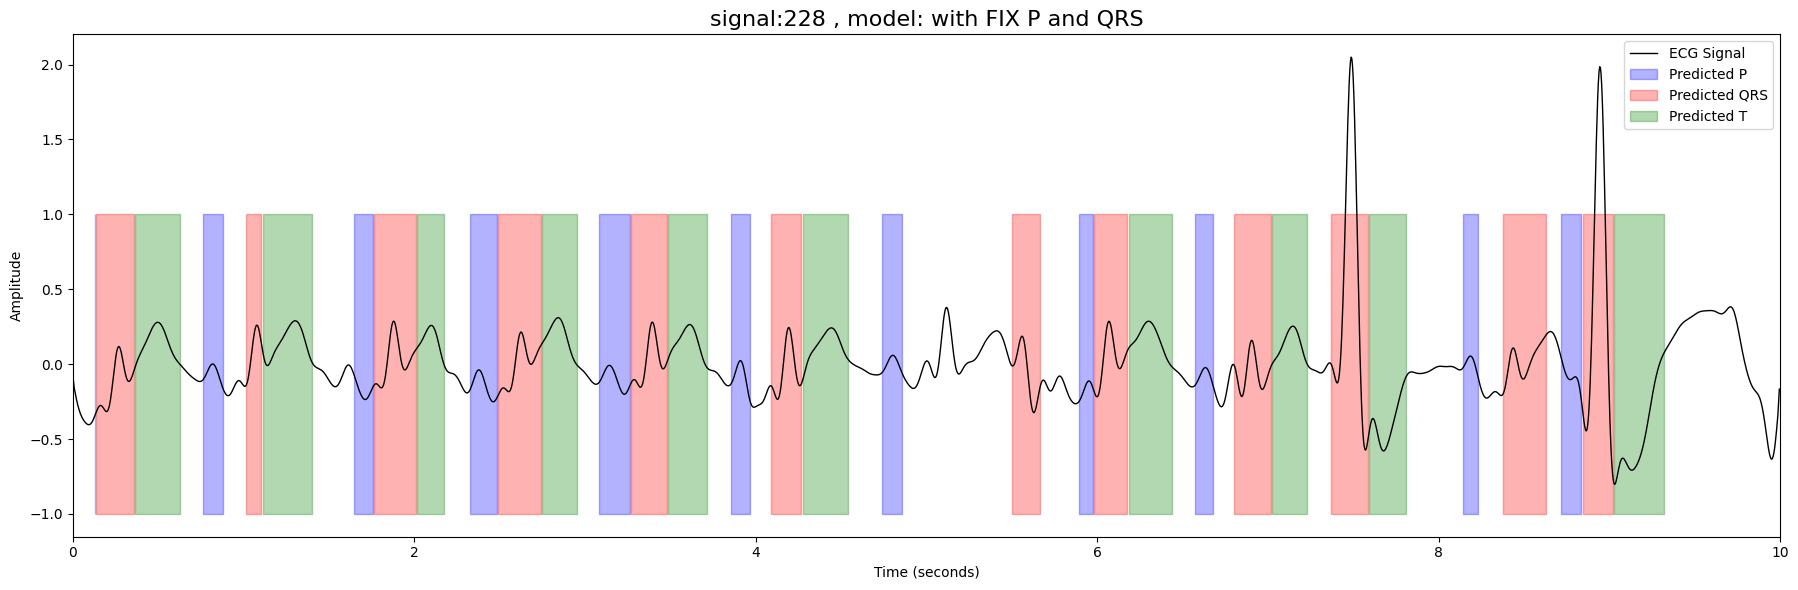

------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------
/content/physionet.org/files/mitdb/1.0.0/102


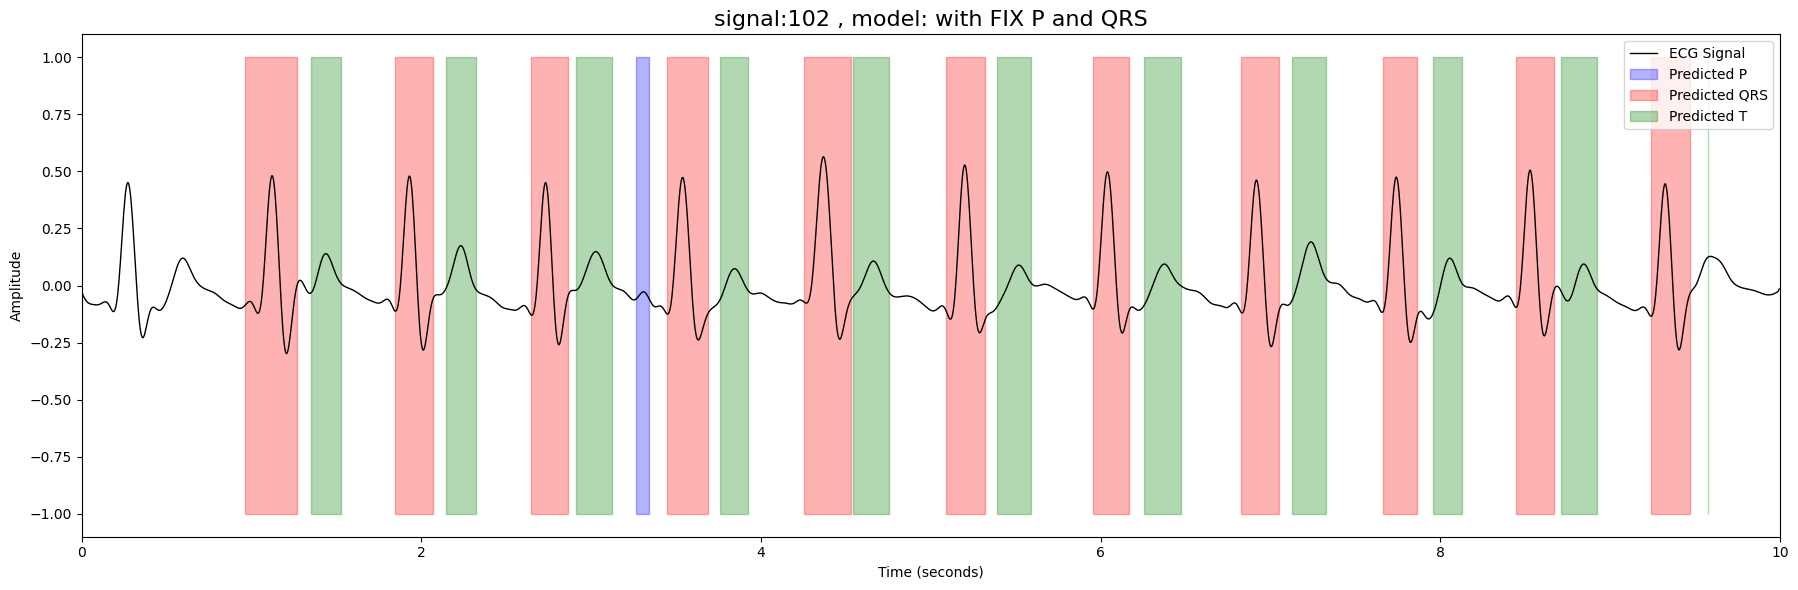

------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------
/content/physionet.org/files/mitdb/1.0.0/100


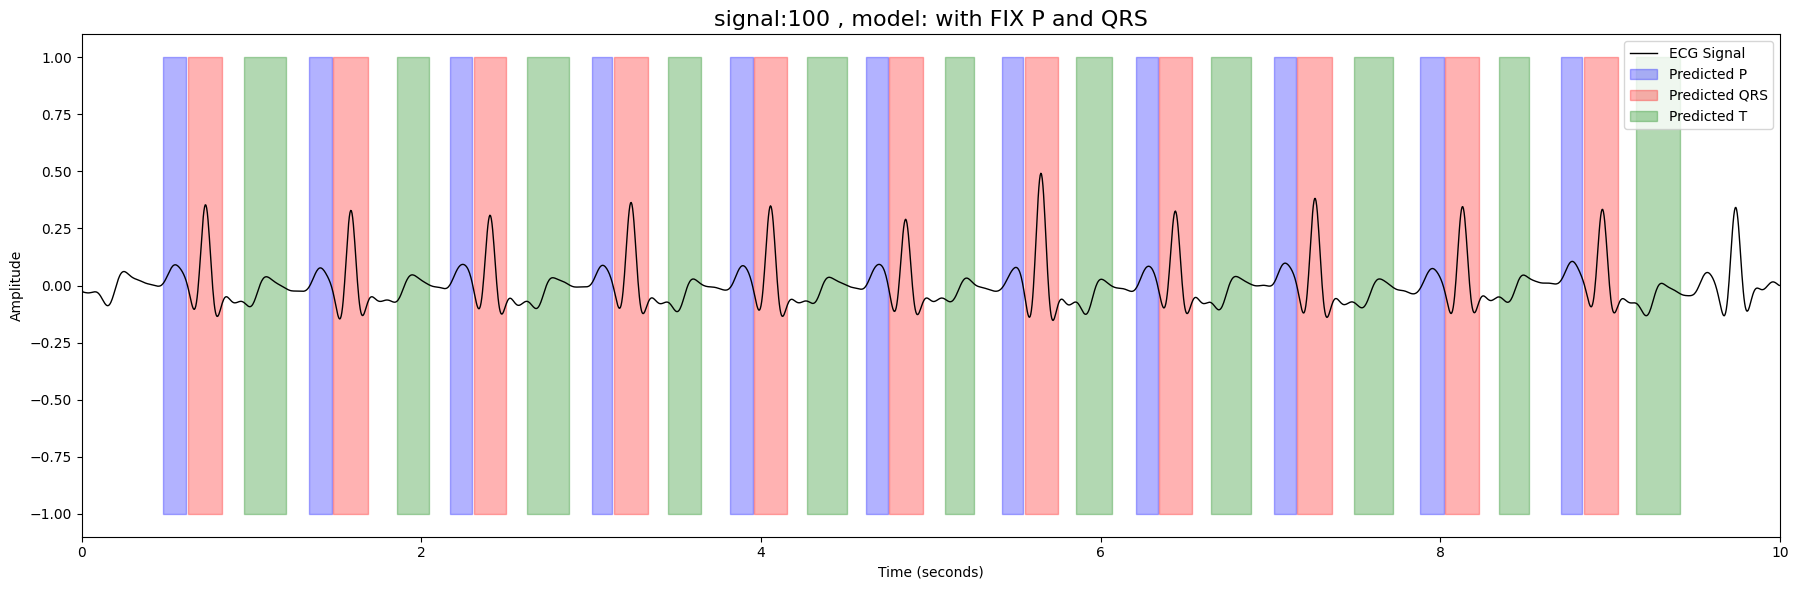

------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------
/content/physionet.org/files/mitdb/1.0.0/231


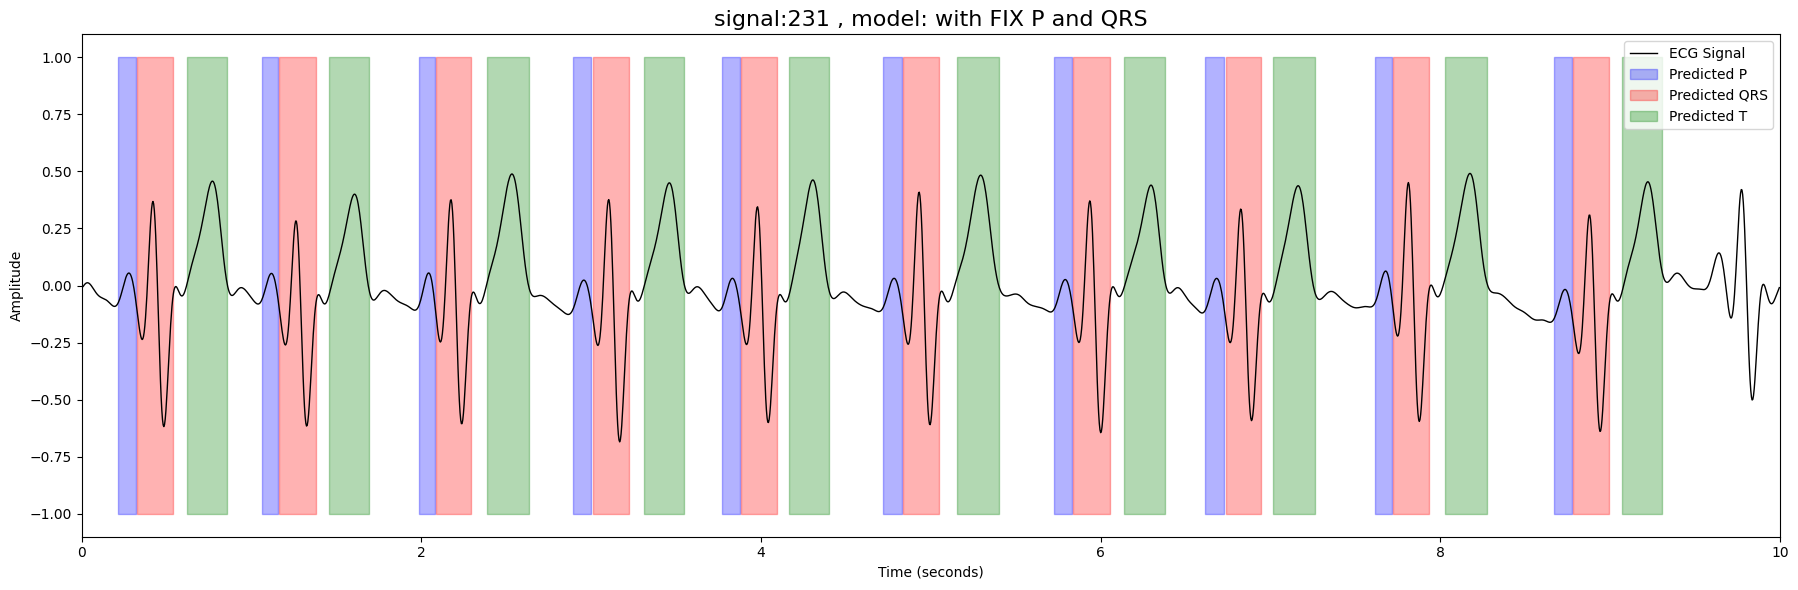

------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------
/content/physionet.org/files/mitdb/1.0.0/208


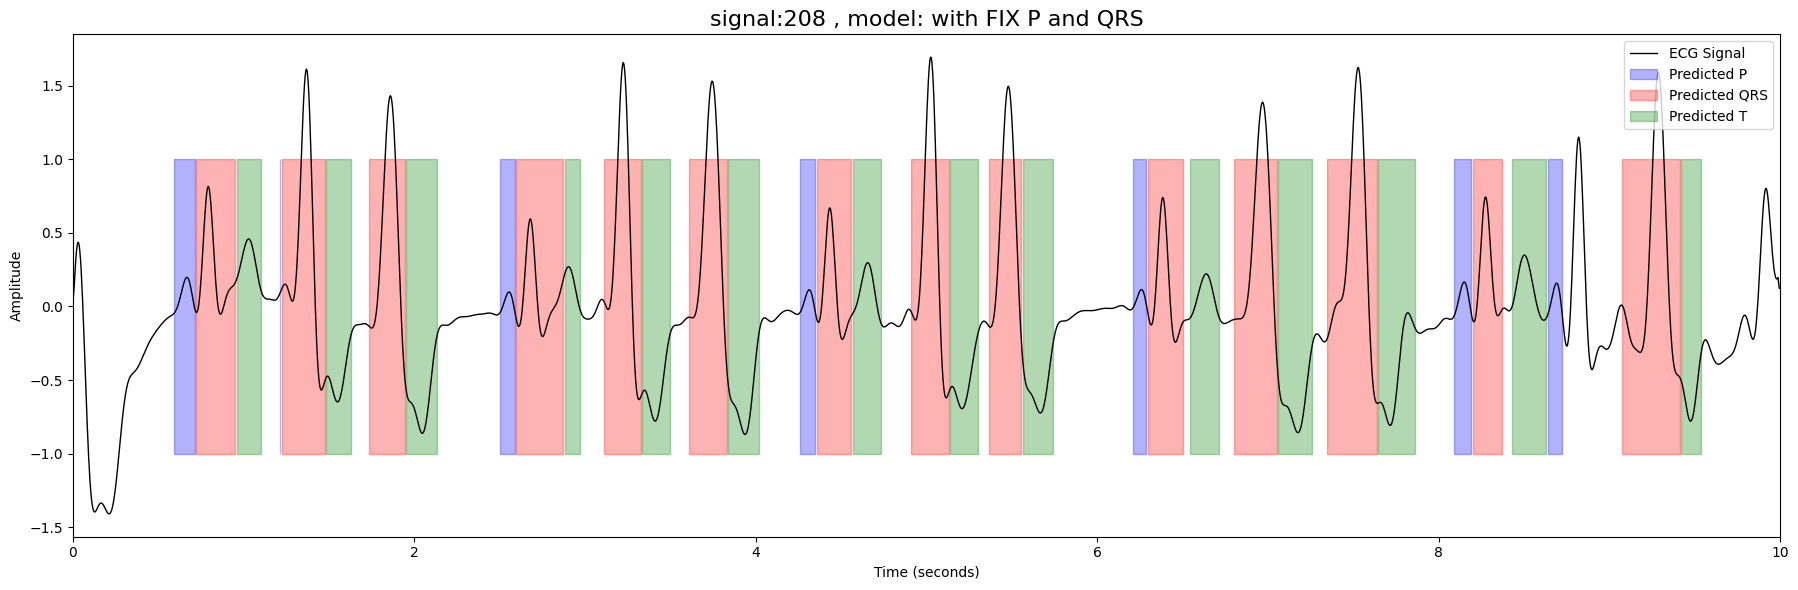

------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------
/content/physionet.org/files/mitdb/1.0.0/200


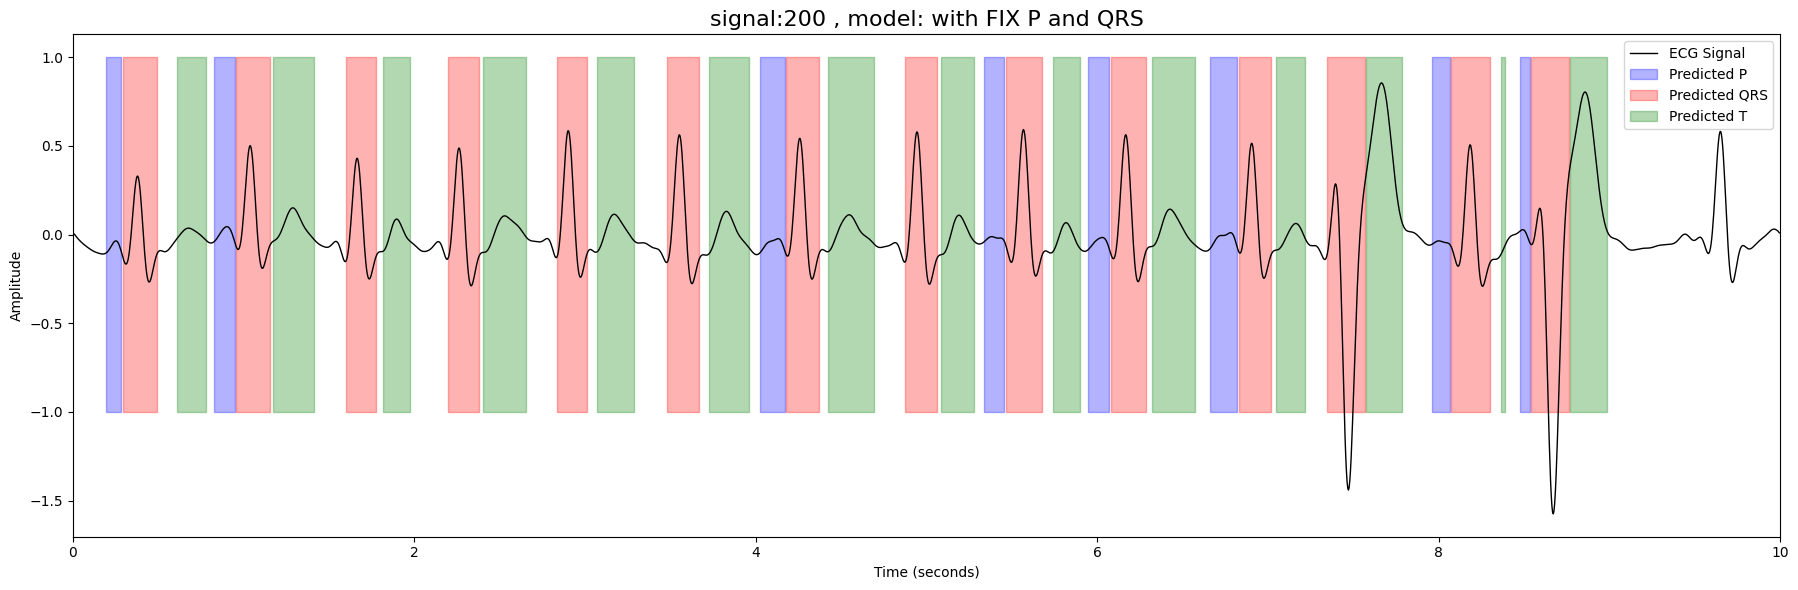

------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------
/content/physionet.org/files/mitdb/1.0.0/108


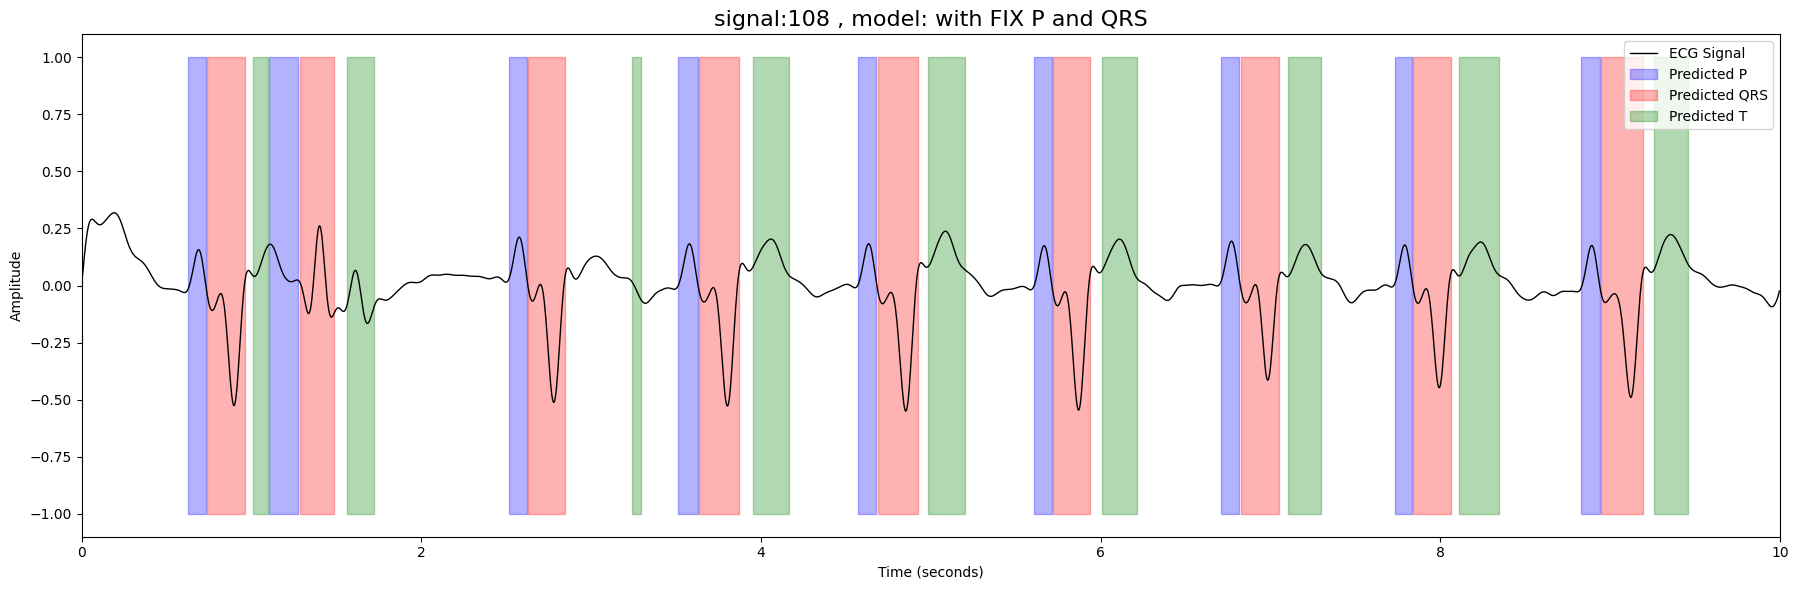

------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------
/content/physionet.org/files/mitdb/1.0.0/105


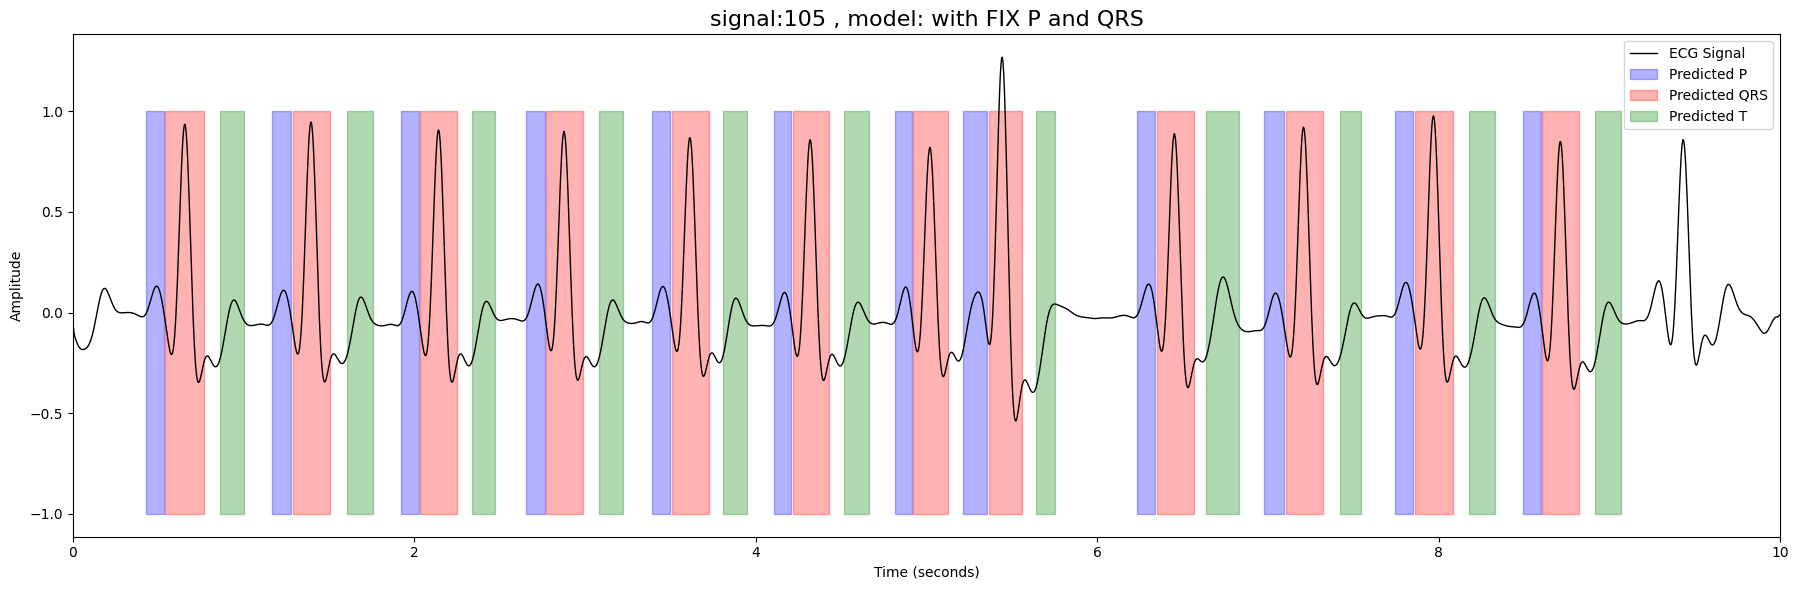

------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------


In [19]:

for record_path in mit_records[20:40]:
#if(True):
#    record_path = "sel232"
    #try:

        print(mitdb_path+record_path)
        record = wfdb.rdrecord(mitdb_path+record_path)
        signal = record.p_signal[:, 0]  # lead I
        fs = record.fs
        signal=signal[(10*fs):(20*fs)]
        if fs != 250:
          signal = resample_signal(signal, original_fs=fs, target_fs=250)
          fs = 250
        pred_labels,_,_ = predict_full_ecg(signal, model_deep, fs=250)


        # Predict
        # Extract wave start/end
        boundaries = get_wave_boundaries(pred_labels)
        #print("predicted:", pred_labels)
        #print("boundaries:", boundaries)
        #print(boundaries)
        signal = smooth_signal(bandpass_filter(signal, fs=fs))
        #visualize_boundaries(signal, boundaries,signal_name=record_path, model_name="without preprocess", fs=250, zoom=(0, 10))


        pred_labels = post_process_ecg(pred_labels,)
        # Predict
        # Extract wave start/end

        boundaries = get_wave_boundaries(pred_labels)
        #print("predicted:", pred_labels)
        #print("boundaries:", boundaries)
        #print(boundaries)
        #visualize_boundaries(signal, boundaries,signal_name=record_path, model_name="with preprocess", fs=250, zoom=(0, 10))

        pred_labels = fix_P(signal,pred_labels)
        pred_labels = fix_QRS(signal,mask=pred_labels,fs=fs)
        pred_labels = merge_close_waves(pred_labels)

        boundaries = get_wave_boundaries(pred_labels)
        visualize_boundaries(signal, boundaries,signal_name=record_path, model_name="with FIX P and QRS", fs=250, zoom=(0, 10))


        print(120*"-")
        print(120*"-")



    #except:
        #print(f"Skipping {record_path} due to error.")

# Features extraction

## extract features functions

In [32]:
import numpy as np
from scipy.stats import skew, kurtosis, entropy

def extract_features_per_qrs(signal, mask, fs=250):
    features_list = []
    time = np.arange(len(signal)) / fs

    # Find all QRS starts
    qrs_mask = (mask == 2).astype(int)
    transitions = np.diff(qrs_mask, prepend=0)
    qrs_starts = np.where(transitions == 1)[0]
    previous_r_index = None  # To calculate RR interval

    for i in range(len( qrs_starts)):

        p_wave = np.array([])
        qrs_wave = np.array([])
        t_wave = np.array([])
        p_indices = np.array([])
        t_indices = np.array([])


        qrs_start = qrs_starts[i]
        next_qrs_start = qrs_starts[i+1] if i < len(qrs_starts) - 1 else len(mask)

        # Get current QRS region
        qrs_indices = np.where((mask == 2) & (np.arange(len(mask)) >= qrs_start) & (np.arange(len(mask)) < next_qrs_start))[0]
        #print("qrs_indices:",qrs_indices)
        if len(qrs_indices) == 0:
            continue
        qrs_end = qrs_indices[-1]
        #print("qrs_start,end:",qrs_start,qrs_end)

        # Search for the P wave just before this QRS (no QRS or T in between)
        p_indices = np.where(mask[:qrs_start] == 1)[0]
        valid_p = []
        for p_end in reversed(p_indices):
            if np.all(mask[p_end:qrs_start] != 2) and np.all(mask[p_end:qrs_start] != 3):
                p_start = p_end
                while p_start > 0 and mask[p_start - 1] == 1:
                    p_start -= 1
                valid_p = list(range(p_start, p_end + 1))
                break

        #print("p start,end:",valid_p[0],valid_p[-1])

        #
        # Search for the T wave just after this QRS (no QRS or P in between)

        t_indices = np.where(mask[qrs_end:next_qrs_start] == 3)[0]
        t_indices = t_indices + (qrs_end )
        #print("t_indices:",t_indices)

        valid_t = []
        for t_start_offset in t_indices:
            t_start = t_start_offset
            #print("mask[qrs_end:t_start]:",mask[qrs_end:t_start])
            if np.all(mask[qrs_end+1:t_start] != 2) and np.all(mask[qrs_end+1:t_start] != 1):
                #print("got t")
                t_end = t_start
                while t_end < len(mask) - 1 and mask[t_end + 1] == 3:
                    t_end += 1
                valid_t = list(range(t_start, t_end + 1))
                break
        # Extract samples
        p_wave = signal[valid_p] if valid_p else np.array([])
        qrs_wave = signal[qrs_indices]
        t_wave = signal[valid_t] if valid_t else np.array([])
        p_indices = valid_p if valid_p else np.array([])
        t_indices = valid_t if valid_t else np.array([])
        #print("p_wave,qrs_wave,t_wave:",len(p_wave),len(qrs_wave),len(t_wave))
        #print("p_indices,t_indices:",len(p_indices),len(t_indices))

        # Build features per beat
        f = {}
        padding = 0
        if len(p_wave)>0:
          f['start'] = p_indices[0]-padding if p_indices[0] > padding else 0
        else :
          f['start'] = qrs_indices[0]-padding if qrs_indices[0] > padding else 0

        if len(t_wave)>0:
          f['end'] = t_indices[-1]+padding if t_indices[-1] < len(signal)-padding else len(signal)
        else :
          f['end'] = qrs_indices[-1]+padding if qrs_indices[-1] < len(signal)-padding else len(signal)



        f['Duree_P_ms'] = len(p_wave) / fs * 1000 if len(p_wave) > 0 else 0
        f['Duree_QRS_ms'] = len(qrs_wave) / fs * 1000 if len(qrs_wave) > 0 else 0
        f['Duree_T_ms'] = len(t_wave) / fs * 1000 if len(t_wave) > 0 else 0

        f['Intervalle_PR_ms'] = ((qrs_start - valid_p[0]) / fs * 1000) if valid_p else 0
        f['Intervalle_QT_ms'] = ((valid_t[-1] - qrs_start) / fs * 1000) if valid_t else 0
        f['Intervalle_ST_ms'] = ((valid_t[0] - qrs_end) / fs * 1000) if valid_t else 0


        # Amplitude_P
        if len(p_wave) > 0:
          default_start = (p_wave[0]+p_wave[-1])/2 if len(p_wave) > 0 else 0
          print(default_start)
          p_index = p_indices[np.argmax(np.abs(signal[p_indices]-default_start))]
          p_amplitude = signal[p_index]
          f['P_index']= p_index
          f['Amplitude_P'] = p_amplitude
        else:
          f['P_index']= 0
          f['Amplitude_P'] = 0

        # Amplitude_R
        default_start = p_wave[0] if len(p_wave) > 0 else signal[qrs_start]
        r_index = qrs_indices[np.argmax(np.abs(signal[qrs_indices]-default_start))]
        r_amplitude = signal[r_index]

        f['R_index']= r_index
        f['Amplitude_R'] = r_amplitude
        # RR interval
        if previous_r_index is not None:
            f['Intervalle_RR_ms'] = (r_index - previous_r_index) / fs * 1000
        else:
            f['Intervalle_RR_ms'] = 0  # Or np.nan if you prefer

        # Update previous_r_index for next beat
        previous_r_index = r_index

        # --- Detect Q and S waves relative to R ---
        q_index, s_index = None, None
        q_amplitude, s_amplitude = None, None

        if r_amplitude > np.median(signal[qrs_indices]):  # R is a max peak
            q_candidates = qrs_indices[qrs_indices < r_index]
            s_candidates = qrs_indices[qrs_indices > r_index]
            if len(q_candidates) > 0:
                q_index = q_candidates[np.argmin(signal[q_candidates])]
                q_amplitude = signal[q_index]
            if len(s_candidates) > 0:
                s_index = s_candidates[np.argmin(signal[s_candidates])]
                s_amplitude = signal[s_index]
        else:  # R is a min peak
            q_candidates = qrs_indices[qrs_indices < r_index]
            s_candidates = qrs_indices[qrs_indices > r_index]
            if len(q_candidates) > 0:
                q_index = q_candidates[np.argmax(signal[q_candidates])]
                q_amplitude = signal[q_index]
            if len(s_candidates) > 0:
                s_index = s_candidates[np.argmax(signal[s_candidates])]
                s_amplitude = signal[s_index]

        # Add Q and S info
        f['Q_index'] = q_index if q_index is not None else 0
        f['Amplitude_Q'] = q_amplitude if q_amplitude is not None else 0
        f['S_index'] = s_index if s_index is not None else 0
        f['Amplitude_S'] = s_amplitude if s_amplitude is not None else 0


        # Amplitude_T
        if len(t_wave) > 0:
          default_start = (t_wave[0]+t_wave[-1])/2 if len(t_wave) > 0 else 0
          # print(default_start)
          t_index = t_indices[np.argmax(np.abs(signal[t_indices]-default_start))]
          t_amplitude = signal[t_index]
          f['T_index']= t_index
          f['Amplitude_T'] = t_amplitude
        else:
          f['T_index']= 0
          f['Amplitude_T'] = 0

        # Amplitude Ratio
        f['T/R_ratio'] = np.max(np.abs(t_wave)) / np.max(np.abs(qrs_wave)) if len(t_wave) > 0 and len(qrs_wave) > 0 else 0
        f['P/R_ratio'] = np.max(np.abs(p_wave)) / np.max(np.abs(qrs_wave)) if len(p_wave) > 0 and len(qrs_wave) > 0 else 0


        # Pente (slopes)
        f['QRS_area'] = np.trapezoid(np.abs(qrs_wave), dx=1/fs)

        # QR Slope
        if q_index is not None and q_index < r_index:
            delta_qr = (r_amplitude - q_amplitude)
            time_qr = (r_index - q_index) / fs
            f['Slope_QR'] = delta_qr / time_qr if time_qr != 0 else 0
        else:
            f['Slope_QR'] = 0

        # RS Slope
        if s_index is not None and r_index < s_index:
            delta_rs = (s_amplitude - r_amplitude)
            time_rs = (s_index - r_index) / fs
            f['Slope_RS'] = delta_rs / time_rs if time_rs != 0 else 0
        else:
            f['Slope_RS'] = 0

        # --- P wave symmetry ---
        if len(p_wave) > 2:
            mid = len(p_wave) // 2
            left = p_wave[:mid]
            right = p_wave[mid:]
            f['P_symmetry'] = 1 - abs(np.mean(left) - np.mean(right)) / (np.mean(left) + 1e-6)
        else:
            f['P_symmetry'] = 0

        # --- T wave inversion ---
        if len(t_wave) > 0:
            f['T_inversion'] = int(np.sign(f['Amplitude_T']) != np.sign(f['Amplitude_R']))
        else:
            f['T_inversion'] = -1

        # --- QRS axis estimate ---
        axis_indicator = (abs(f['Amplitude_R']) - abs(f['Amplitude_S']) + abs(f['Amplitude_Q'])) / (
            abs(f['Amplitude_R']) + abs(f['Amplitude_S']) + abs(f['Amplitude_Q']) + 1e-6)

        f['QRS_axis_estimate'] = axis_indicator

        # Heart rate
        f['Heart_rate_bpm'] = 60000 / f['Intervalle_RR_ms'] if f['Intervalle_RR_ms'] > 0 else 0

        # Premature beat detection (basic heuristic)
        recent_rrs = [beat['Intervalle_RR_ms'] for beat in features_list[-3:] if beat['Intervalle_RR_ms'] > 0]
        if len(recent_rrs) >= 2:
            mean_rr = np.mean(recent_rrs)
            f['Premature_beat'] = int(f['Intervalle_RR_ms'] < 0.8 * mean_rr)
        else:
            f['Premature_beat'] = 0



        #  Rhythm Features
        # Heart rate
        f['Heart_rate_bpm'] = 60000 / f['Intervalle_RR_ms'] if f['Intervalle_RR_ms'] > 0 else 0

        # Rhythm Features
        recent_rrs = [beat['Intervalle_RR_ms'] for beat in features_list[-3:] if beat['Intervalle_RR_ms'] > 0]
        if len(recent_rrs) >= 2:
            mean_rr = np.mean(recent_rrs)
            f['Premature_beat'] = int(f['Intervalle_RR_ms'] < 0.8 * mean_rr)
        else:
            f['Premature_beat'] = 0

        # Local rhythm variability (SDNN)
        f['Local_RR_variability'] = np.std(recent_rrs) if len(recent_rrs) > 1 else 0

        # RMSSD (local)
        if len(recent_rrs) > 2:
            diffs = np.diff(recent_rrs)
            f['Local_RMSSD'] = np.sqrt(np.mean(diffs**2))
        else:
            f['Local_RMSSD'] = 0

        # Bigeminy / Trigeminy pattern
        all_rrs = [beat['Intervalle_RR_ms'] for beat in features_list[-5:] if beat['Intervalle_RR_ms'] > 0]
        if len(all_rrs) >= 4:
            pattern = (np.array(all_rrs) < 0.9 * np.mean(all_rrs)).astype(int)
            pattern_str = ''.join(map(str, pattern))
            f['Bigeminy'] = int('10' in pattern_str)
            f['Trigeminy'] = int('110' in pattern_str)
        else:
            f['Bigeminy'] = 0
            f['Trigeminy'] = 0

        features_list.append(f)

    return features_list


In [22]:
def plot_beat_with_features(signal, mask, beat_features, fs, window_start=0):
    import matplotlib.pyplot as plt
    import numpy as np

    time = np.arange(len(signal)) / fs

    plt.figure(figsize=(15, 5))
    plt.plot(time, signal, color='black', label='ECG Signal', alpha=0.8)

    # Mask indices
    p_indices = np.where(mask == 1)[0]
    qrs_indices = np.where(mask == 2)[0]
    t_indices = np.where(mask == 3)[0]

    # --- Highlight P wave
    if len(p_indices) > 0:
        plt.plot(time[p_indices], signal[p_indices], color='blue', label='P Wave', linewidth=2, alpha=0.6)

    # --- Highlight QRS
    if len(qrs_indices) > 0:
        plt.plot(time[qrs_indices], signal[qrs_indices], color='red', label='QRS Complex', linewidth=2, alpha=0.6)

    # --- Highlight T wave
    if len(t_indices) > 0:
        plt.plot(time[t_indices], signal[t_indices], color='green', label='T Wave', linewidth=2, alpha=0.6)

    # --- Duration bars
    if len(p_indices) > 0:
        plt.axvspan(time[p_indices[0]], time[p_indices[-1]], color='blue', alpha=0.1, label='Durée P')
    if len(qrs_indices) > 0:
        plt.axvspan(time[qrs_indices[0]], time[qrs_indices[-1]], color='red', alpha=0.1, label='Durée QRS')
    if len(t_indices) > 0:
        plt.axvspan(time[t_indices[0]], time[t_indices[-1]], color='green', alpha=0.1, label='Durée T')

    # --- P and R peak markers
    print("beat_features: ", beat_features)
    if 'P_index' in beat_features :
        p_idx = int(beat_features['P_index']) - window_start
        if 0 <= p_idx < len(signal):
            plt.plot(time[p_idx], signal[p_idx], 'bo', label='P Peak')
            plt.annotate(f'P Peak\n{signal[p_idx]:.2f}', (time[p_idx], signal[p_idx]),
                        textcoords="offset points", xytext=(0, 10), ha='center', color='blue')

    if 'R_index' in beat_features :
        r_idx = int(beat_features['R_index']) - window_start
        if 0 <= r_idx < len(signal):
            plt.plot(time[r_idx], signal[r_idx], 'ro', label='R Peak')
            plt.annotate(f'R Peak\n{signal[r_idx]:.2f}', (time[r_idx], signal[r_idx]),
                        textcoords="offset points", xytext=(0, 10), ha='center', color='red')
    if 'Q_index' in beat_features:
        q_idx = int(beat_features['Q_index']) - window_start
        if 0 <= q_idx < len(signal):
            plt.plot(time[q_idx], signal[q_idx], 'mo', label='Q Peak')
            plt.annotate(f'Q Peak\n{signal[q_idx]:.2f}', (time[q_idx], signal[q_idx]),
                         textcoords="offset points", xytext=(0, 10), ha='center', color='magenta')

    if 'S_index' in beat_features:
        s_idx = int(beat_features['S_index']) - window_start
        if 0 <= s_idx < len(signal):
            plt.plot(time[s_idx], signal[s_idx], 'co', label='S Peak')
            plt.annotate(f'S Peak\n{signal[s_idx]:.2f}', (time[s_idx], signal[s_idx]),
                         textcoords="offset points", xytext=(0, 10), ha='center', color='cyan')


    if 'T_index' in beat_features :
        t_idx = int(beat_features['T_index']) - window_start
        if 0 <= t_idx < len(signal):
            plt.plot(time[t_idx], signal[t_idx], 'go', label='T Peak')
            plt.annotate(f'T Peak\n{signal[t_idx]:.2f}', (time[t_idx], signal[t_idx]),
                        textcoords="offset points", xytext=(0, 10), ha='center', color='green')


    # --- Interval lines (flat)
    y_level = min(signal) - 0.2  # slightly below signal
    if len(p_indices) > 0 and len(qrs_indices) > 0:
      plt.hlines(y_level, time[p_indices[0]], time[qrs_indices[0]], colors='purple', linestyles='--', label='Intervalle PR')
    if len(t_indices) > 0:
        plt.hlines(y_level - 0.2, time[qrs_indices[0]], time[t_indices[-1]], colors='orange', linestyles=':', label='Intervalle QT')
        plt.hlines(y_level - 0.4, time[qrs_indices[-1]], time[t_indices[0]], colors='green', linestyles='-.', label='Intervalle ST')

        # --- Final Touch
    plt.title("Visualisation d'un battement ECG avec caractéristiques")
    plt.xlabel('Temps (s)')
    plt.ylabel('Amplitude')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.tight_layout()

    # Enforce min y-range of 5
    ymin = min(signal)
    ymax = max(signal)
    if ymax - ymin < 10:
        midpoint = (ymin + ymax) / 2
        plt.ylim(midpoint - 5, midpoint + 5)

    plt.show()



In [23]:
import matplotlib.pyplot as plt
import numpy as np

def plot_ecg_with_rr(signal, r_indices, fs=250):
    time = np.arange(len(signal)) / fs
    r_indices = np.array(r_indices)

    # Define time limits for zoom
    start_time = r_indices[0] / fs
    end_time = r_indices[-1] / fs

    # Plot ECG signal
    plt.figure(figsize=(15, 5))
    plt.plot(time, signal, label='ECG Signal', color='black')

    # Mark R peaks
    r_times = r_indices / fs
    r_amps = signal[r_indices]
    plt.plot(r_times, r_amps, 'ro', label='R Peaks')

    # RR interval lines and labels
    for i in range(1, len(r_indices)):
        t1, t2 = r_times[i - 1], r_times[i]
        y = max(r_amps[i - 1], r_amps[i]) + 0.2
        plt.plot([t1, t2], [y, y], color='blue', linestyle='--', linewidth=1)
        mid_t = (t1 + t2) / 2
        rr_ms = (t2 - t1) * 1000
        plt.text(mid_t, y + 0.05, f"{rr_ms:.0f} ms", ha='center', fontsize=8, color='blue')

    # Set x-limits to first and last R peak
    plt.xlim(start_time, end_time)

    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude (mV)")
    plt.title("ECG Signal (From First to Last Beat) with R Peaks and RR Intervals")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [24]:
def plot_heart_rate(signal, r_indices, fs=250, duration=5):
    import matplotlib.pyplot as plt
    import numpy as np

    # Calculate RR intervals in seconds
    rr_intervals = np.diff(r_indices) / fs
    heart_rate = 60 / rr_intervals  # Heart rate in bpm (beats per minute)

    # Calculate time for heart rate plot
    rr_times = (np.array(r_indices[1:]) / fs)

    # Plot Heart Rate
    plt.figure(figsize=(15, 5))
    plt.plot(rr_times, heart_rate, label='Heart Rate (bpm)', color='purple')
    plt.xlabel('Time (s)')
    plt.ylabel('Heart Rate (bpm)')
    plt.title('Heart Rate Over Time')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [25]:
def plot_qrs_duration(signal, beat_features_list, fs=250):
    import matplotlib.pyplot as plt
    qrs_durations = []

    for features in beat_features_list:
        if 'Q_index' in features and 'S_index' in features:
            q_idx = int(features['Q_index'])
            s_idx = int(features['S_index'])
            qrs_duration = (s_idx - q_idx) / fs  # Duration in seconds
            qrs_durations.append(qrs_duration)

    # Plot QRS durations
    plt.figure(figsize=(15, 5))
    plt.plot(qrs_durations, label='QRS Duration (s)', color='orange', marker='o')
    plt.xlabel('Beat Index')
    plt.ylabel('QRS Duration (s)')
    plt.title('QRS Duration for Each Beat')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [26]:
def plot_pr_interval(signal, beat_features_list, fs=250):
    import matplotlib.pyplot as plt
    pr_intervals = []

    for features in beat_features_list:
        if 'P_index' in features and 'Q_index' in features:
            p_idx = int(features['P_index'])
            q_idx = int(features['Q_index'])
            pr_interval = (q_idx - p_idx) / fs  # Interval in seconds
            pr_intervals.append(pr_interval)

    # Plot PR intervals
    plt.figure(figsize=(15, 5))
    plt.plot(pr_intervals, label='PR Interval (s)', color='blue', marker='o')
    plt.xlabel('Beat Index')
    plt.ylabel('PR Interval (s)')
    plt.title('PR Interval for Each Beat')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [27]:
def plot_qt_interval(signal, beat_features_list, fs=250):
    import matplotlib.pyplot as plt
    qt_intervals = []

    for features in beat_features_list:
        if 'Q_index' in features and 'T_index' in features:
            q_idx = int(features['Q_index'])
            t_idx = int(features['T_index'])
            qt_interval = (t_idx - q_idx) / fs  # Interval in seconds
            qt_intervals.append(qt_interval)

    # Plot QT intervals
    plt.figure(figsize=(15, 5))
    plt.plot(qt_intervals, label='QT Interval (s)', color='green', marker='o')
    plt.xlabel('Beat Index')
    plt.ylabel('QT Interval (s)')
    plt.title('QT Interval for Each Beat')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [28]:
def plot_st_interval(signal, beat_features_list, fs=250):
    import matplotlib.pyplot as plt
    st_intervals = []

    for features in beat_features_list:
        if 'S_index' in features and 'T_index' in features:
            s_idx = int(features['S_index'])
            t_idx = int(features['T_index'])
            st_interval = (t_idx - s_idx) / fs  # Interval in seconds
            st_intervals.append(st_interval)

    # Plot ST intervals
    plt.figure(figsize=(15, 5))
    plt.plot(st_intervals, label='ST Interval (s)', color='red', marker='o')
    plt.xlabel('Beat Index')
    plt.ylabel('ST Interval (s)')
    plt.title('ST Interval for Each Beat')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


## extract features

In [29]:
# P removed T : e0605 ,
# negative_P : e0129,
# J before should be 0 : e0105,
# long P: mitdb 215


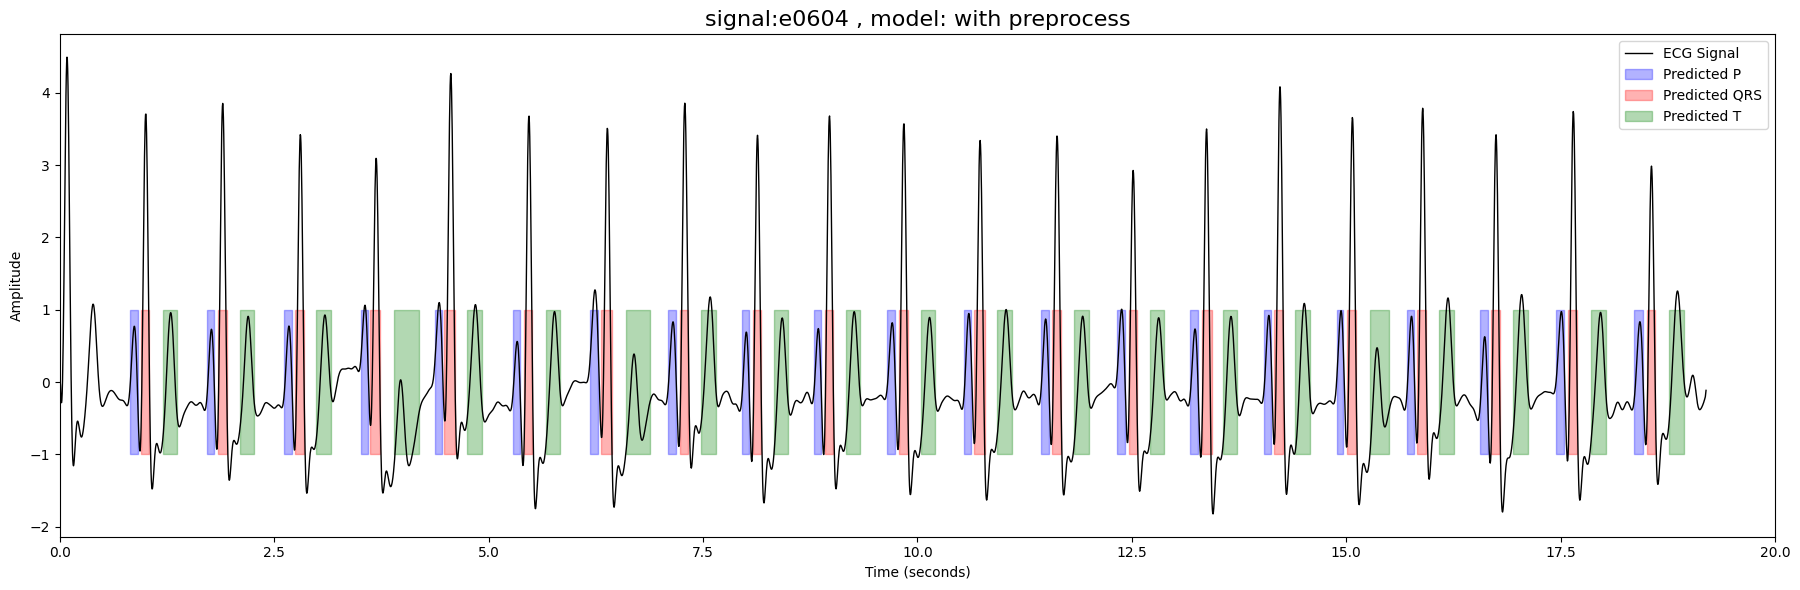

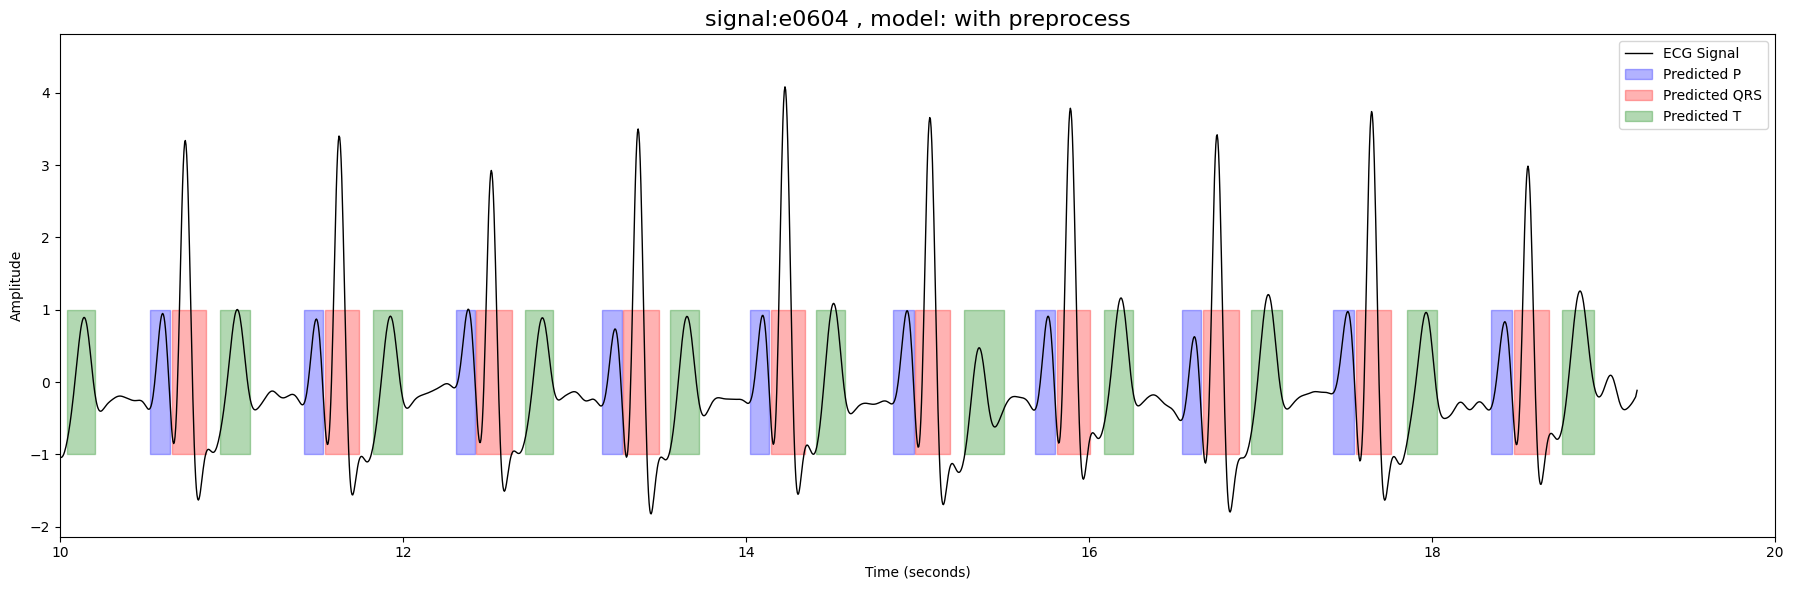

------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------
(1, 1, 4800)
(1, 4800)


In [31]:
#record = wfdb.rdrecord(edb_path+'e0604')# Run prediction
record = wfdb.rdrecord(mitdb_path+'101')# Run prediction
#record = wfdb.rdrecord(edb_path+'e0129')# Run prediction

signal = record.p_signal[:, 0]  # lead I
fs = record.fs

start,end = 10,30

signal=signal[int(start*fs):int(end*fs)]
#signal=signal[int(start*fs):int(end*fs)]



if fs != 250:
          signal = resample_signal(signal, original_fs=fs, target_fs=250)
          fs = 250
pred_labels,segments ,_ = predict_full_ecg(signal, model_deep, fs=250)

signal = np.concatenate(segments, axis=2)
signal = signal.reshape(-1)

pred_labels = remove_uncomplete_first_last_wave(pred_labels)
pred_labels = merge_close_waves(pred_labels)
pred_labels = remove_irrelevant_waves(pred_labels)
pred_labels = check_repeated_waves(pred_labels)
#pred_labels = fix_P(signal,pred_labels)
#pred_labels = fix_QRS(signal,mask=pred_labels,fs=fs)

boundaries = get_wave_boundaries(pred_labels)

visualize_boundaries(signal, boundaries,signal_name="e0604", model_name="with preprocess", fs=250, zoom=(0, end-start))
pred_labels = fix_P(signal,pred_labels)
pred_labels = fix_QRS(signal,mask=pred_labels,fs=fs)
pred_labels = merge_close_waves(pred_labels)

boundaries = get_wave_boundaries(pred_labels)

visualize_boundaries(signal, boundaries,signal_name="e0604", model_name="with preprocess", fs=250, zoom=(start, end-start))

print(120*"-")
print(120*"-")


X = signal.reshape(1, 1, -1)  # shape: (1, 1, L)
all_predicted_masks = pred_labels.reshape(1, -1)  # shape: (1, L)
print(X.shape)
print(all_predicted_masks.shape)


In [33]:
features_per_beat = extract_features_per_qrs(signal, all_predicted_masks.flatten(), fs)

# View or analyze:
for i, feat in enumerate(features_per_beat[-10:]):
    print(f"Beat {i+1}:")
    for key, value in feat.items():
        print(f"  {key}: {value:.2f}")
    print()

-0.3393113398512701
-0.4221261714155625
-0.3737464754823434
0.16419634215836398
-0.34773836755684995
-0.4272498014262246
-0.03769624936444349
-0.3084474512243958
-0.4667731796186605
-0.3109829447893888
-0.3044486905910004
-0.4299704404123943
-0.32030554021686775
-0.09722668737486324
-0.3471661016592241
-0.28850922926408107
-0.3005015916904549
-0.41958182715579295
-0.5866254683611389
-0.15691033715321823
-0.36672405630712235
Beat 1:
  start: 2632.00
  end: 2778.00
  Duree_P_ms: 124.00
  Duree_QRS_ms: 208.00
  Duree_T_ms: 184.00
  Intervalle_PR_ms: 124.00
  Intervalle_QT_ms: 460.00
  Intervalle_ST_ms: 76.00
  P_index: 2650.00
  Amplitude_P: 0.95
  R_index: 2683.00
  Amplitude_R: 3.34
  Intervalle_RR_ms: 888.00
  Q_index: 2666.00
  Amplitude_Q: -0.85
  S_index: 2702.00
  Amplitude_S: -1.63
  T_index: 2759.00
  Amplitude_T: 1.00
  T/R_ratio: 0.30
  P/R_ratio: 0.28
  QRS_area: 0.30
  Slope_QR: 61.64
  Slope_RS: -65.44
  P_symmetry: -1.88
  T_inversion: 0.00
  QRS_axis_estimate: 0.44
  Heart

beat:  0
beat_features:  {'start': 199, 'end': 342, 'Duree_P_ms': 120.0, 'Duree_QRS_ms': 208.0, 'Duree_T_ms': 172.0, 'Intervalle_PR_ms': np.float64(120.0), 'Intervalle_QT_ms': np.float64(452.0), 'Intervalle_ST_ms': np.float64(80.0), 'P_index': 217, 'Amplitude_P': np.float64(0.7724903488887251), 'R_index': np.int64(251), 'Amplitude_R': np.float64(3.7078246935825305), 'Intervalle_RR_ms': 0, 'Q_index': np.int64(234), 'Amplitude_Q': np.float64(-0.9529500891402035), 'S_index': np.int64(269), 'Amplitude_S': np.float64(-1.4781642837122422), 'T_index': 323, 'Amplitude_T': np.float64(0.9604819398922149), 'T/R_ratio': np.float64(0.2590418963319944), 'P/R_ratio': np.float64(0.208340580455636), 'QRS_area': np.float64(0.3079080161325079), 'Slope_QR': np.float64(68.54080562827549), 'Slope_RS': np.float64(-72.02762468464964), 'P_symmetry': np.float64(-4.021672356632468), 'T_inversion': 0, 'QRS_axis_estimate': np.float64(0.5184299674811301), 'Heart_rate_bpm': 0, 'Premature_beat': 0, 'Local_RR_variabil

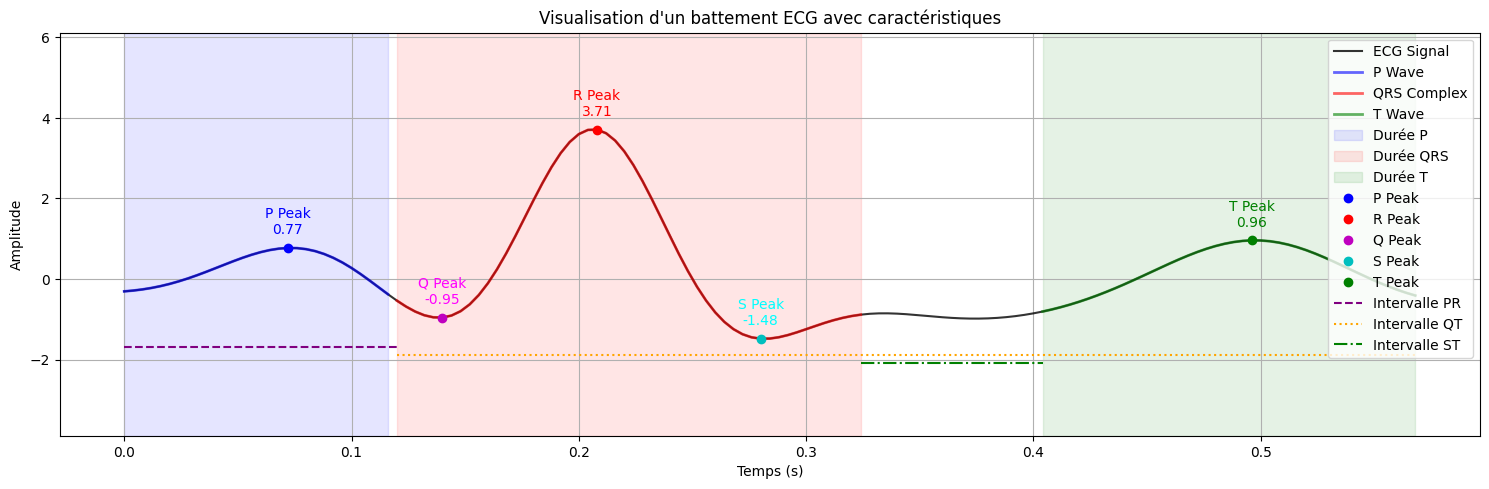

beat:  1
beat_features:  {'start': 425, 'end': 567, 'Duree_P_ms': 116.0, 'Duree_QRS_ms': 208.0, 'Duree_T_ms': 168.0, 'Intervalle_PR_ms': np.float64(116.0), 'Intervalle_QT_ms': np.float64(452.0), 'Intervalle_ST_ms': np.float64(84.0), 'P_index': 442, 'Amplitude_P': np.float64(0.7307248291952854), 'R_index': np.int64(475), 'Amplitude_R': np.float64(3.854795524124013), 'Intervalle_RR_ms': np.float64(896.0), 'Q_index': np.int64(458), 'Amplitude_Q': np.float64(-0.9289230464520715), 'S_index': np.int64(494), 'Amplitude_S': np.float64(-1.3575970240832909), 'T_index': 549, 'Amplitude_T': np.float64(0.9100525902751958), 'T/R_ratio': np.float64(0.236083233100153), 'P/R_ratio': np.float64(0.18956253960094024), 'QRS_area': np.float64(0.31248989770668173), 'Slope_QR': np.float64(70.34880250847182), 'Slope_RS': np.float64(-68.58411247641189), 'P_symmetry': np.float64(-13.093710669327182), 'T_inversion': 0, 'QRS_axis_estimate': np.float64(0.5578806260325716), 'Heart_rate_bpm': np.float64(66.9642857142

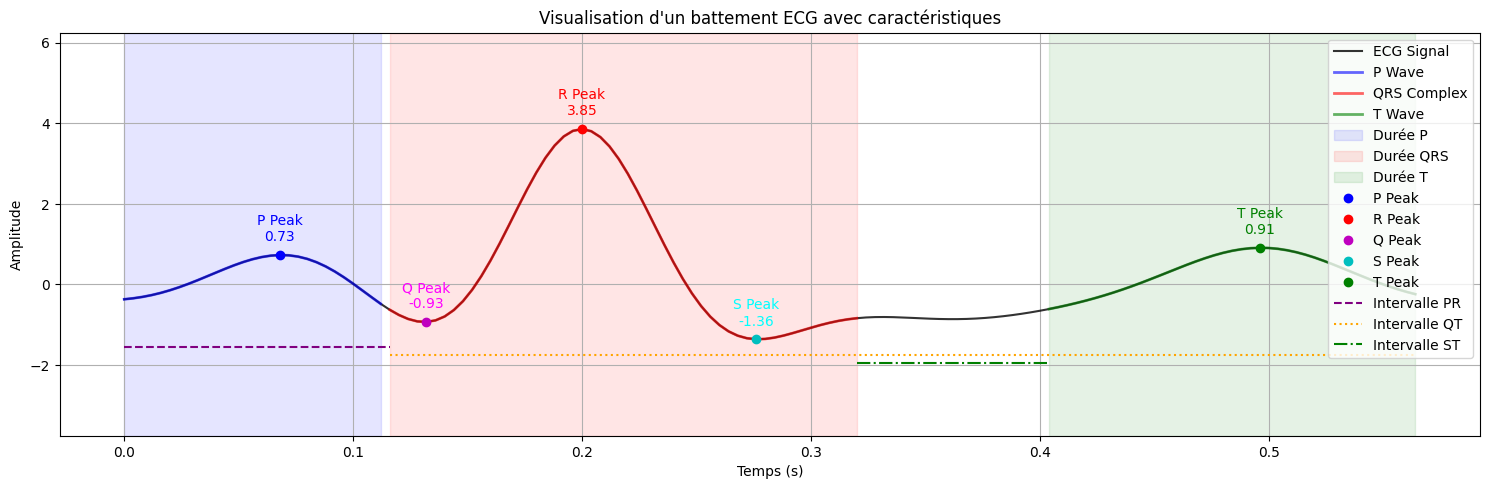

beat:  2
beat_features:  {'start': 649, 'end': 791, 'Duree_P_ms': 124.0, 'Duree_QRS_ms': 212.0, 'Duree_T_ms': 176.0, 'Intervalle_PR_ms': np.float64(124.0), 'Intervalle_QT_ms': np.float64(444.0), 'Intervalle_ST_ms': np.float64(64.0), 'P_index': 668, 'Amplitude_P': np.float64(0.7755747226385459), 'R_index': np.int64(701), 'Amplitude_R': np.float64(3.422341263447601), 'Intervalle_RR_ms': np.float64(904.0), 'Q_index': np.int64(684), 'Amplitude_Q': np.float64(-0.9403077273528736), 'S_index': np.int64(720), 'Amplitude_S': np.float64(-1.537239737419662), 'T_index': 773, 'Amplitude_T': np.float64(0.9285557528707388), 'T/R_ratio': np.float64(0.2713217886211995), 'P/R_ratio': np.float64(0.22662109443090628), 'QRS_area': np.float64(0.2992434740883784), 'Slope_QR': np.float64(64.15660280588934), 'Slope_RS': np.float64(-65.25764474825345), 'P_symmetry': np.float64(-36.28831631152164), 'T_inversion': 0, 'QRS_axis_estimate': np.float64(0.4788918748542737), 'Heart_rate_bpm': np.float64(66.371681415929

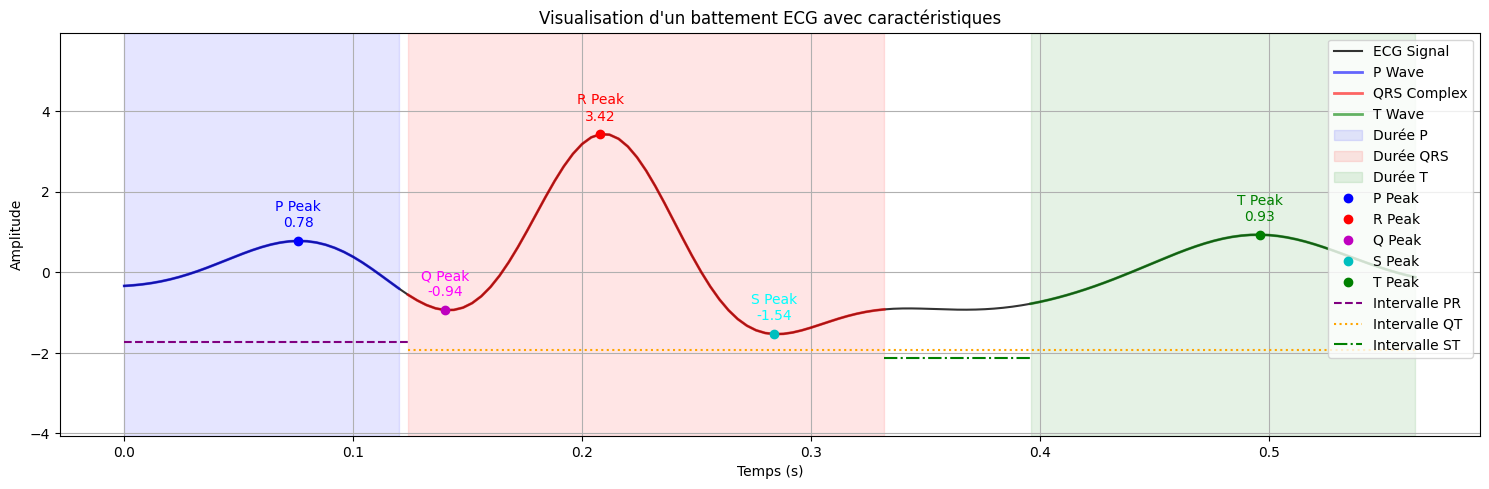

beat:  3
beat_features:  {'start': 874, 'end': 1047, 'Duree_P_ms': 104.0, 'Duree_QRS_ms': 204.0, 'Duree_T_ms': 296.0, 'Intervalle_PR_ms': np.float64(104.0), 'Intervalle_QT_ms': np.float64(588.0), 'Intervalle_ST_ms': np.float64(96.0), 'P_index': 890, 'Amplitude_P': np.float64(1.0629578803272137), 'R_index': np.int64(922), 'Amplitude_R': np.float64(3.0948037460975644), 'Intervalle_RR_ms': np.float64(884.0), 'Q_index': np.int64(906), 'Amplitude_Q': np.float64(-0.598619411074286), 'S_index': np.int64(942), 'Amplitude_S': np.float64(-1.5348404674283993), 'T_index': 994, 'Amplitude_T': np.float64(0.031138002964259826), 'T/R_ratio': np.float64(0.383753534264596), 'P/R_ratio': np.float64(0.343465359206562), 'QRS_area': np.float64(0.2627756011337405), 'Slope_QR': np.float64(57.70973683081016), 'Slope_RS': np.float64(-57.87055266907455), 'P_symmetry': np.float64(0.4522779236923483), 'T_inversion': 0, 'QRS_axis_estimate': np.float64(0.41286791024057906), 'Heart_rate_bpm': np.float64(67.8733031674

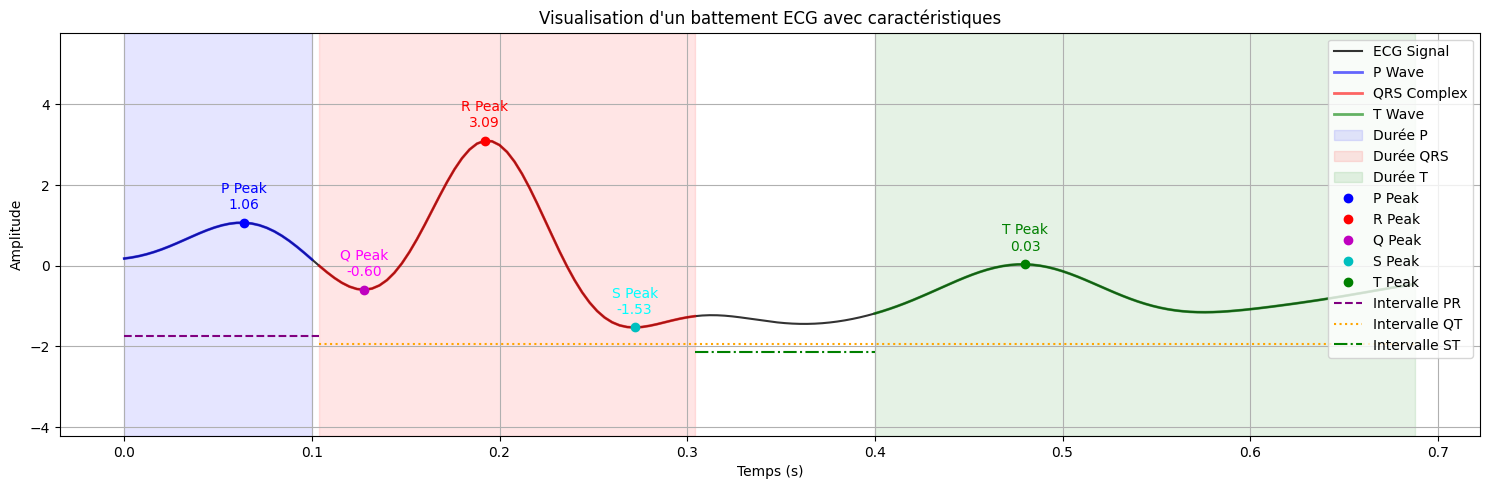

beat:  4
beat_features:  {'start': 1048, 'end': 1232, 'Duree_P_ms': 288.0, 'Duree_QRS_ms': 200.0, 'Duree_T_ms': 180.0, 'Intervalle_PR_ms': np.float64(288.0), 'Intervalle_QT_ms': np.float64(448.0), 'Intervalle_ST_ms': np.float64(76.0), 'P_index': 1106, 'Amplitude_P': np.float64(1.1001886382735582), 'R_index': np.int64(1140), 'Amplitude_R': np.float64(4.2679614028984565), 'Intervalle_RR_ms': np.float64(872.0), 'Q_index': np.int64(1123), 'Amplitude_Q': np.float64(-0.5369486416907429), 'S_index': np.int64(1159), 'Amplitude_S': np.float64(-1.0613961422138183), 'T_index': 1212, 'Amplitude_T': np.float64(1.0712099895559637), 'T/R_ratio': np.float64(0.25098867783304785), 'P/R_ratio': np.float64(0.2577784882324377), 'QRS_area': np.float64(0.31129468502426005), 'Slope_QR': np.float64(70.66044183219411), 'Slope_RS': np.float64(-70.12312559358257), 'P_symmetry': np.float64(4.385244633499385), 'T_inversion': 0, 'QRS_axis_estimate': np.float64(0.6381380625271171), 'Heart_rate_bpm': np.float64(68.807

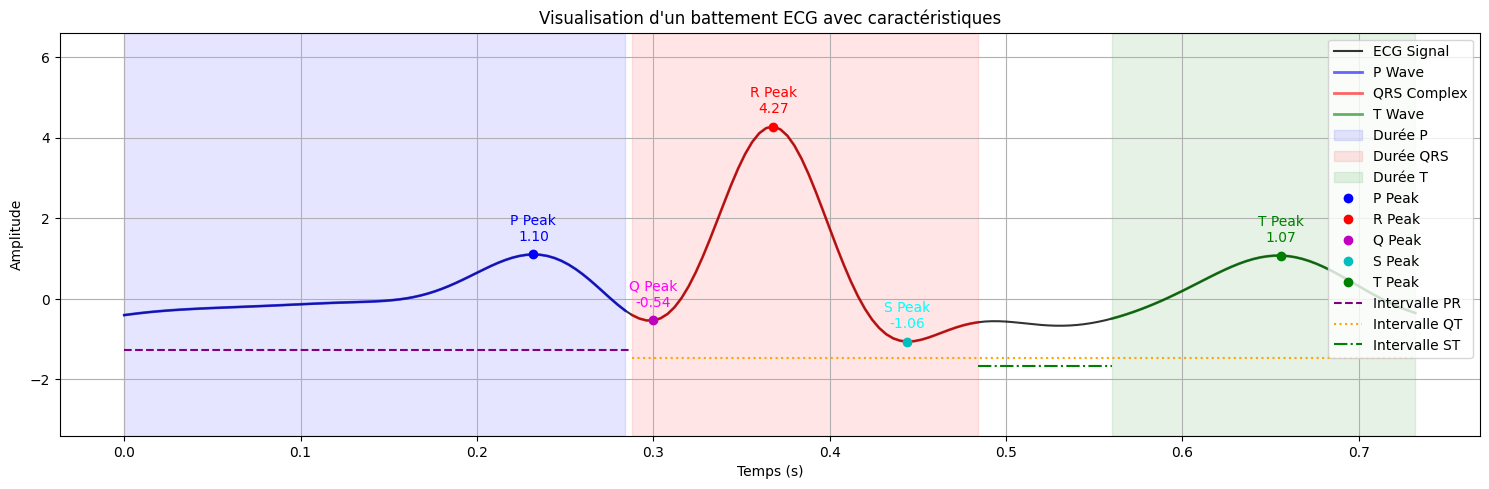

beat:  5
beat_features:  {'start': 1315, 'end': 1459, 'Duree_P_ms': 120.0, 'Duree_QRS_ms': 216.0, 'Duree_T_ms': 172.0, 'Intervalle_PR_ms': np.float64(120.0), 'Intervalle_QT_ms': np.float64(456.0), 'Intervalle_ST_ms': np.float64(76.0), 'P_index': 1333, 'Amplitude_P': np.float64(0.561727738878654), 'R_index': np.int64(1368), 'Amplitude_R': np.float64(3.678774812399778), 'Intervalle_RR_ms': np.float64(912.0), 'Q_index': np.int64(1350), 'Amplitude_Q': np.float64(-1.1535251137474312), 'S_index': np.int64(1387), 'Amplitude_S': np.float64(-1.750602531707289), 'T_index': 1442, 'Amplitude_T': np.float64(0.9757024685499024), 'T/R_ratio': np.float64(0.2652248420482747), 'P/R_ratio': np.float64(0.15269424401441462), 'QRS_area': np.float64(0.33500908452794503), 'Slope_QR': np.float64(67.11527675204458), 'Slope_RS': np.float64(-71.43917558035615), 'P_symmetry': np.float64(6.539248663574376), 'T_inversion': 0, 'QRS_axis_estimate': np.float64(0.4681365014950876), 'Heart_rate_bpm': np.float64(65.789473

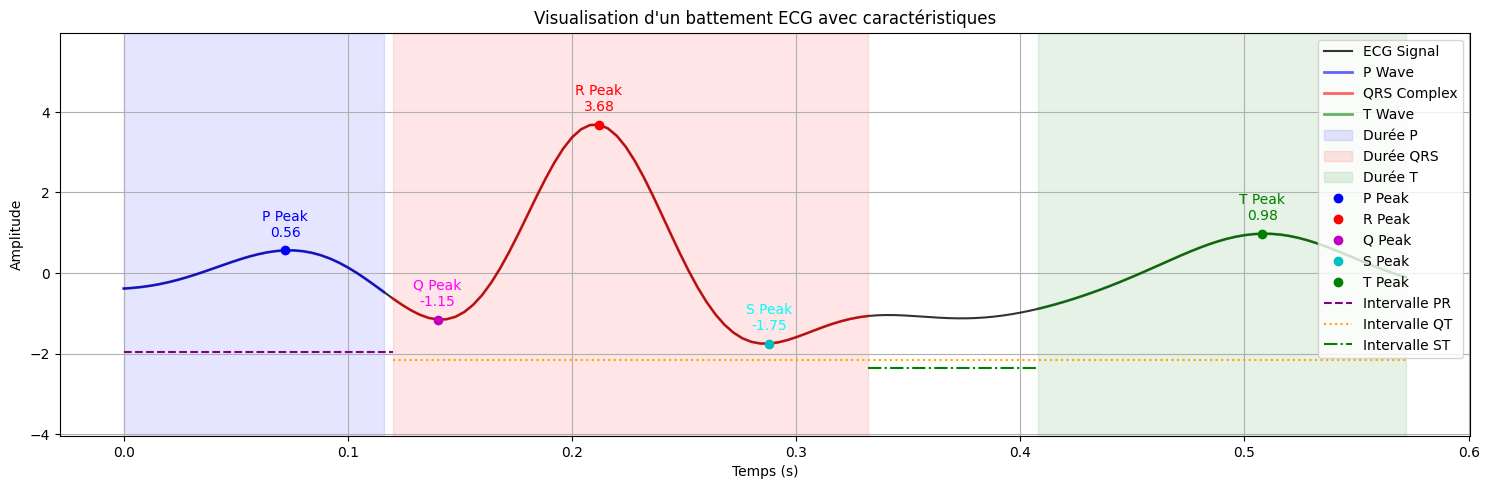

beat:  6
beat_features:  {'start': 1537, 'end': 1722, 'Duree_P_ms': 148.0, 'Duree_QRS_ms': 212.0, 'Duree_T_ms': 288.0, 'Intervalle_PR_ms': np.float64(148.0), 'Intervalle_QT_ms': np.float64(592.0), 'Intervalle_ST_ms': np.float64(100.0), 'P_index': 1560, 'Amplitude_P': np.float64(1.2757330203338997), 'R_index': np.int64(1596), 'Amplitude_R': np.float64(3.509183830350931), 'Intervalle_RR_ms': np.float64(912.0), 'Q_index': np.int64(1579), 'Amplitude_Q': np.float64(-0.7661287639757034), 'S_index': np.int64(1616), 'Amplitude_S': np.float64(-1.7307860854395827), 'T_index': 1674, 'Amplitude_T': np.float64(0.3888509641838488), 'T/R_ratio': np.float64(0.26906253567127403), 'P/R_ratio': np.float64(0.363541234089843), 'QRS_area': np.float64(0.31053502660412313), 'Slope_QR': np.float64(62.87224403421521), 'Slope_RS': np.float64(-65.49962394738142), 'P_symmetry': np.float64(-0.3965657645242149), 'T_inversion': 0, 'QRS_axis_estimate': np.float64(0.42365705608570503), 'Heart_rate_bpm': np.float64(65.7

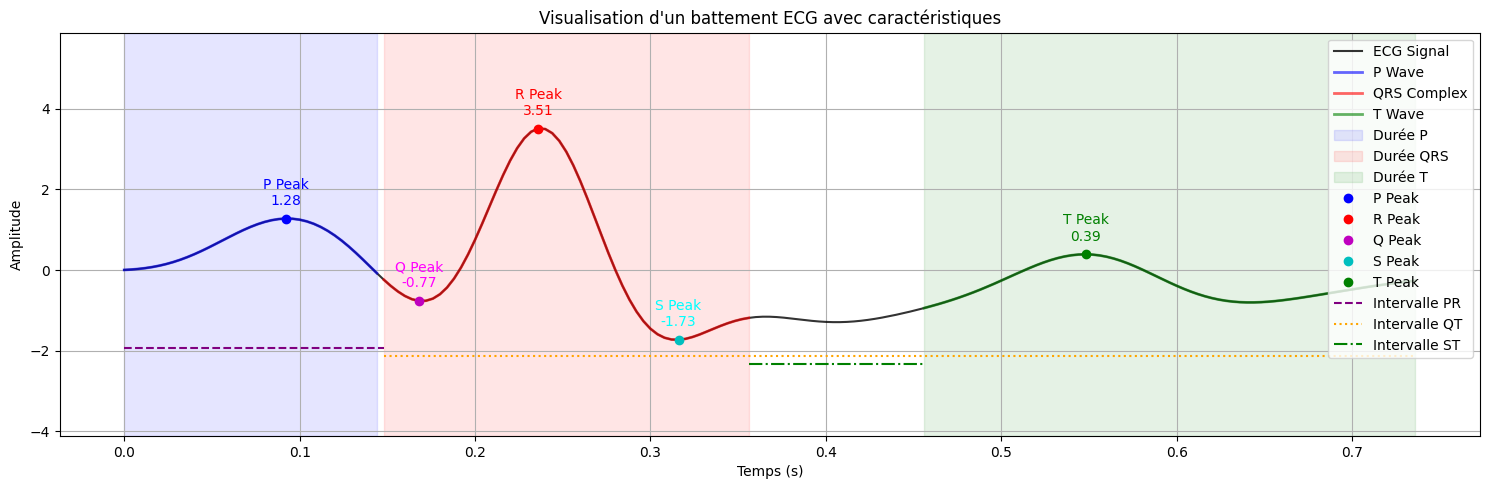

beat:  7
beat_features:  {'start': 1768, 'end': 1913, 'Duree_P_ms': 128.0, 'Duree_QRS_ms': 212.0, 'Duree_T_ms': 176.0, 'Intervalle_PR_ms': np.float64(128.0), 'Intervalle_QT_ms': np.float64(452.0), 'Intervalle_ST_ms': np.float64(72.0), 'P_index': 1788, 'Amplitude_P': np.float64(0.833473395352245), 'R_index': np.int64(1822), 'Amplitude_R': np.float64(3.857989817965861), 'Intervalle_RR_ms': np.float64(904.0), 'Q_index': np.int64(1805), 'Amplitude_Q': np.float64(-0.8897328310584164), 'S_index': np.int64(1841), 'Amplitude_S': np.float64(-1.1901225824851815), 'T_index': 1896, 'Amplitude_T': np.float64(1.1783370363958439), 'T/R_ratio': np.float64(0.3054277206509389), 'P/R_ratio': np.float64(0.21603825688469463), 'QRS_area': np.float64(0.3024984897338573), 'Slope_QR': np.float64(69.81945072094526), 'Slope_RS': np.float64(-66.42253158488214), 'P_symmetry': np.float64(-2.825705995752936), 'T_inversion': 0, 'QRS_axis_estimate': np.float64(0.5991398106034684), 'Heart_rate_bpm': np.float64(66.37168

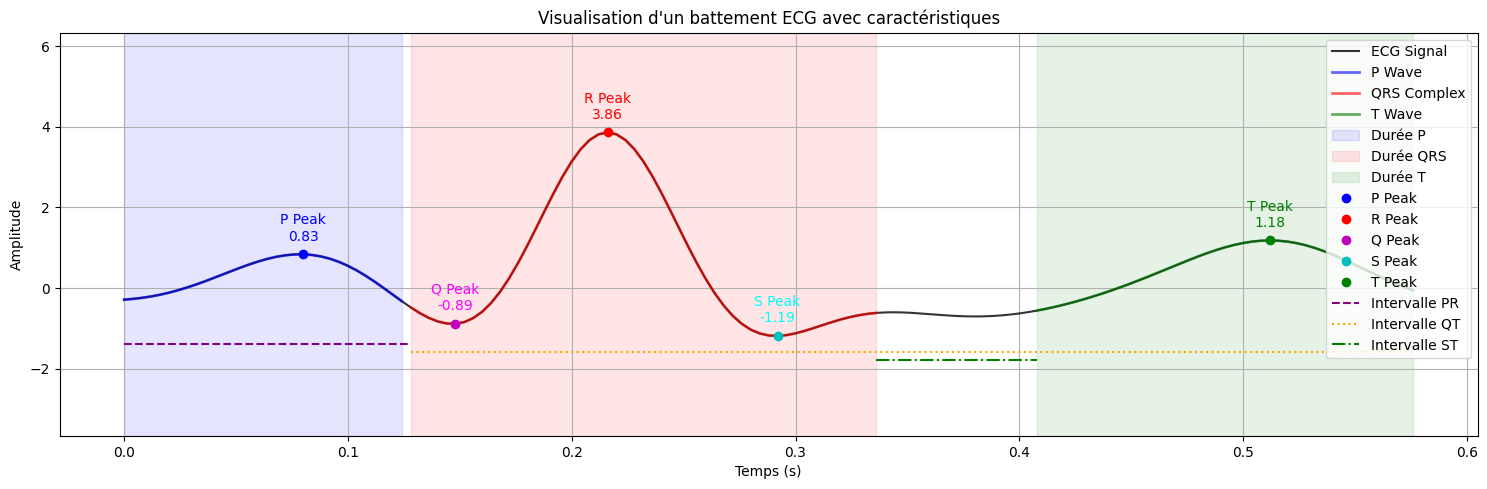

beat:  8
beat_features:  {'start': 1984, 'end': 2123, 'Duree_P_ms': 116.0, 'Duree_QRS_ms': 204.0, 'Duree_T_ms': 172.0, 'Intervalle_PR_ms': np.float64(116.0), 'Intervalle_QT_ms': np.float64(440.0), 'Intervalle_ST_ms': np.float64(72.0), 'P_index': 2001, 'Amplitude_P': np.float64(0.6915365338988207), 'R_index': np.int64(2034), 'Amplitude_R': np.float64(3.413821205152386), 'Intervalle_RR_ms': np.float64(848.0), 'Q_index': np.int64(2017), 'Amplitude_Q': np.float64(-1.0981095383898853), 'S_index': np.int64(2053), 'Amplitude_S': np.float64(-1.6711645657524756), 'T_index': 2106, 'Amplitude_T': np.float64(0.8873001251143795), 'T/R_ratio': np.float64(0.30651582583198117), 'P/R_ratio': np.float64(0.2025696403944951), 'QRS_area': np.float64(0.30219179338124463), 'Slope_QR': np.float64(66.35192269915105), 'Slope_RS': np.float64(-66.90770751190607), 'P_symmetry': np.float64(19.45825359604106), 'T_inversion': 0, 'QRS_axis_estimate': np.float64(0.4594407131455175), 'Heart_rate_bpm': np.float64(70.7547

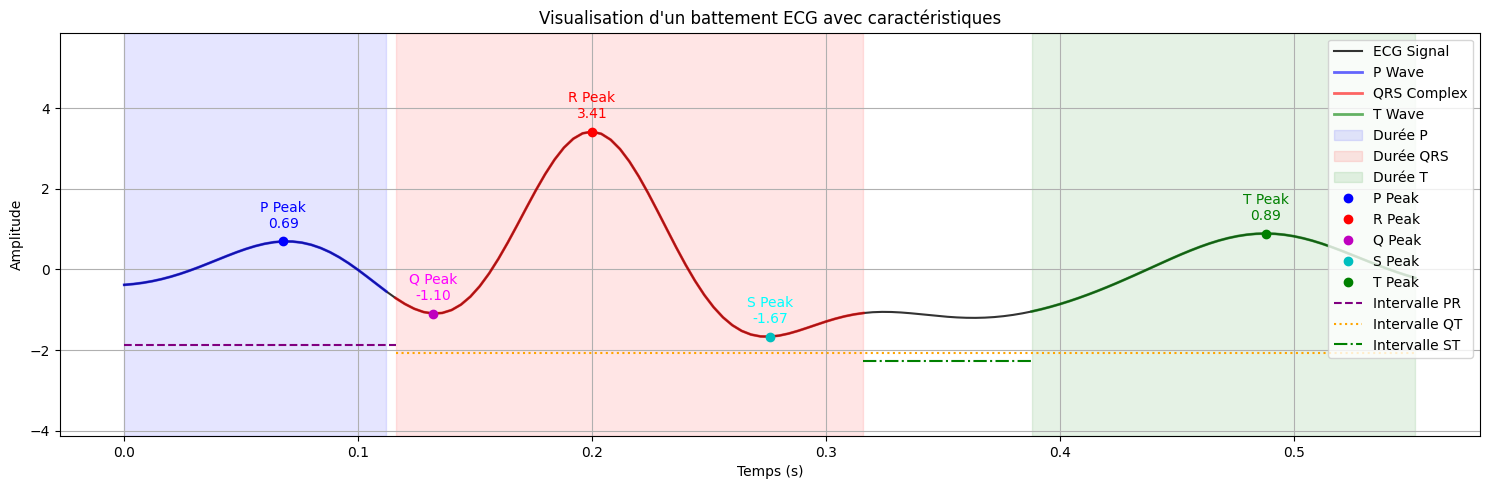

beat:  9
beat_features:  {'start': 2195, 'end': 2333, 'Duree_P_ms': 108.0, 'Duree_QRS_ms': 212.0, 'Duree_T_ms': 172.0, 'Intervalle_PR_ms': np.float64(108.0), 'Intervalle_QT_ms': np.float64(444.0), 'Intervalle_ST_ms': np.float64(68.0), 'P_index': 2211, 'Amplitude_P': np.float64(0.7397809168076099), 'R_index': np.int64(2244), 'Amplitude_R': np.float64(3.6809594474802734), 'Intervalle_RR_ms': np.float64(840.0), 'Q_index': np.int64(2227), 'Amplitude_Q': np.float64(-1.0021970375108196), 'S_index': np.int64(2263), 'Amplitude_S': np.float64(-1.4765985717633405), 'T_index': 2316, 'Amplitude_T': np.float64(0.9744238635633231), 'T/R_ratio': np.float64(0.26472007569394584), 'P/R_ratio': np.float64(0.20097502495280464), 'QRS_area': np.float64(0.31141752441209736), 'Slope_QR': np.float64(68.86994830869254), 'Slope_RS': np.float64(-67.86260551636335), 'P_symmetry': np.float64(-3.080776472186489), 'T_inversion': 0, 'QRS_axis_estimate': np.float64(0.52056573079897), 'Heart_rate_bpm': np.float64(71.428

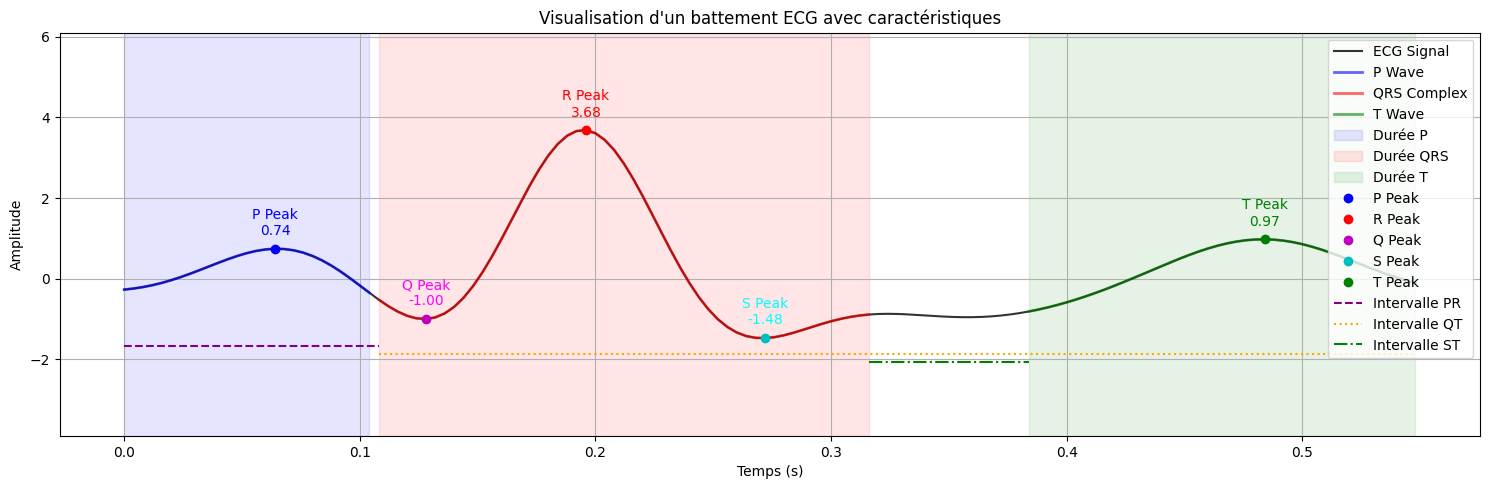

beat:  10
beat_features:  {'start': 2407, 'end': 2552, 'Duree_P_ms': 128.0, 'Duree_QRS_ms': 212.0, 'Duree_T_ms': 172.0, 'Intervalle_PR_ms': np.float64(128.0), 'Intervalle_QT_ms': np.float64(452.0), 'Intervalle_ST_ms': np.float64(76.0), 'P_index': 2427, 'Amplitude_P': np.float64(0.8204173683325392), 'R_index': np.int64(2461), 'Amplitude_R': np.float64(3.5720072092884263), 'Intervalle_RR_ms': np.float64(868.0), 'Q_index': np.int64(2444), 'Amplitude_Q': np.float64(-0.9326291943545536), 'S_index': np.int64(2480), 'Amplitude_S': np.float64(-1.5562167588706632), 'T_index': 2536, 'Amplitude_T': np.float64(0.8937019629193073), 'T/R_ratio': np.float64(0.25019601320943025), 'P/R_ratio': np.float64(0.22967965075747235), 'QRS_area': np.float64(0.30957886082525865), 'Slope_QR': np.float64(66.2446529947497), 'Slope_RS': np.float64(-67.47663115998802), 'P_symmetry': np.float64(-1.7262621714148514), 'T_inversion': 0, 'QRS_axis_estimate': np.float64(0.4864693268827156), 'Heart_rate_bpm': np.float64(69.

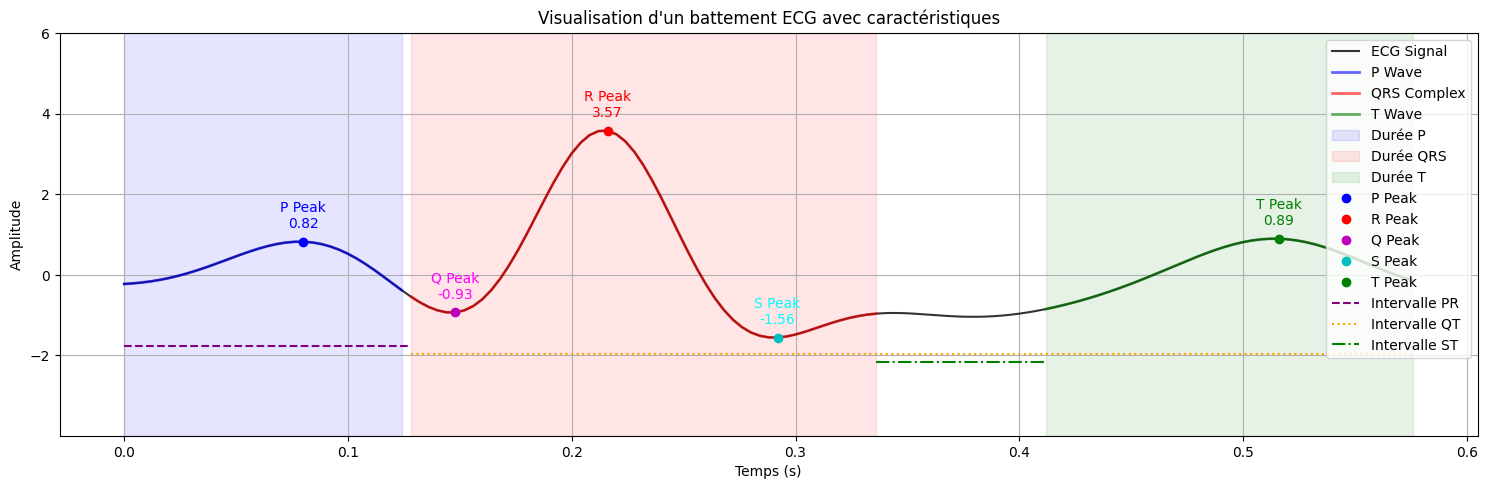

beat:  11
beat_features:  {'start': 2632, 'end': 2778, 'Duree_P_ms': 124.0, 'Duree_QRS_ms': 208.0, 'Duree_T_ms': 184.0, 'Intervalle_PR_ms': np.float64(124.0), 'Intervalle_QT_ms': np.float64(460.0), 'Intervalle_ST_ms': np.float64(76.0), 'P_index': 2650, 'Amplitude_P': np.float64(0.9492420312078345), 'R_index': np.int64(2683), 'Amplitude_R': np.float64(3.3416112822299113), 'Intervalle_RR_ms': np.float64(888.0), 'Q_index': np.int64(2666), 'Amplitude_Q': np.float64(-0.8501439381150254), 'S_index': np.int64(2702), 'Amplitude_S': np.float64(-1.6320820449162148), 'T_index': 2759, 'Amplitude_T': np.float64(1.0035981050797504), 'T/R_ratio': np.float64(0.30033358769666146), 'P/R_ratio': np.float64(0.2840671613289472), 'QRS_area': np.float64(0.29645906611707346), 'Slope_QR': np.float64(61.643459122719655), 'Slope_RS': np.float64(-65.44333325192271), 'P_symmetry': np.float64(-1.8829659493670547), 'T_inversion': 0, 'QRS_axis_estimate': np.float64(0.43951652824856413), 'Heart_rate_bpm': np.float64(6

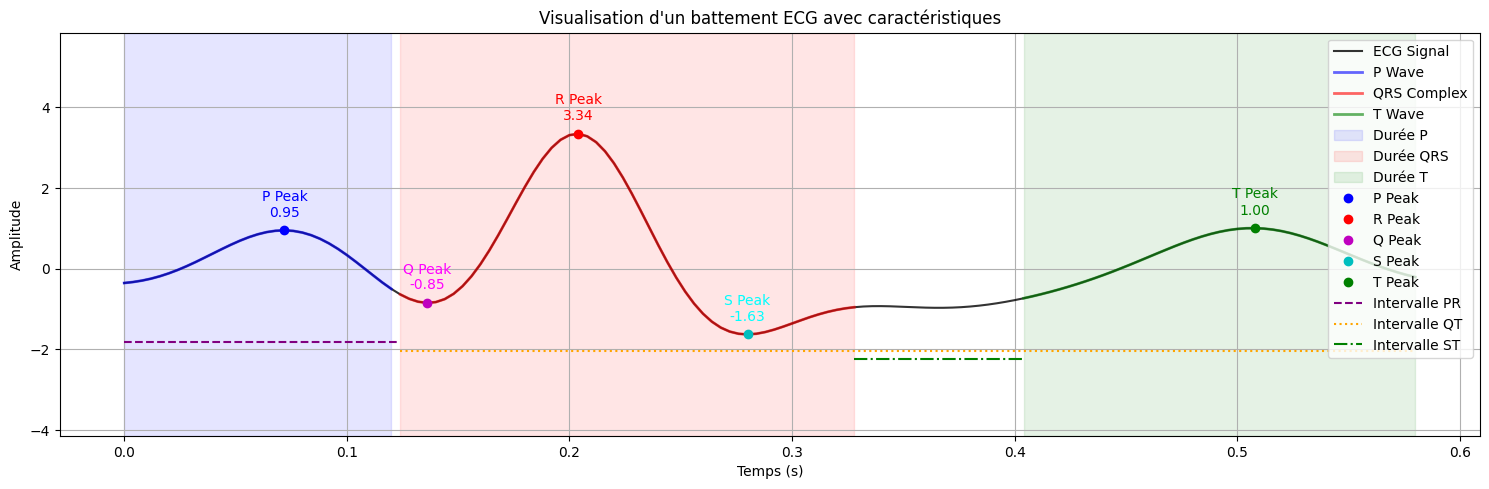

beat:  12
beat_features:  {'start': 2856, 'end': 3000, 'Duree_P_ms': 120.0, 'Duree_QRS_ms': 208.0, 'Duree_T_ms': 180.0, 'Intervalle_PR_ms': np.float64(120.0), 'Intervalle_QT_ms': np.float64(456.0), 'Intervalle_ST_ms': np.float64(76.0), 'P_index': 2874, 'Amplitude_P': np.float64(0.8725259434748442), 'R_index': np.int64(2907), 'Amplitude_R': np.float64(3.4036056858740107), 'Intervalle_RR_ms': np.float64(896.0), 'Q_index': np.int64(2890), 'Amplitude_Q': np.float64(-0.8630595381185292), 'S_index': np.int64(2927), 'Amplitude_S': np.float64(-1.560916406232433), 'T_index': 2982, 'Amplitude_T': np.float64(0.9117844045364852), 'T/R_ratio': np.float64(0.269794440219591), 'P/R_ratio': np.float64(0.2563534157602597), 'QRS_area': np.float64(0.296214159882434), 'Slope_QR': np.float64(62.7450768234197), 'Slope_RS': np.float64(-62.056526151330544), 'P_symmetry': np.float64(-1.7731447929329969), 'T_inversion': 0, 'QRS_axis_estimate': np.float64(0.46430037795202433), 'Heart_rate_bpm': np.float64(66.9642

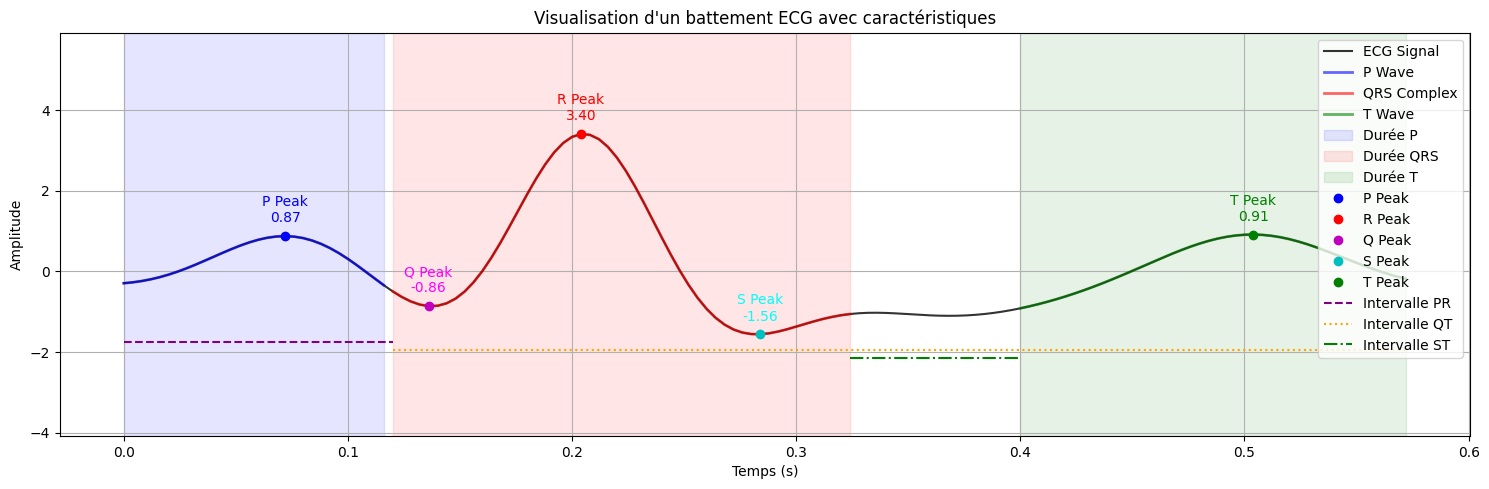

beat:  13
beat_features:  {'start': 3077, 'end': 3220, 'Duree_P_ms': 120.0, 'Duree_QRS_ms': 216.0, 'Duree_T_ms': 172.0, 'Intervalle_PR_ms': np.float64(120.0), 'Intervalle_QT_ms': np.float64(452.0), 'Intervalle_ST_ms': np.float64(72.0), 'P_index': 3095, 'Amplitude_P': np.float64(1.0069940938352524), 'R_index': np.int64(3129), 'Amplitude_R': np.float64(2.927417966864625), 'Intervalle_RR_ms': np.float64(888.0), 'Q_index': np.int64(3113), 'Amplitude_Q': np.float64(-0.8358495437793315), 'S_index': np.int64(3148), 'Amplitude_S': np.float64(-1.5102675577799725), 'T_index': 3203, 'Amplitude_T': np.float64(0.8893919611468074), 'T/R_ratio': np.float64(0.30381447788249377), 'P/R_ratio': np.float64(0.34398712627762584), 'QRS_area': np.float64(0.2701108881251742), 'Slope_QR': np.float64(58.80105485381182), 'Slope_RS': np.float64(-58.390599008481544), 'P_symmetry': np.float64(-0.3121292682013401), 'T_inversion': 0, 'QRS_axis_estimate': np.float64(0.4272275610958939), 'Heart_rate_bpm': np.float64(67.

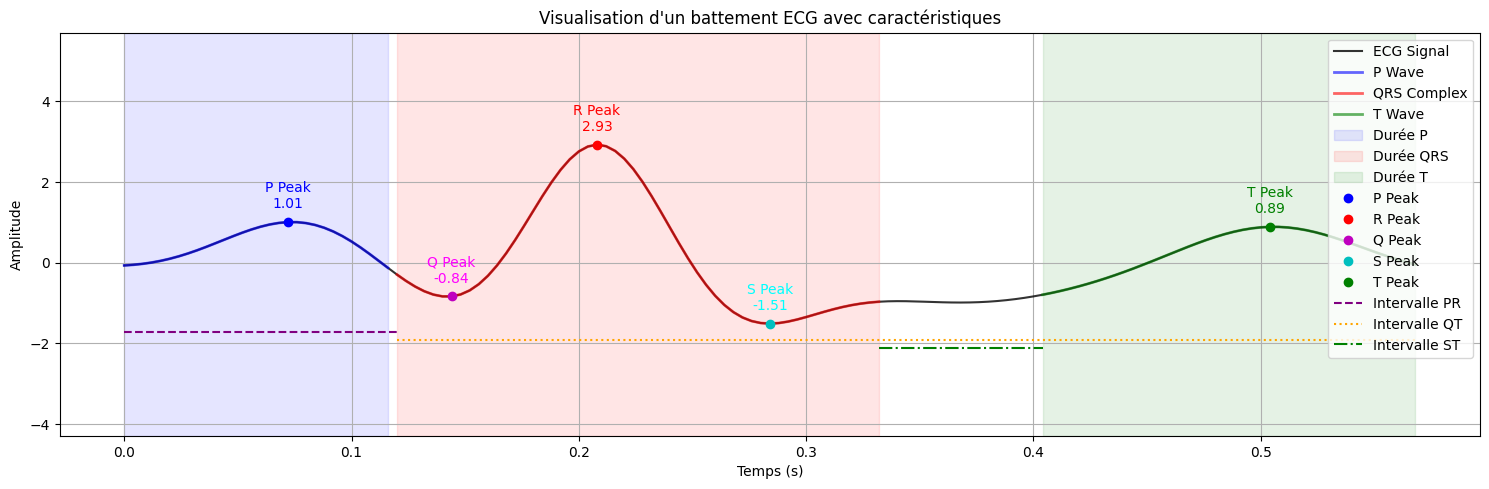

beat:  14
beat_features:  {'start': 3291, 'end': 3432, 'Duree_P_ms': 120.0, 'Duree_QRS_ms': 216.0, 'Duree_T_ms': 172.0, 'Intervalle_PR_ms': np.float64(120.0), 'Intervalle_QT_ms': np.float64(444.0), 'Intervalle_ST_ms': np.float64(64.0), 'P_index': 3309, 'Amplitude_P': np.float64(0.7341120818160527), 'R_index': np.int64(3343), 'Amplitude_R': np.float64(3.5014015262592464), 'Intervalle_RR_ms': np.float64(856.0), 'Q_index': np.int64(3326), 'Amplitude_Q': np.float64(-1.0388146557677291), 'S_index': np.int64(3362), 'Amplitude_S': np.float64(-1.8230724510488174), 'T_index': 3414, 'Amplitude_T': np.float64(0.9087203556805811), 'T/R_ratio': np.float64(0.26352463411353116), 'P/R_ratio': np.float64(0.20966235272089684), 'QRS_area': np.float64(0.32397003939635827), 'Slope_QR': np.float64(66.76788502980847), 'Slope_RS': np.float64(-70.05886812247452), 'P_symmetry': np.float64(-7.403142403790222), 'T_inversion': 0, 'QRS_axis_estimate': np.float64(0.42700299493750765), 'Heart_rate_bpm': np.float64(70

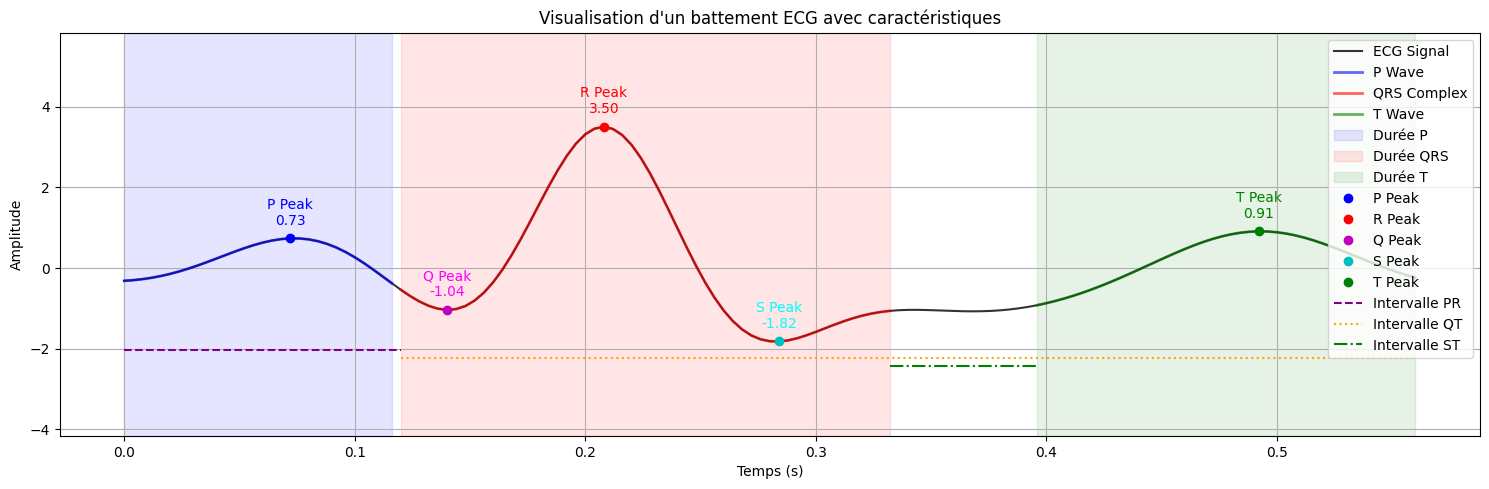

beat:  15
beat_features:  {'start': 3506, 'end': 3646, 'Duree_P_ms': 120.0, 'Duree_QRS_ms': 208.0, 'Duree_T_ms': 180.0, 'Intervalle_PR_ms': np.float64(120.0), 'Intervalle_QT_ms': np.float64(440.0), 'Intervalle_ST_ms': np.float64(60.0), 'P_index': 3525, 'Amplitude_P': np.float64(0.9218967573023596), 'R_index': np.int64(3557), 'Amplitude_R': np.float64(4.08403572366045), 'Intervalle_RR_ms': np.float64(856.0), 'Q_index': np.int64(3540), 'Amplitude_Q': np.float64(-0.8602411543163191), 'S_index': np.int64(3576), 'Amplitude_S': np.float64(-1.5528942354470423), 'T_index': 3628, 'Amplitude_T': np.float64(1.0888549700347656), 'T/R_ratio': np.float64(0.26661249893740985), 'P/R_ratio': np.float64(0.22573180542017388), 'QRS_area': np.float64(0.3312388428685934), 'Slope_QR': np.float64(72.70995408789365), 'Slope_RS': np.float64(-74.17013104088807), 'P_symmetry': np.float64(-2.3544907139229085), 'T_inversion': 0, 'QRS_axis_estimate': np.float64(0.5219782673638564), 'Heart_rate_bpm': np.float64(70.09

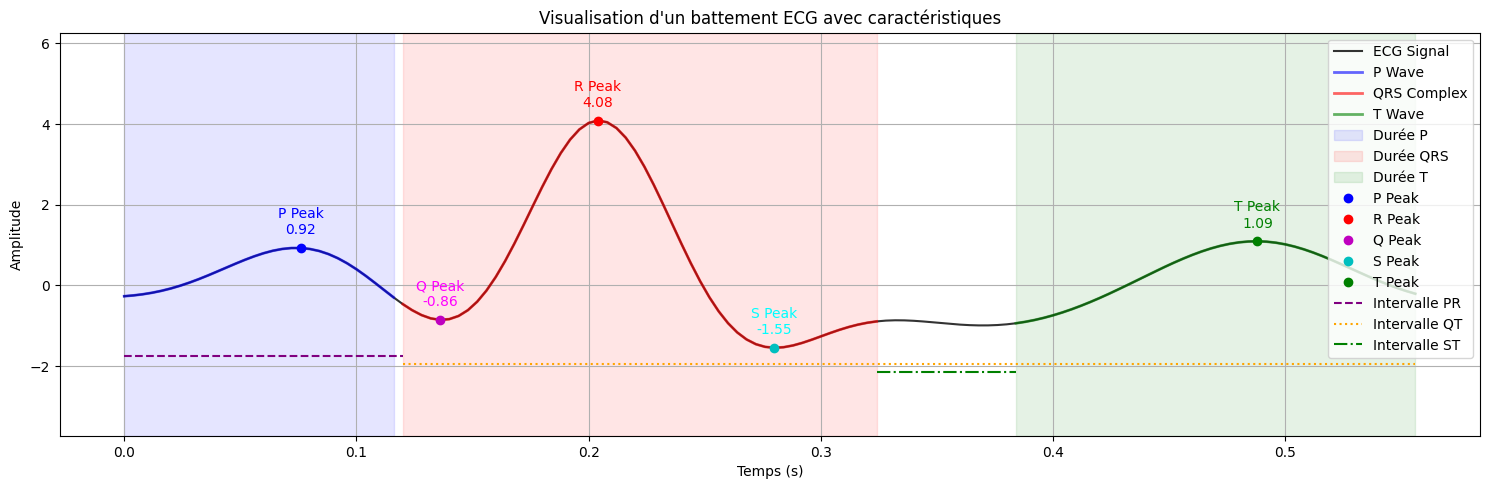

beat:  16
beat_features:  {'start': 3715, 'end': 3877, 'Duree_P_ms': 128.0, 'Duree_QRS_ms': 208.0, 'Duree_T_ms': 240.0, 'Intervalle_PR_ms': np.float64(128.0), 'Intervalle_QT_ms': np.float64(520.0), 'Intervalle_ST_ms': np.float64(80.0), 'P_index': 3735, 'Amplitude_P': np.float64(0.9881447329745894), 'R_index': np.int64(3768), 'Amplitude_R': np.float64(3.658895858705338), 'Intervalle_RR_ms': np.float64(844.0), 'Q_index': np.int64(3751), 'Amplitude_Q': np.float64(-0.8993234876543115), 'S_index': np.int64(3788), 'Amplitude_S': np.float64(-1.6950892912999493), 'T_index': 3840, 'Amplitude_T': np.float64(0.4753866640347705), 'T/R_ratio': np.float64(0.2892011258584032), 'P/R_ratio': np.float64(0.2700663727893677), 'QRS_area': np.float64(0.31872011677927686), 'Slope_QR': np.float64(67.03263744646543), 'Slope_RS': np.float64(-66.92481437506609), 'P_symmetry': np.float64(-3.298486438429867), 'T_inversion': 0, 'QRS_axis_estimate': np.float64(0.45785835356959426), 'Heart_rate_bpm': np.float64(71.09

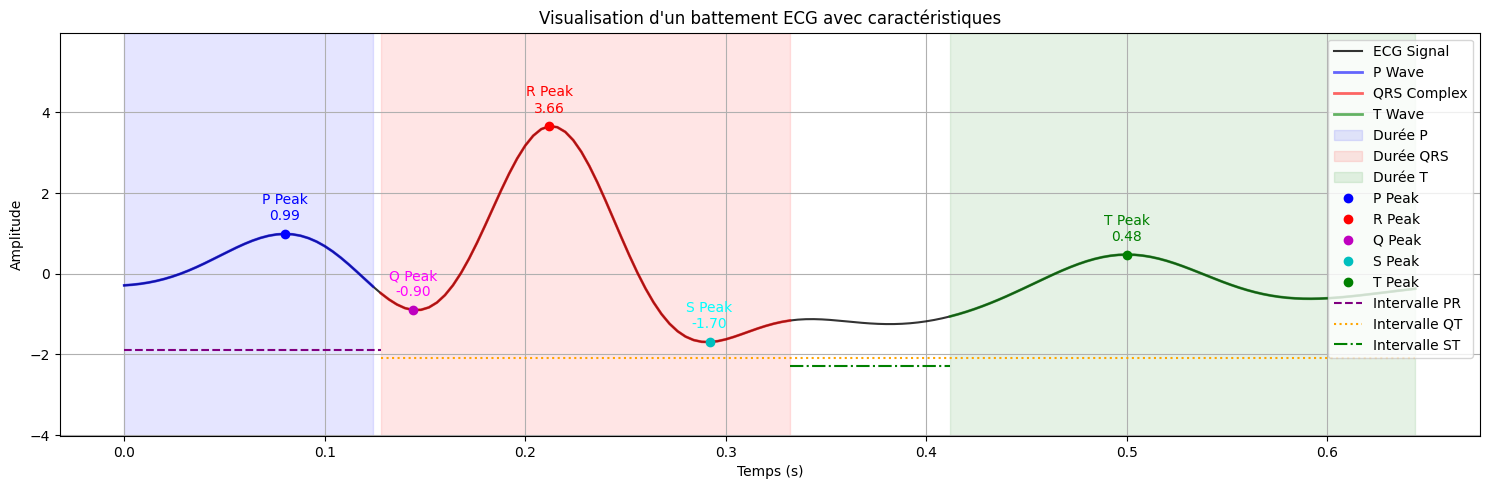

beat:  17
beat_features:  {'start': 3922, 'end': 4065, 'Duree_P_ms': 124.0, 'Duree_QRS_ms': 204.0, 'Duree_T_ms': 176.0, 'Intervalle_PR_ms': np.float64(124.0), 'Intervalle_QT_ms': np.float64(448.0), 'Intervalle_ST_ms': np.float64(76.0), 'P_index': 3941, 'Amplitude_P': np.float64(0.9095408438325517), 'R_index': np.int64(3973), 'Amplitude_R': np.float64(3.7878276511267055), 'Intervalle_RR_ms': np.float64(820.0), 'Q_index': np.int64(3956), 'Amplitude_Q': np.float64(-0.8438039733268478), 'S_index': np.int64(3992), 'Amplitude_S': np.float64(-1.3440694453910267), 'T_index': 4047, 'Amplitude_T': np.float64(1.1638875425041193), 'T/R_ratio': np.float64(0.30727045940379993), 'P/R_ratio': np.float64(0.2401220244437481), 'QRS_area': np.float64(0.29970157868993924), 'Slope_QR': np.float64(68.11222977137578), 'Slope_RS': np.float64(-67.52496179628595), 'P_symmetry': np.float64(-5.8800882698558254), 'T_inversion': 0, 'QRS_axis_estimate': np.float64(0.5501549676736196), 'Heart_rate_bpm': np.float64(73.

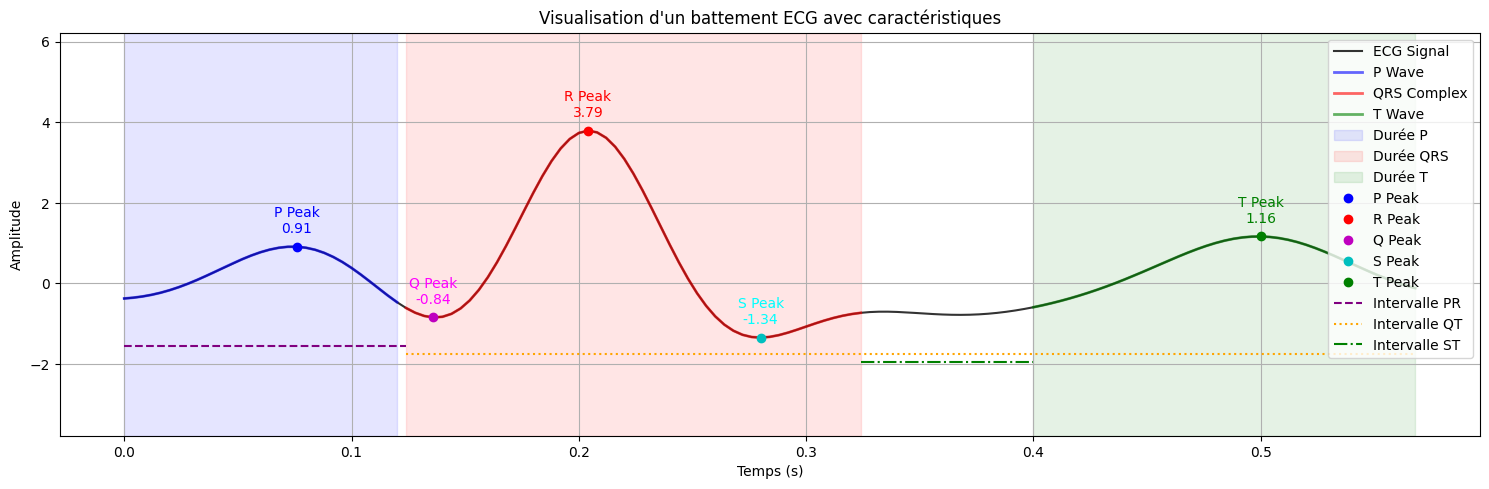

beat:  18
beat_features:  {'start': 4136, 'end': 4282, 'Duree_P_ms': 120.0, 'Duree_QRS_ms': 220.0, 'Duree_T_ms': 188.0, 'Intervalle_PR_ms': np.float64(120.0), 'Intervalle_QT_ms': np.float64(464.0), 'Intervalle_ST_ms': np.float64(64.0), 'P_index': 4154, 'Amplitude_P': np.float64(0.6279062893349351), 'R_index': np.int64(4187), 'Amplitude_R': np.float64(3.4209274282299464), 'Intervalle_RR_ms': np.float64(856.0), 'Q_index': np.int64(4170), 'Amplitude_Q': np.float64(-1.1203312058350954), 'S_index': np.int64(4206), 'Amplitude_S': np.float64(-1.7970780624578915), 'T_index': 4262, 'Amplitude_T': np.float64(1.2095788587961578), 'T/R_ratio': np.float64(0.353582145243583), 'P/R_ratio': np.float64(0.1933159263516065), 'QRS_area': np.float64(0.32856032596722623), 'Slope_QR': np.float64(66.78321520683883), 'Slope_RS': np.float64(-68.6579669827347), 'P_symmetry': np.float64(4.445006139611516), 'T_inversion': 0, 'QRS_axis_estimate': np.float64(0.4329495686404567), 'Heart_rate_bpm': np.float64(70.09345

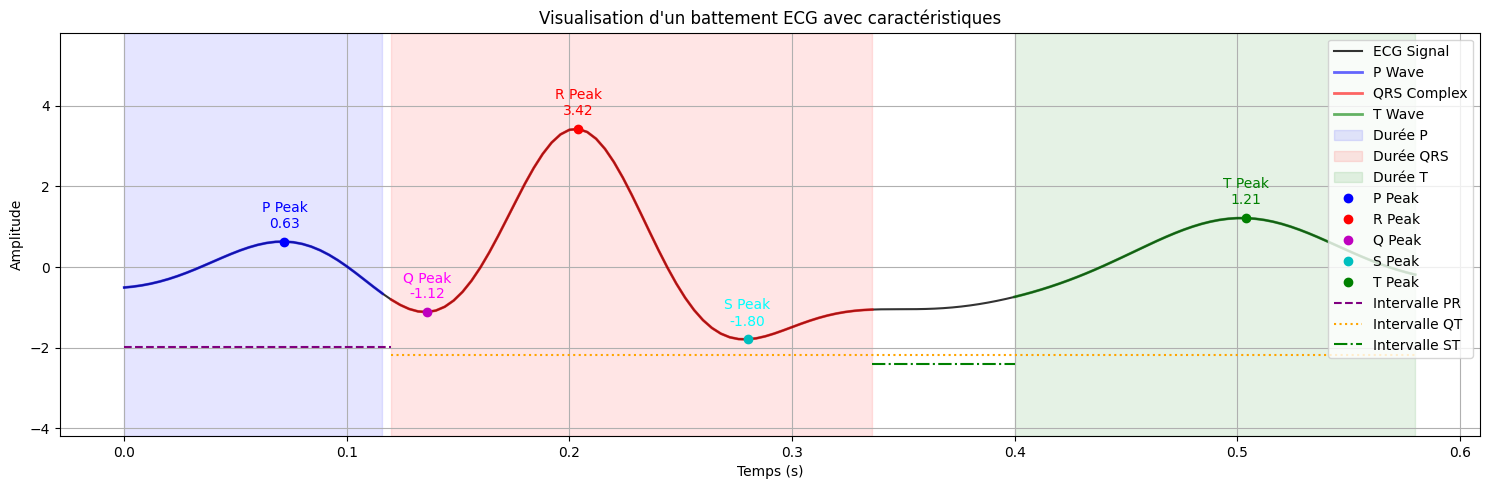

beat:  19
beat_features:  {'start': 4356, 'end': 4509, 'Duree_P_ms': 132.0, 'Duree_QRS_ms': 216.0, 'Duree_T_ms': 188.0, 'Intervalle_PR_ms': np.float64(132.0), 'Intervalle_QT_ms': np.float64(480.0), 'Intervalle_ST_ms': np.float64(84.0), 'P_index': 4377, 'Amplitude_P': np.float64(0.9753438034981049), 'R_index': np.int64(4412), 'Amplitude_R': np.float64(3.7424339354582137), 'Intervalle_RR_ms': np.float64(900.0), 'Q_index': np.int64(4395), 'Amplitude_Q': np.float64(-1.0909190970434253), 'S_index': np.int64(4431), 'Amplitude_S': np.float64(-1.633465665998396), 'T_index': 4491, 'Amplitude_T': np.float64(0.9631998537864581), 'T/R_ratio': np.float64(0.25737257367738314), 'P/R_ratio': np.float64(0.26061750730108385), 'QRS_area': np.float64(0.3274149970037767), 'Slope_QR': np.float64(71.07872106620057), 'Slope_RS': np.float64(-70.73552107179749), 'P_symmetry': np.float64(-2.076271153722017), 'T_inversion': 0, 'QRS_axis_estimate': np.float64(0.49481623358780985), 'Heart_rate_bpm': np.float64(66.6

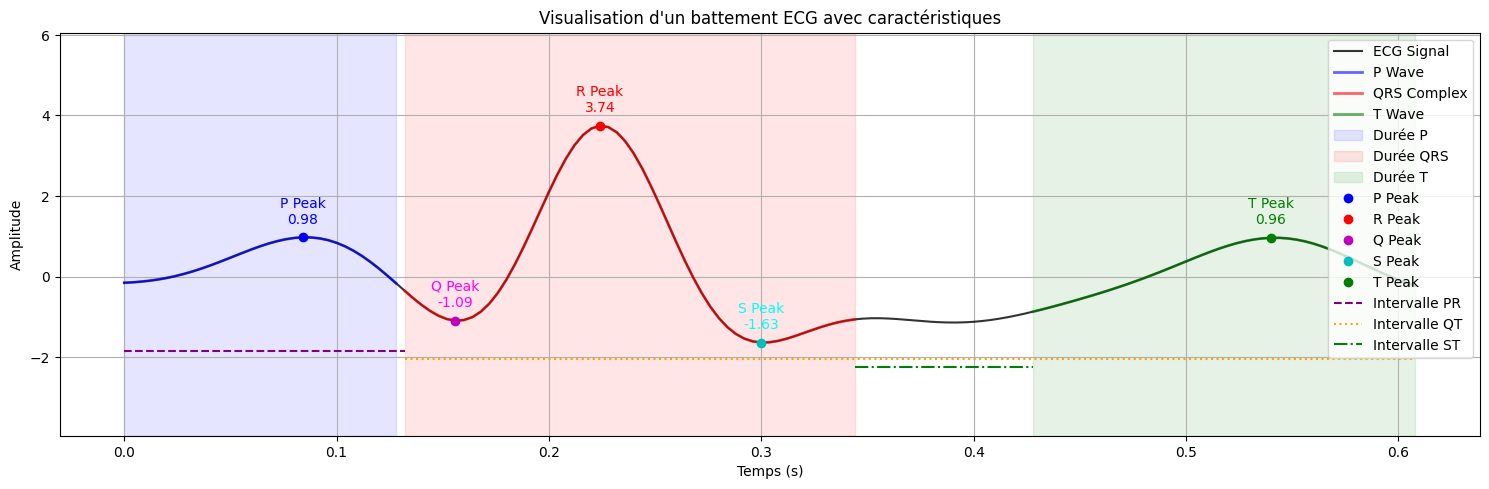

beat:  20
beat_features:  {'start': 4586, 'end': 4737, 'Duree_P_ms': 132.0, 'Duree_QRS_ms': 212.0, 'Duree_T_ms': 192.0, 'Intervalle_PR_ms': np.float64(132.0), 'Intervalle_QT_ms': np.float64(472.0), 'Intervalle_ST_ms': np.float64(76.0), 'P_index': 4606, 'Amplitude_P': np.float64(0.8352245755041571), 'R_index': np.int64(4640), 'Amplitude_R': np.float64(2.987247289004922), 'Intervalle_RR_ms': np.float64(912.0), 'Q_index': np.int64(4623), 'Amplitude_Q': np.float64(-0.865529285272479), 'S_index': np.int64(4659), 'Amplitude_S': np.float64(-1.4148736743496781), 'T_index': 4716, 'Amplitude_T': np.float64(1.2601378991139716), 'T/R_ratio': np.float64(0.4218391640197067), 'P/R_ratio': np.float64(0.2795967306015625), 'QRS_area': np.float64(0.26341871373196196), 'Slope_QR': np.float64(56.65847903349119), 'Slope_RS': np.float64(-57.9226442546658), 'P_symmetry': np.float64(-8.57234575968694), 'T_inversion': 0, 'QRS_axis_estimate': np.float64(0.46280643589742565), 'Heart_rate_bpm': np.float64(65.78947

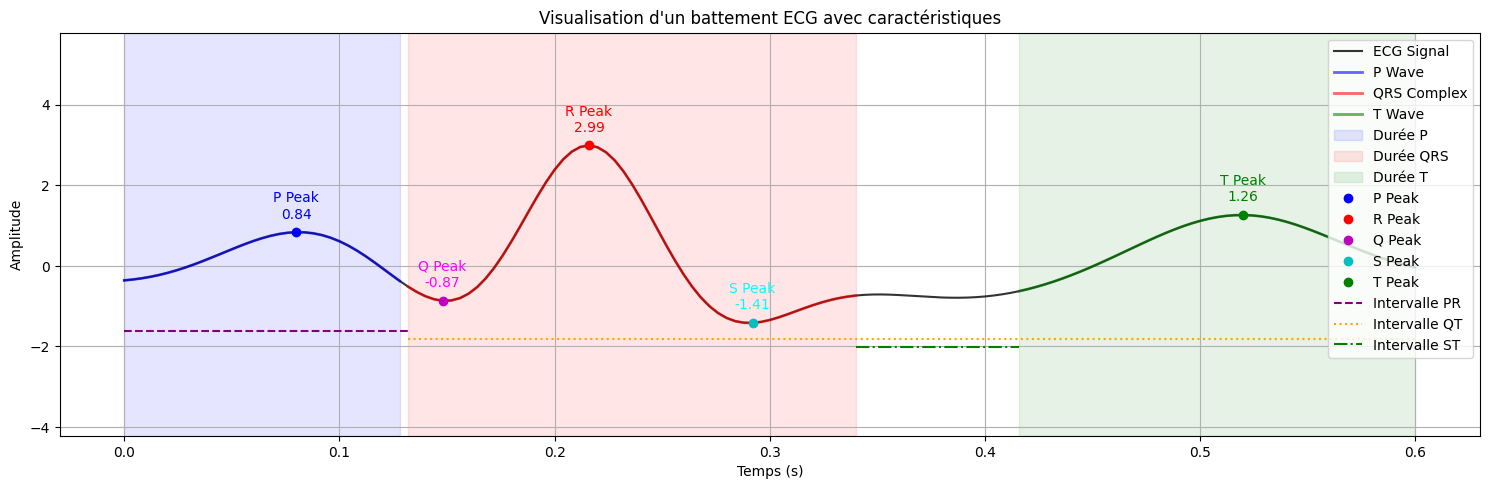

In [35]:
import matplotlib.pyplot as plt
import numpy as np

# Convert list of dicts to dict of lists (easier for plotting)
feature_dict = {}
for f in features_per_beat[-10:]:
    for key, val in f.items():
        feature_dict.setdefault(key, []).append(val)

beats = np.arange(1, len(features_per_beat) + 1)

for i in beats:

  beat_idx = i - 1
  print("beat: ", beat_idx)
  feat = features_per_beat[beat_idx]

  start, end = feat['start'], feat['end']
  #start, end = int(start*250), int(end*250)

  plot_beat_with_features(
      signal[start:end],
      all_predicted_masks.flatten()[start:end],
      beat_features=feat,
      fs=fs,
      window_start=start
  )


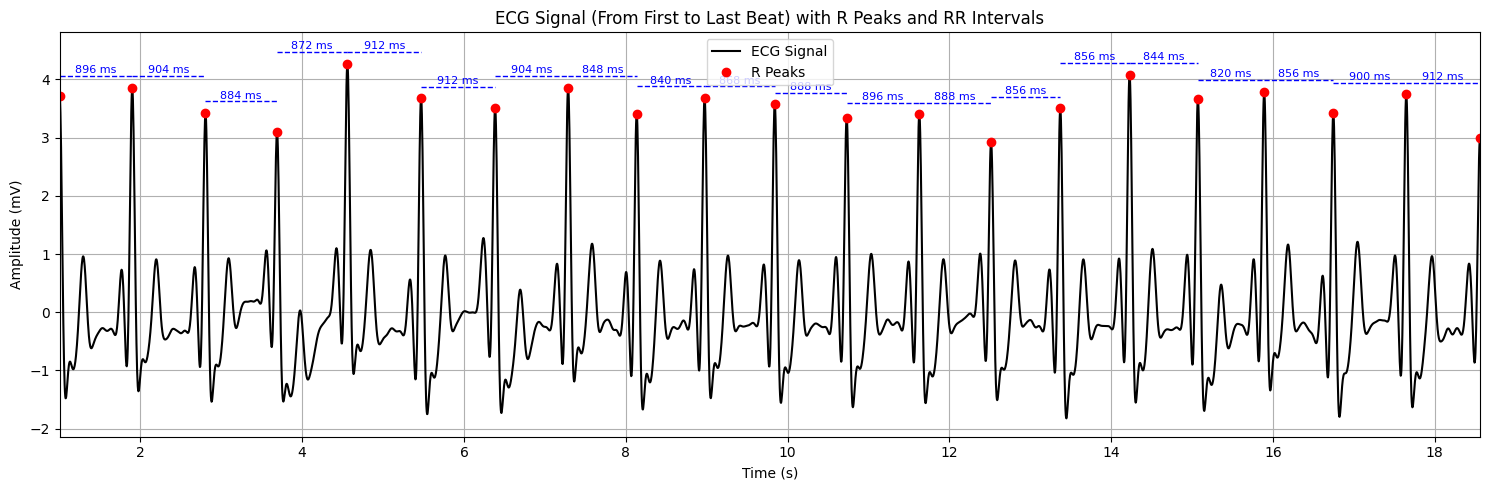

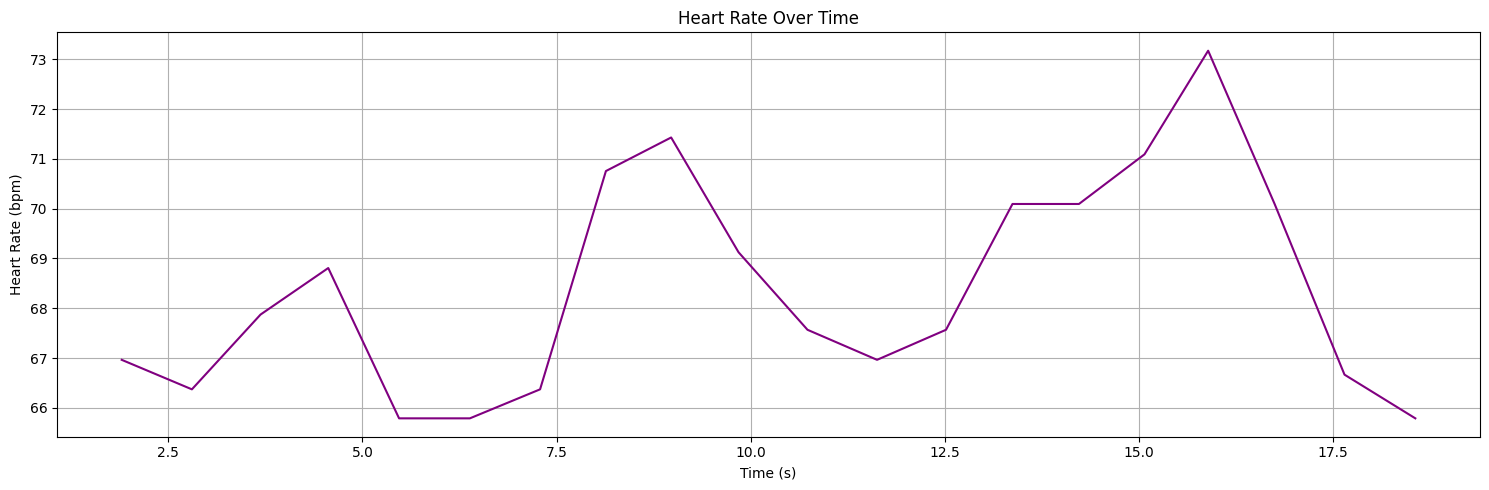

In [36]:
# Suppose you have your features already extracted
r_indices = [f['R_index'] for f in features_per_beat]

plot_ecg_with_rr(signal, r_indices, fs=250)
# Assuming 'r_indices' is already defined from earlier analysis

plot_heart_rate(signal, r_indices, fs=250, duration=5)


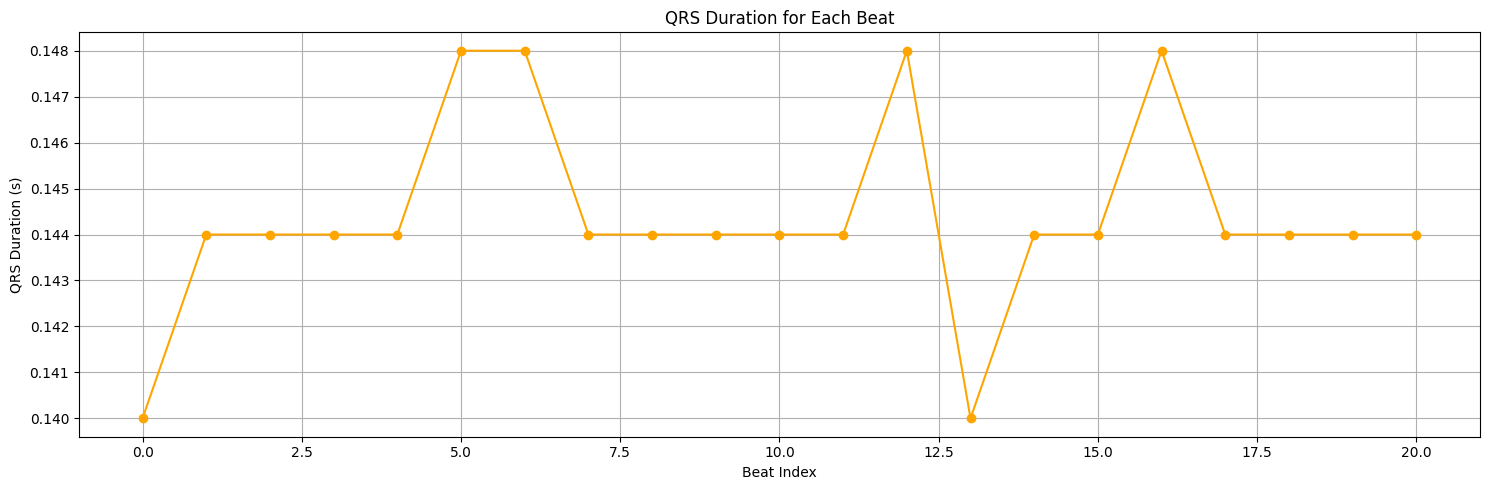

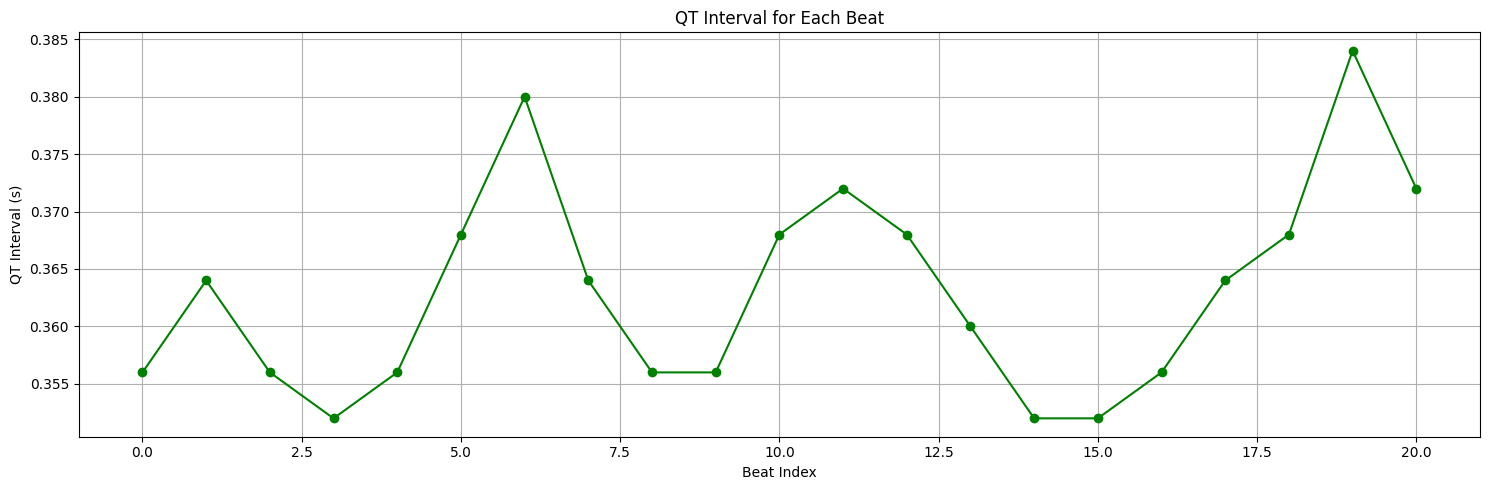

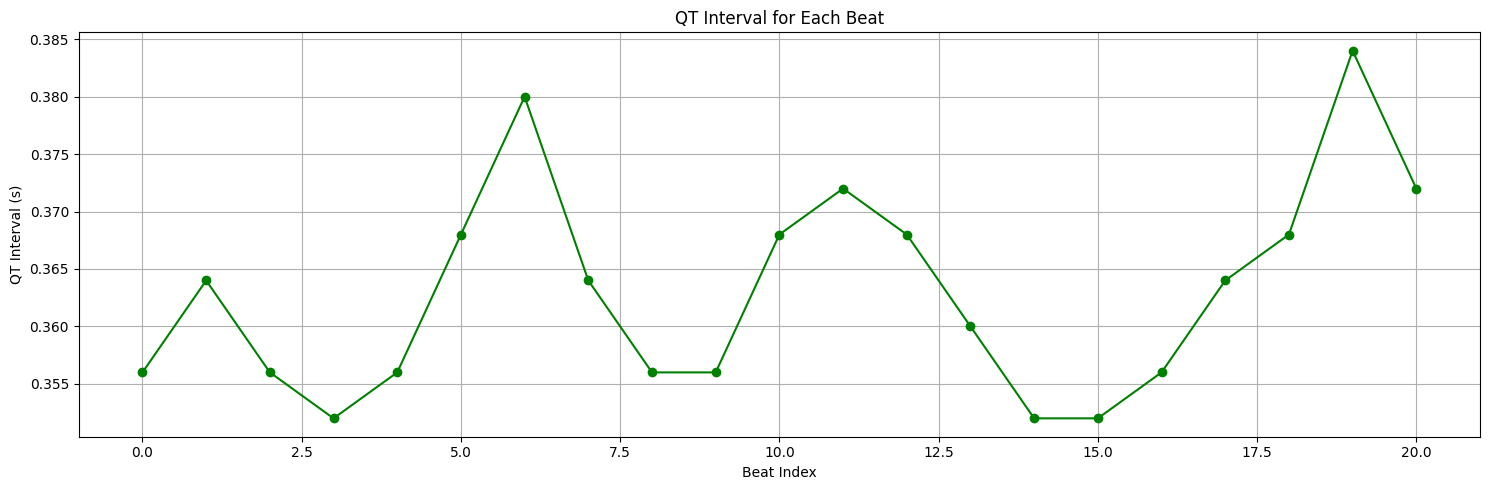

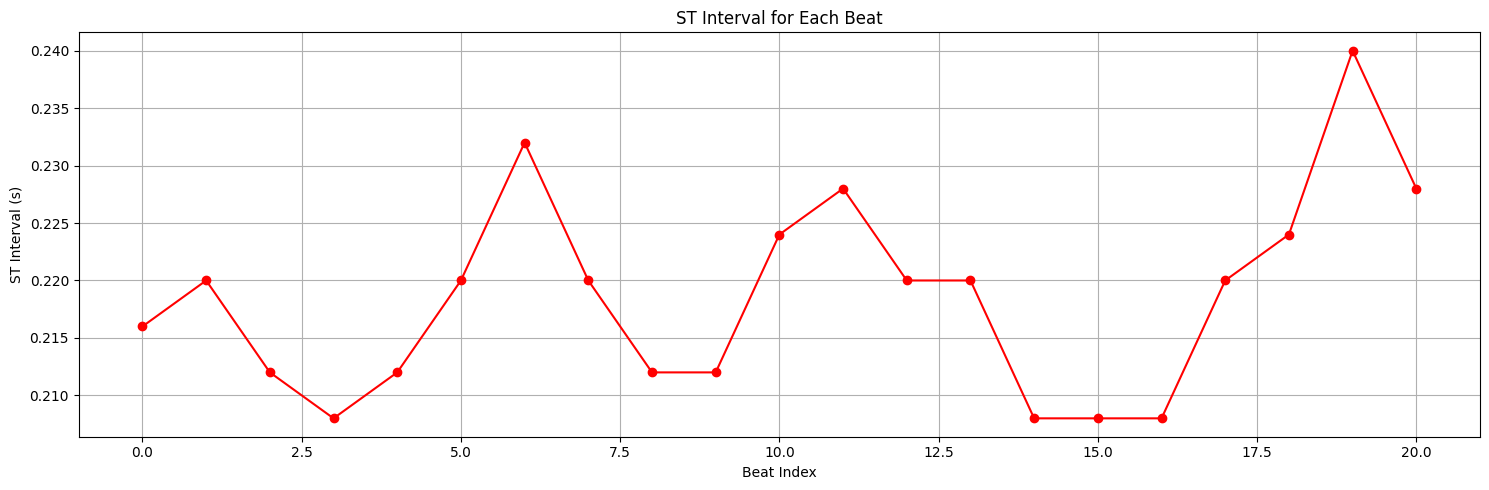

In [37]:
# Assuming 'beat_features_list' contains the features for each beat
plot_qrs_duration(signal, features_per_beat, fs=250)
plot_qt_interval(signal, features_per_beat, fs=250)
plot_qt_interval(signal, features_per_beat, fs=250)
plot_st_interval(signal, features_per_beat, fs=250)
